In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf

import numpy as np
!pip install keras-tuner
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PowerTransformer
import pickle # To match the saving part

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sheets = ['stress', 'force']
file_path = '/content/drive/MyDrive/Colab Notebooks/Stress Prediction/data/'
checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/'

def retrieve_file(sheet_names, base_path, file_prefix='lab_result_', file_indices=range(1, 5), file_suffix='.xlsx'):

    data = {sheet: {} for sheet in sheet_names}

    for i in file_indices:
        file_path = f"{base_path}{file_prefix}{i}{file_suffix}"
        for sheet in sheet_names:
            try:
                df = pd.read_excel(file_path, sheet_name=sheet)
                data[sheet][i] = df
            except Exception as e:
                print(f"Failed to load {sheet} from {file_path}: {e}")

    return data

data = retrieve_file(sheets, file_path)

In [ ]:
test2predict = pd.read_excel(f"{file_path}test_set.xlsx", sheet_name="stress")
print(test2predict.head(3))
print(test2predict.shape)

       Time      1_red    1_blue  1_yellow      2_red     2_blue   2_yellow  \
0  0.000000 -12.057262 -4.761482 -8.601844  87.792969 -32.508892 -32.194313   
1  0.000488  -4.739696 -3.143384 -8.263125  88.090309 -27.136887 -32.596123   
2  0.000977  -2.906941 -3.239572 -8.387451  87.913673 -24.687252 -32.022110   

       3_red     3_blue   3_yellow      4_red     4_blue   4_yellow  \
0 -35.198792 -32.017544 -31.783356 -38.175938 -24.052259 -16.594654   
1 -36.028408 -33.828205 -32.184719 -38.733276 -24.425894 -19.157318   
2 -36.100342 -34.621265 -31.831137 -37.983753 -23.649883 -17.818398   

       5_red     5_blue   5_yellow      6_red     6_blue  6_yellow  
0 -25.173454 -31.440985 -26.871092 -37.771828 -17.144352 -5.418063  
1 -25.798365 -32.846844 -26.628025 -37.553535 -15.890195 -6.920620  
2 -25.043665 -30.317270 -26.068974 -35.700493 -15.769137 -6.555922  
(125243, 19)


In [ ]:
print(data['stress'][1].info())
print(data['force'][1].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79679 entries, 0 to 79678
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      79679 non-null  float64
 1   1_red     79679 non-null  float64
 2   1_blue    79679 non-null  float64
 3   1_yellow  79679 non-null  float64
 4   2_red     79679 non-null  float64
 5   2_blue    79679 non-null  float64
 6   2_yellow  79679 non-null  float64
 7   3_red     79679 non-null  float64
 8   3_blue    79679 non-null  float64
 9   3_yellow  79679 non-null  float64
 10  4_red     79679 non-null  float64
 11  4_blue    79679 non-null  float64
 12  4_yellow  79679 non-null  float64
 13  5_red     79679 non-null  float64
 14  5_blue    79679 non-null  float64
 15  5_yellow  79679 non-null  float64
 16  6_red     79679 non-null  float64
 17  6_blue    79679 non-null  float64
 18  6_yellow  79679 non-null  float64
dtypes: float64(19)
memory usage: 11.6 MB
None
<class 'pandas.core.frame

In [ ]:
def merge_force_stress_by_index(data, indices):

    merged_data = {}

    for i in indices:
        force_df = data['force'][i]
        stress_df = data['stress'][i]

        # Round time indices
        force_df.index = force_df.index.round(6)
        stress_df.index = stress_df.index.round(6)

        # Join on index
        merged_df = force_df.join(stress_df, how='left')
        merged_df = merged_df.drop(['Time', "Time (s)"], axis =1)

        # Store in dictionary
        merged_data[i] = merged_df


    return merged_data

In [ ]:
merged = merge_force_stress_by_index(data, list(range(1, 5)))


print(merged[1].head(3))
print(merged[2].head(3))
print(merged[3].head(3))
print(merged[4].head(3))
print(merged[1].tail(3))
print(merged[2].tail(3))
print(merged[3].tail(3))
print(merged[4].tail(3))

     Z (kN)    Y (kN)    X (kN)     1_red    1_blue  1_yellow      2_red  \
0 -0.007633 -0.018777  0.002748  7.027635 -0.968539 -5.033704  86.325539   
1 -0.007633 -0.019693  0.001374  5.170662 -1.040296 -5.005359  86.484512   
2 -0.006106 -0.019235 -0.001374 -2.007045 -1.329972 -5.023304  86.128029   

      2_blue   2_yellow      3_red  ...   3_yellow      4_red     4_blue  \
0  -9.106050 -23.995487 -33.472420  ... -13.535583 -15.988114 -22.284679   
1 -11.565234 -24.339895 -34.848721  ... -15.270052 -16.401314 -21.111084   
2 -13.928916 -24.626902 -35.102882  ... -16.478926 -15.339488 -22.164925   

   4_yellow      5_red     5_blue   5_yellow      6_red     6_blue  6_yellow  
0 -1.871331 -36.287247 -25.802952 -17.571384 -19.231688 -14.064648 -3.302813  
1 -4.117261 -35.633492 -26.002399 -18.713795 -21.055626 -13.357672 -2.121190  
2 -4.697940 -37.868748 -24.314394 -19.107561 -20.109701 -12.912180 -2.023937  

[3 rows x 21 columns]
    Z (kN)    Y (kN)  X (kN)     1_red    1_blue  1

In [ ]:
#UDP is mostly likely used since high-speed, high-frequency (e.g., 0.0001s interval), hence the stress data out of sync/ with NA will be removed.


In [ ]:
# Check if key 4 exists in the dictionary
if 4 in merged:
    # Create a copy of the DataFrame associated with key 4
    df_copy = merged[4].copy()

    # Replace 0 with NaN in the copied DataFrame
    df_modified = df_copy.replace(0, np.nan)

    # Drop rows with NaN values
    df_modified.dropna(inplace=True)

    # Update the original dictionary with the modified DataFrame
    merged[4] = df_modified

    # Print the last 10 rows of the modified DataFrame for verification
    print(merged[4].tail(10))
else:
    print("DataFrame for key 4 is missing.")

         Z (kN)    Y (kN)    X (kN)      1_red    1_blue  1_yellow      2_red  \
84710  0.002290 -0.035723 -0.003206 -14.339729 -2.705259 -9.010238  85.245911   
84711  0.003053 -0.037097 -0.003664 -15.857787 -3.154754 -9.524739  85.052948   
84712  0.003817 -0.038471 -0.005038  -5.934983 -1.606125 -8.582131  85.392578   
84713  0.003053 -0.038471 -0.006870  -2.568967 -2.199800 -8.728957  85.345741   
84714  0.003053 -0.037555 -0.007786  -3.289987 -1.913829 -8.979105  85.623276   
84715  0.002290 -0.035723 -0.008244  -9.125486 -2.647109 -9.453978  85.249390   
84716  0.001527 -0.033891 -0.007786 -17.758890 -3.231684 -9.859312  85.301849   
84717  0.001527 -0.032059 -0.007328 -13.494862 -2.897654 -9.159239  85.621933   
84718  0.002290 -0.030227 -0.007786 -13.455777 -2.820348 -9.085690  85.141533   
84719  0.003053 -0.029311 -0.008244  -1.042165 -1.129843 -8.162114  85.806870   

          2_blue   2_yellow      3_red  ...   3_yellow      4_red     4_blue  \
84710 -30.202511 -32.289982 

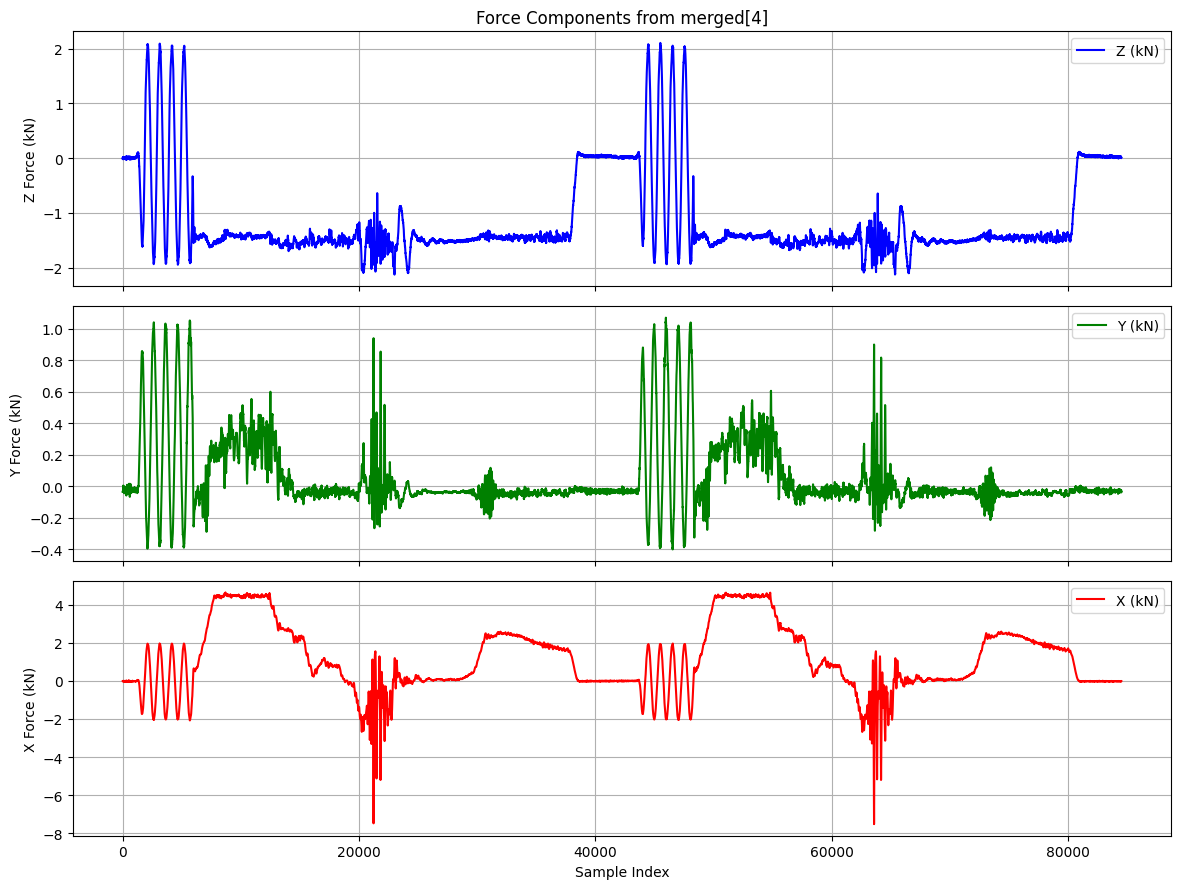

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_samples = 1000
targets = ['Z (kN)', 'Y (kN)', 'X (kN)']


# Select the target columns from merged[4]
# We'll work directly with the Pandas DataFrame for plotting
target_data_df = merged[4][targets]

# Get the number of samples (rows)
num_samples = target_data_df.shape[0]
# Create an index for the x-axis (sample number)
sample_index = np.arange(num_samples)

# --- Plotting the data using subplots ---

# Create a figure and a set of subplots
# 3 rows, 1 column (aligning vertically), share the x-axis
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)

# Plot each target column on its corresponding subplot
axes[0].plot(sample_index, target_data_df['Z (kN)'], label=targets[0], color='blue')
axes[1].plot(sample_index, target_data_df['Y (kN)'], label=targets[1], color='green')
axes[2].plot(sample_index, target_data_df['X (kN)'], label=targets[2], color='red')

# Add titles and labels to each subplot
axes[0].set_title('Force Components from merged[4]') # Main title for the set of subplots
axes[0].set_ylabel('Z Force (kN)')
axes[1].set_ylabel('Y Force (kN)')
axes[2].set_ylabel('X Force (kN)')
axes[2].set_xlabel('Sample Index') # X-label only on the bottom subplot since x-axis is shared

# Add legends to each subplot
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Add grids for readability
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)

# Adjust layout to prevent titles/labels overlapping
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
def transform_data(merged, transformer1=None, transformer2=None):
    """
    Applies Yeo-Johnson transformation using separate PowerTransformers for features and targets.

    Args:
    - merged (dict): Dictionary of input DataFrames (e.g., merged[1], merged[2], merged[3], merged[4]).
                     Each DataFrame should contain both feature and target columns.
    - transformer1 (PowerTransformer, optional): Pass a PowerTransformer instance for features.
                                                If None, a new one is created and fitted.
    - transformer2 (PowerTransformer, optional): Pass a PowerTransformer instance for targets.
                                                If None, a new one is created and fitted.

    Returns:
    - transformed_data (dict): Dictionary of transformed DataFrames (train1, train2, val, test).
                               Each DataFrame contains transformed features and transformed targets.
    - fitted_transformer_fea (PowerTransformer): The fitted transformer object for features,
                                                 useful for saving to disk and deployment.
    - fitted_transformer_tar (PowerTransformer): The fitted transformer object for targets,
                                                 useful for saving to disk and deployment (e.g., inverse transform).
    """
    # Define target columns
    target_columns = ['Z (kN)', 'Y (kN)', 'X (kN)']
    all_dfs_exist = all(i in merged and isinstance(merged[i], pd.DataFrame) for i in range(1, 5))

    transformer1 = PowerTransformer(method='yeo-johnson', standardize=True) # For features
    transformer2 = PowerTransformer(method='yeo-johnson', standardize=True) # For targets

    # Drop missing values from the specified DataFrames
    for key, df in merged.items():
        # Replace 0 with NaN in the DataFrame
        df.replace(0, np.nan, inplace=True)
        # Drop rows with NaN values
        df.dropna(inplace=True)
        # Update the dictionary with the modified DataFrame
        merged[key] = df


    # --- Prepare training data ---
    # Combine df1 and df2 for training (as per original function)
    df_combined_train = pd.concat([merged[1], merged[2]], axis=0)

    # Separate features (X) and targets (y) for training
    X_train_combined = df_combined_train.drop(columns=target_columns)
    y_train_combined = df_combined_train[target_columns]

    # Fit and transform features
    X_transformed_train_combined = transformer1.fit_transform(X_train_combined)
    X_transformed_train_combined_df = pd.DataFrame(X_transformed_train_combined, columns=X_train_combined.columns, index=X_train_combined.index)

    # Fit and transform targets
    y_transformed_train_combined = transformer2.fit_transform(y_train_combined)
    y_transformed_train_combined_df = pd.DataFrame(y_transformed_train_combined, columns=y_train_combined.columns, index=y_train_combined.index)

    # --- Prepare validation data ---
    X_val = merged[3].drop(columns=target_columns)
    y_val = merged[3][target_columns]

    # Transform validation features and targets using the fitted transformers
    X_transformed_val = transformer1.transform(X_val)
    X_transformed_val_df = pd.DataFrame(X_transformed_val,columns=X_val.columns, index=X_val.index)

    y_transformed_val = transformer2.transform(y_val)
    y_transformed_val_df = pd.DataFrame(y_transformed_val, columns=y_val.columns, index=y_val.index)

    # --- Prepare test data ---
    X_test = merged[4].drop(columns=target_columns)
    y_test = merged[4][target_columns]

    # Transform test features and targets using the fitted transformers
    X_transformed_test = transformer1.transform(X_test)
    X_transformed_test_df = pd.DataFrame(X_transformed_test, columns=X_test.columns, index=X_test.index)

    y_transformed_test = transformer2.transform(y_test)
    y_transformed_test_df = pd.DataFrame(y_transformed_test, columns=y_test.columns, index=y_test.index)

    # --- Split combined training data back and reconstruct DataFrames ---
    len_df1 = len(merged[1])

    # Training part 1 (corresponding to merged[1])
    X_transformed_train1_df = X_transformed_train_combined_df.iloc[:len_df1]
    y_transformed_train1_df = y_transformed_train_combined_df.iloc[:len_df1]
    transformed_train1 = pd.concat([X_transformed_train1_df, y_transformed_train1_df], axis=1)

    # Training part 2 (corresponding to merged[2])
    X_transformed_train2_df = X_transformed_train_combined_df.iloc[len_df1:]
    y_transformed_train2_df = y_transformed_train_combined_df.iloc[len_df1:]
    transformed_train2 = pd.concat([X_transformed_train2_df, y_transformed_train2_df], axis=1)

    # Validation and Test
    transformed_val = pd.concat([X_transformed_val_df, y_transformed_val_df], axis=1)
    transformed_test = pd.concat([X_transformed_test_df, y_transformed_test_df], axis=1)


    transformed_data = {
        'train1': transformed_train1,
        'train2': transformed_train2,
        'val': transformed_val,
        'test': transformed_test,
    }

    return transformed_data, transformer1, transformer2

In [ ]:
transformed_data, fitted_transformer_fea, fitted_transformer_tar = transform_data(merged)
test2predict = test2predict.drop('Time', axis =1)
transformed_test2predict = fitted_transformer_fea.transform(test2predict)

fitted_transformer = {
    'fea': fitted_transformer_fea,
    'tar': fitted_transformer_tar
}

# Save the fitted transformer to disk for easy deployment =)
checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/'
with open(f'{checkpoints_path}power_transformer.pkl', 'wb') as f:
    pickle.dump(fitted_transformer, f)

In [ ]:
print("Available keys in merged:", merged.keys())

Available keys in merged: dict_keys([1, 2, 3, 4])


In [ ]:
len(transformed_data['train1'])

63985

In [ ]:
print(merged[1].head(2))
print(transformed_data['test']['2_yellow'].max(), transformed_data['test']['2_yellow'].min())
transformed_data['train1'].head(2)

     Z (kN)    Y (kN)    X (kN)     1_red    1_blue  1_yellow      2_red  \
0 -0.007633 -0.018777  0.002748  7.027635 -0.968539 -5.033704  86.325539   
1 -0.007633 -0.019693  0.001374  5.170662 -1.040296 -5.005359  86.484512   

      2_blue   2_yellow      3_red  ...   3_yellow      4_red     4_blue  \
0  -9.106050 -23.995487 -33.472420  ... -13.535583 -15.988114 -22.284679   
1 -11.565234 -24.339895 -34.848721  ... -15.270052 -16.401314 -21.111084   

   4_yellow      5_red     5_blue   5_yellow      6_red     6_blue  6_yellow  
0 -1.871331 -36.287247 -25.802952 -17.571384 -19.231688 -14.064648 -3.302813  
1 -4.117261 -35.633492 -26.002399 -18.713795 -21.055626 -13.357672 -2.121190  

[2 rows x 21 columns]
1409619289.4826205 -3.849749350676846


1_red    1_blue  1_yellow     2_red    2_blue  2_yellow     3_red  \
0 -0.147581  1.133579  0.086631  0.320791  1.164623  0.101952  1.746367   
1 -0.295805  1.127398  0.092624  0.345884  0.991871  0.001161  1.592714   

     3_blue  3_yellow     4_red  ...  4_yellow     5_red    5_blue  5_yellow  \
0  1.493614 -0.003182  1.701995  ... -1.127605  1.609642  1.258780 -1.654011   
1  1.575810 -0.268240  1.669826  ... -1.249269  1.618965  1.242599 -2.034871   

      6_red    6_blue  6_yellow   Z (kN)    Y (kN)    X (kN)  
0  1.765942 -1.636582 -2.033493  1.62859 -0.014238 -0.363411  
1  1.639260 -1.602048 -1.989414  1.62859 -0.017448 -0.365285  

[2 rows x 21 columns]

Processing DataFrame for original key 1 and transformed key train1.


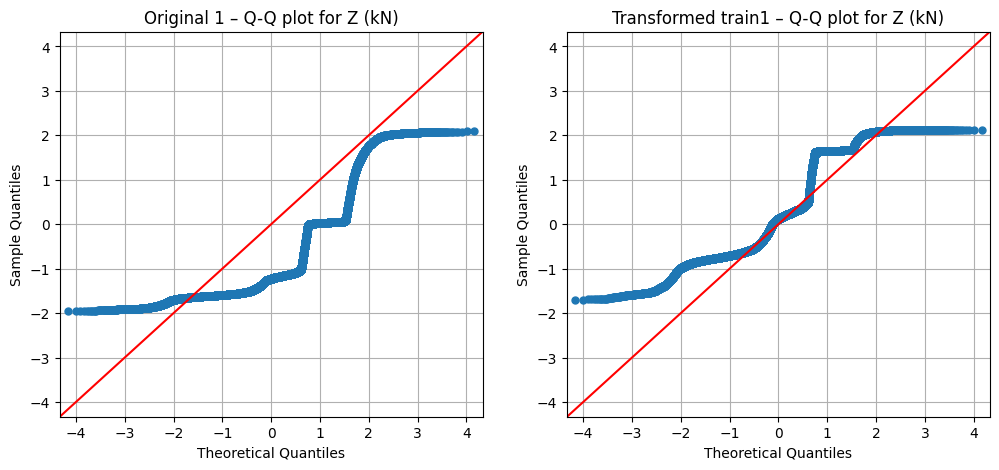

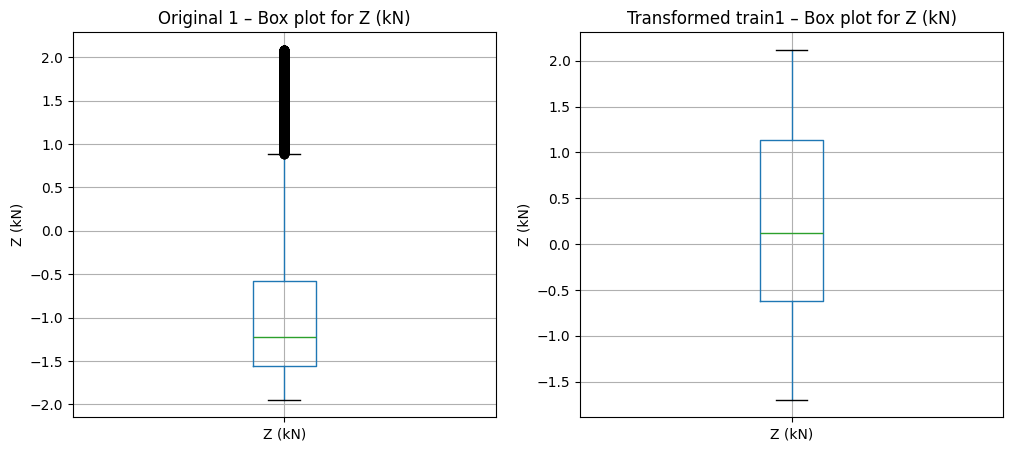

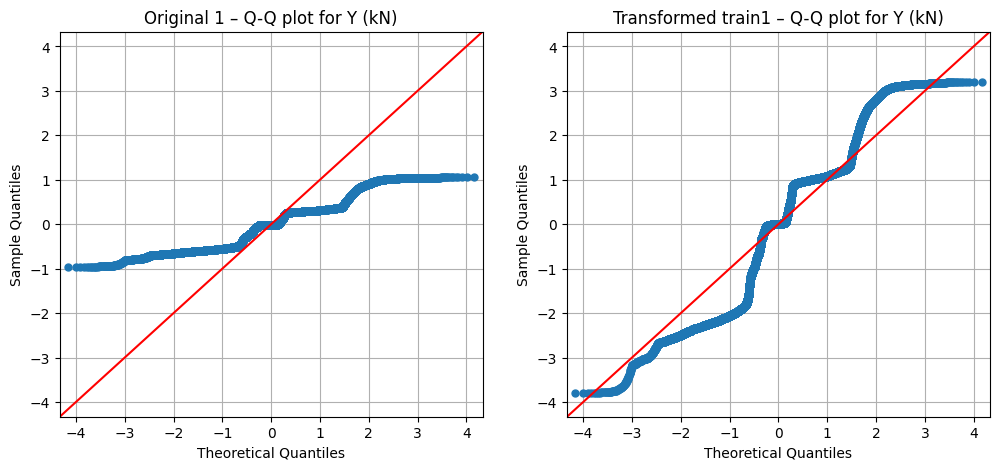

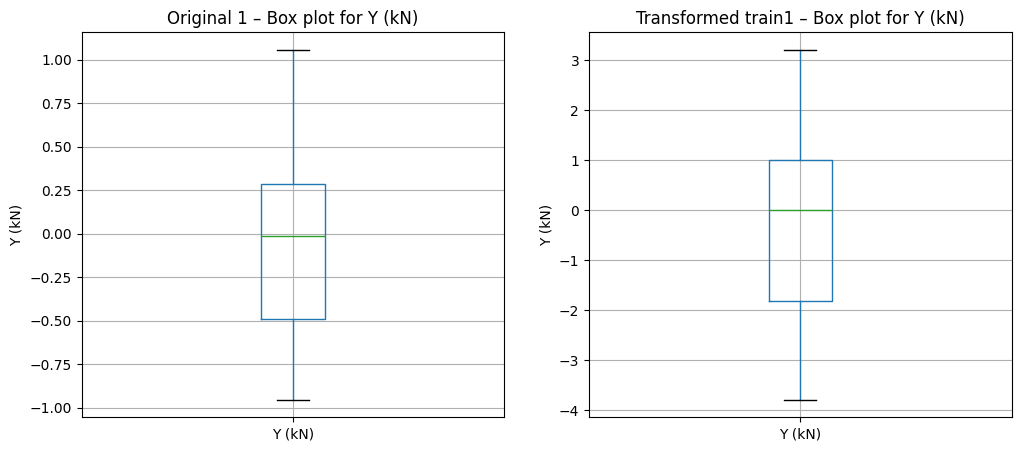

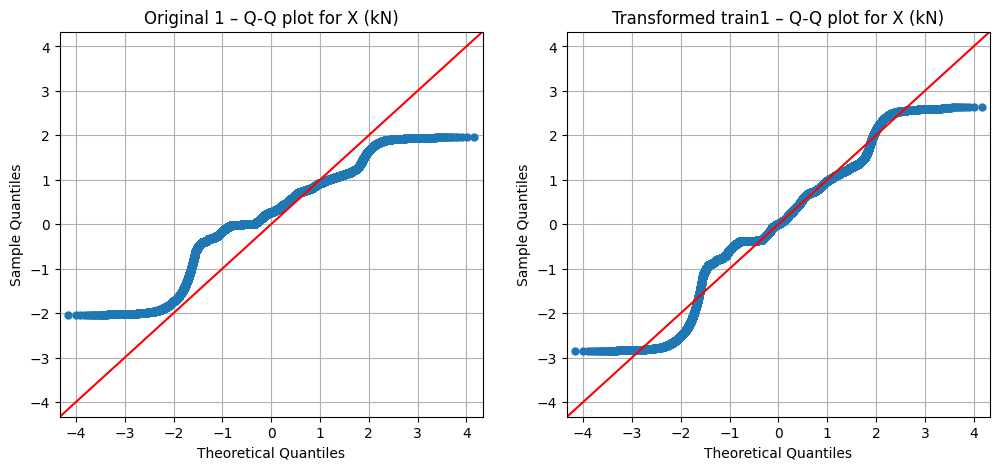

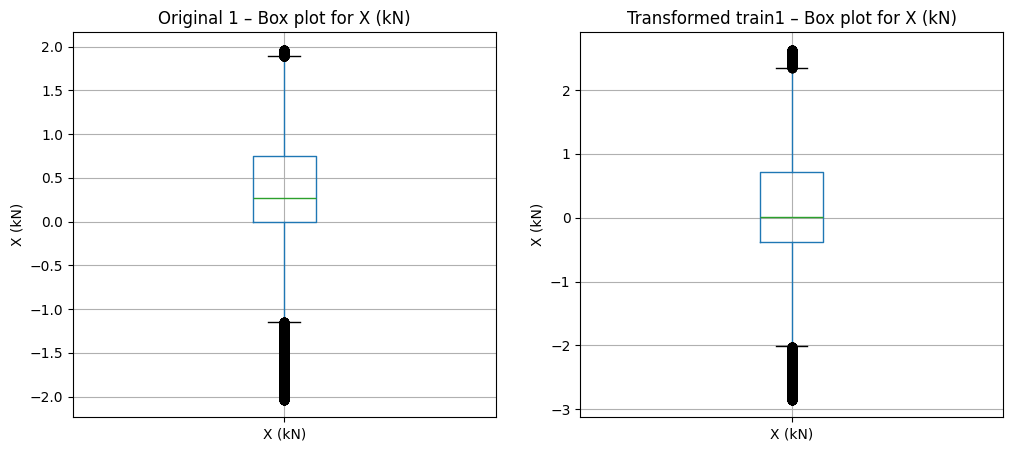

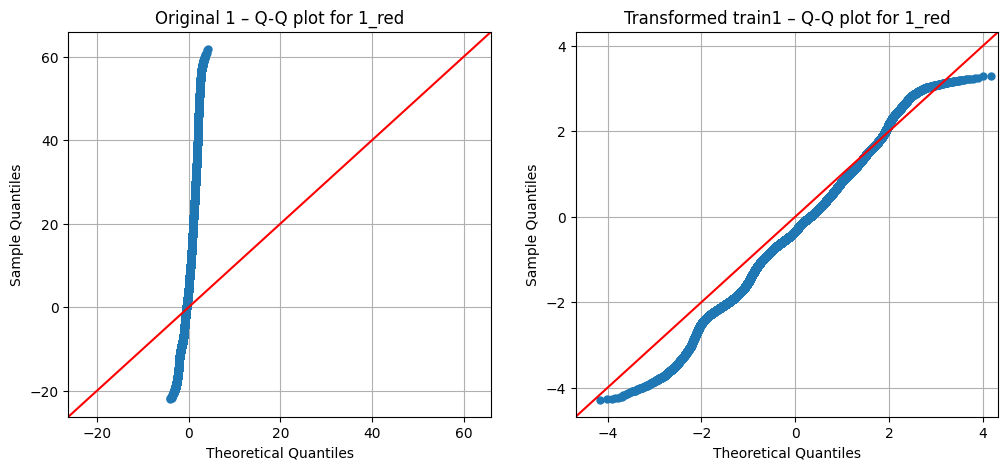

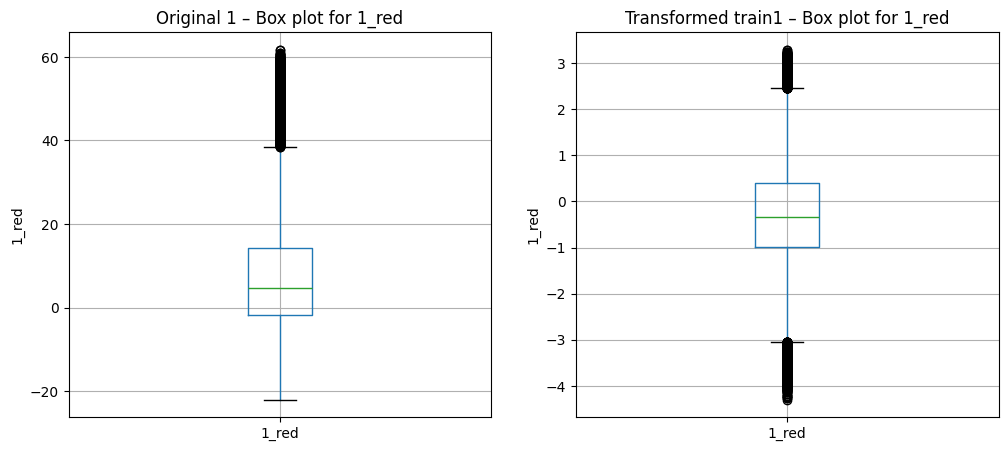

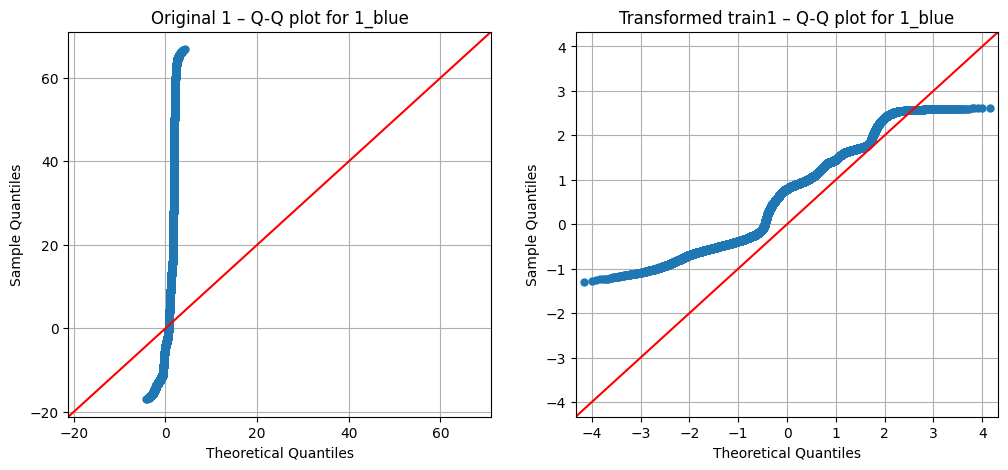

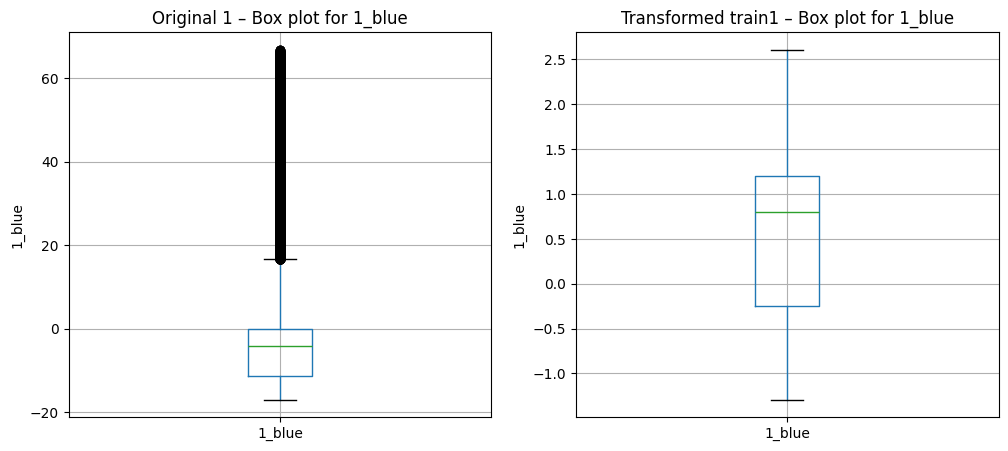

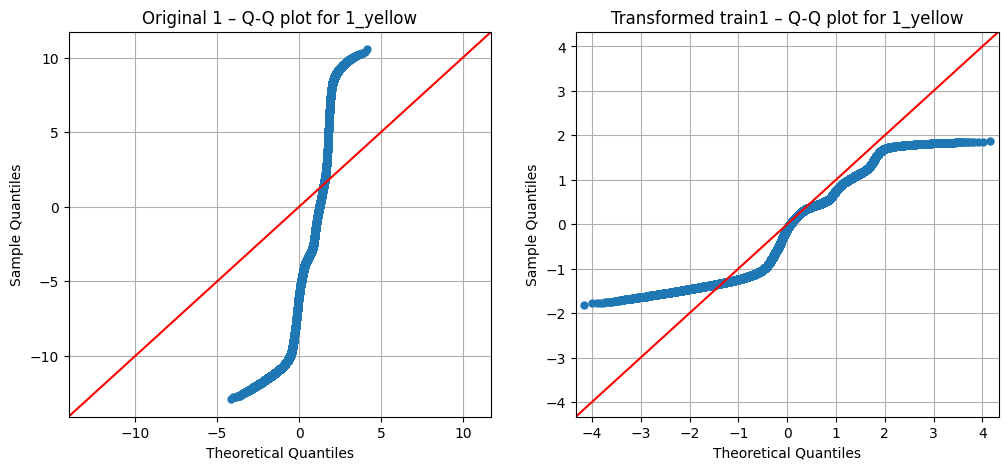

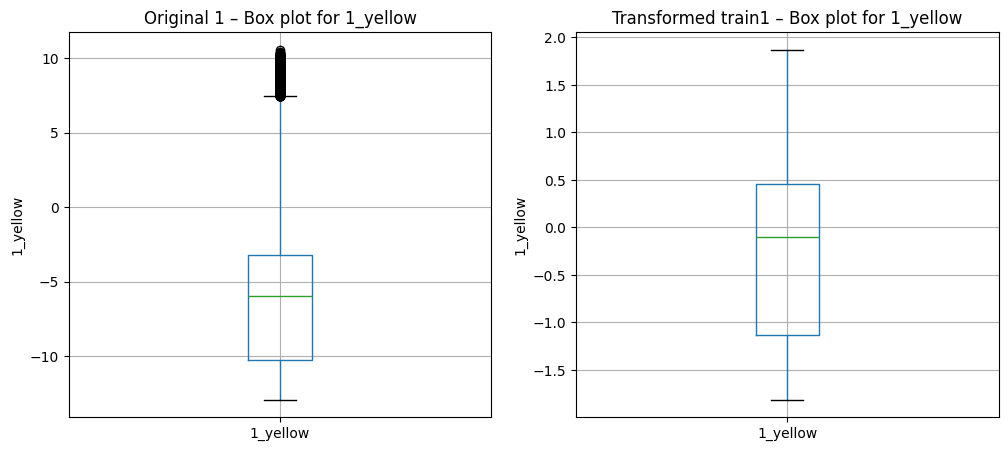

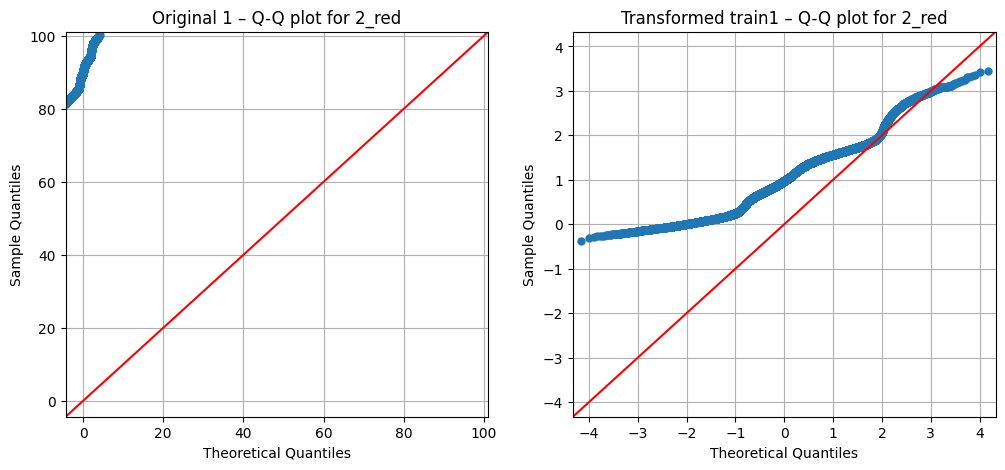

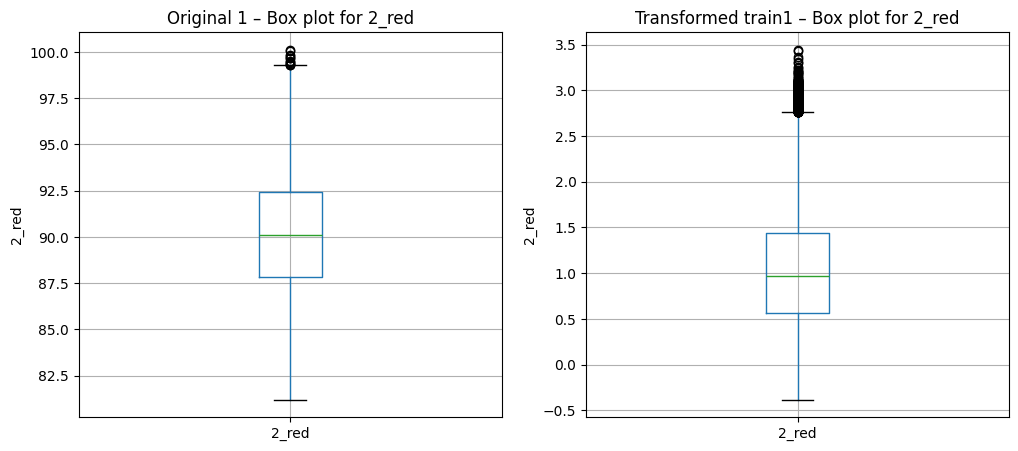

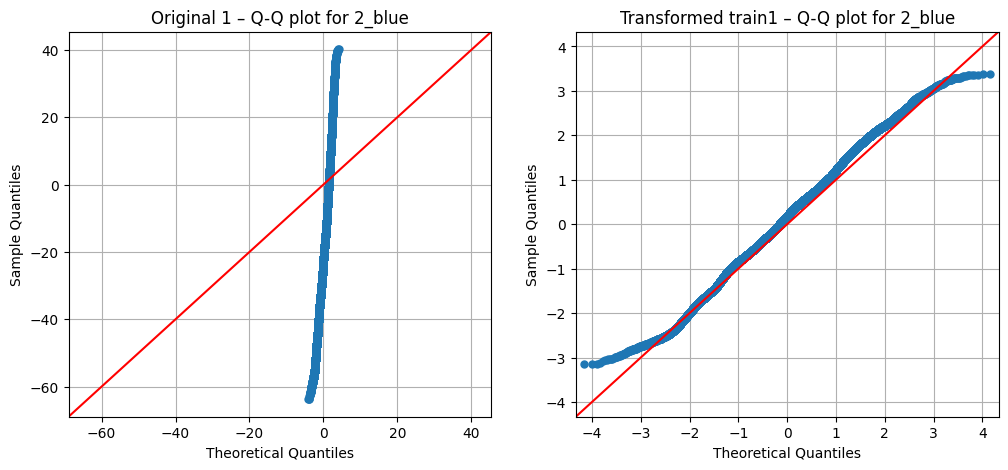

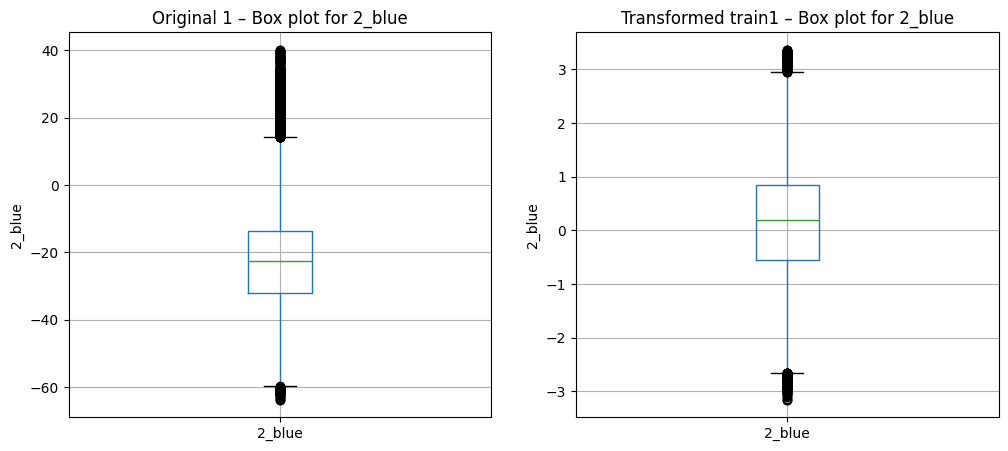

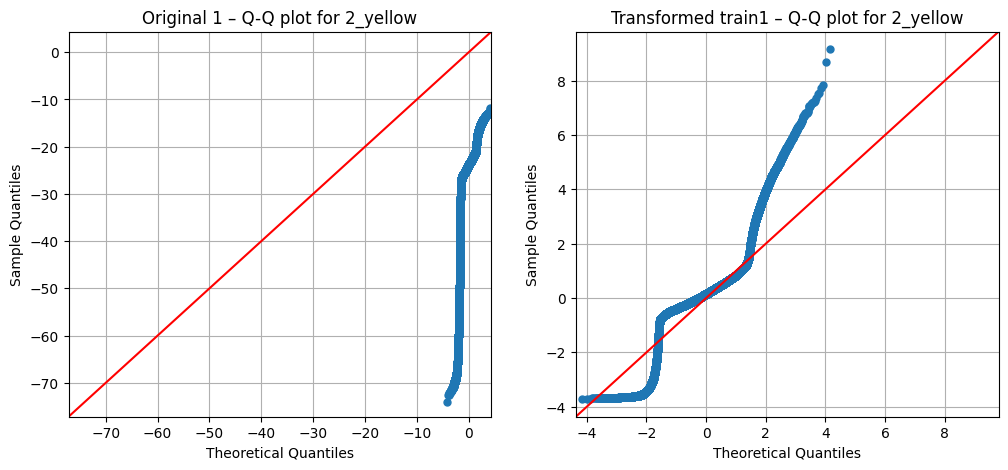

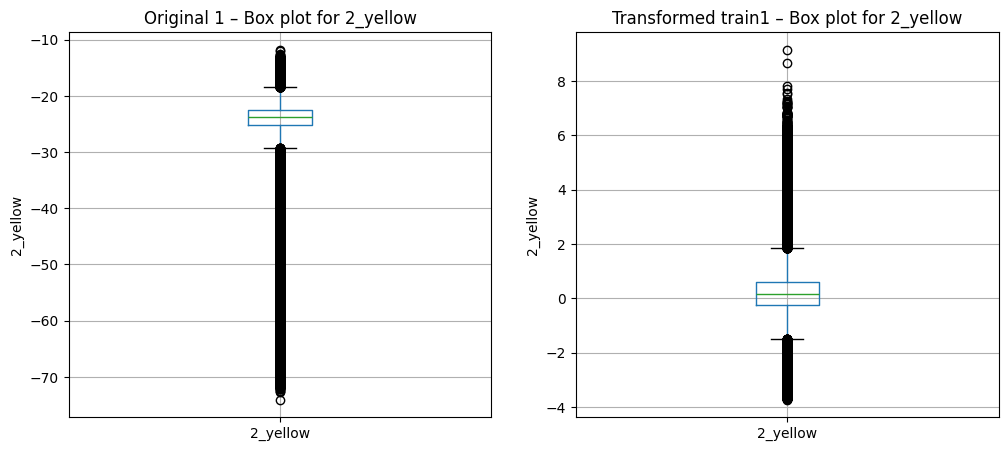

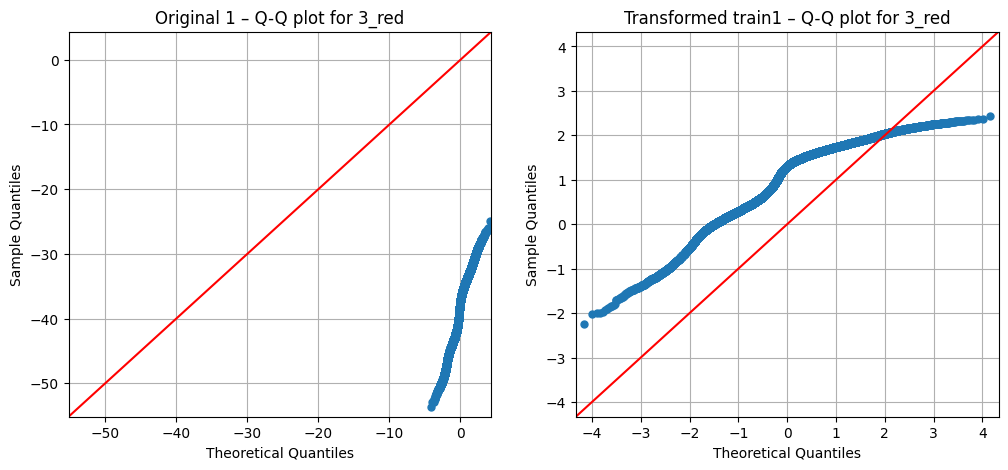

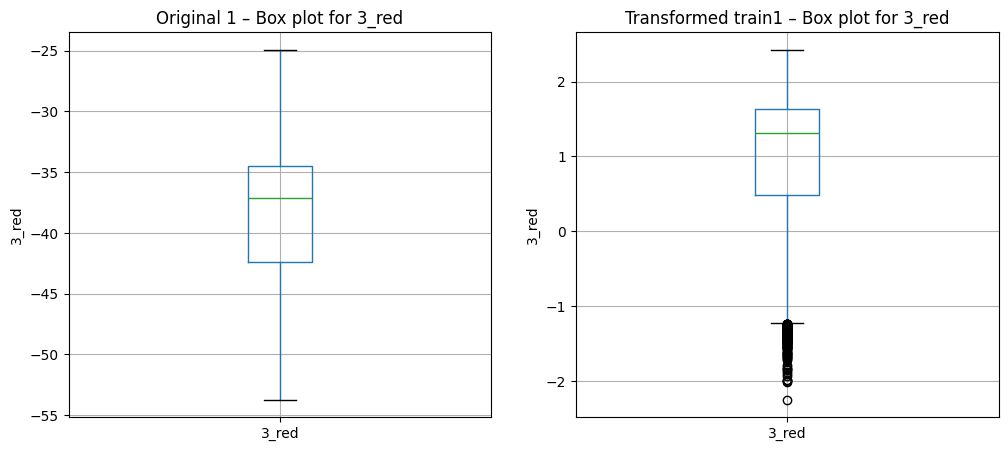

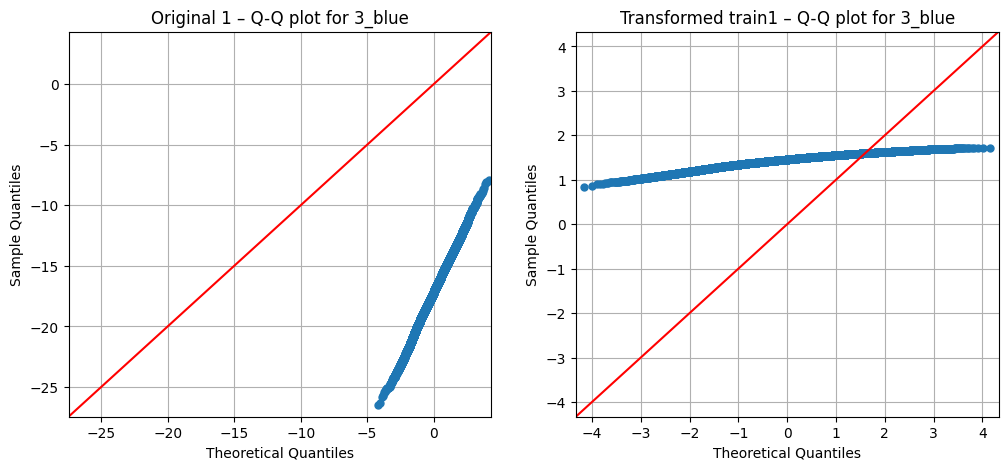

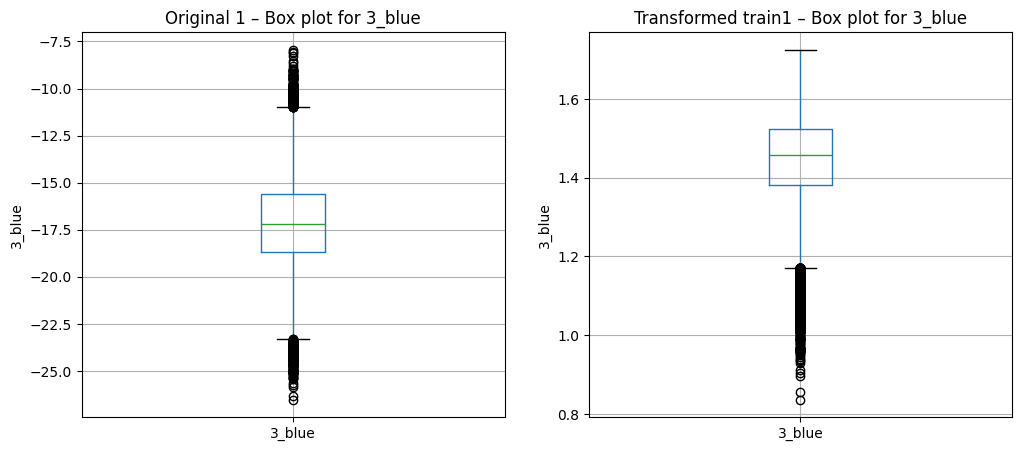

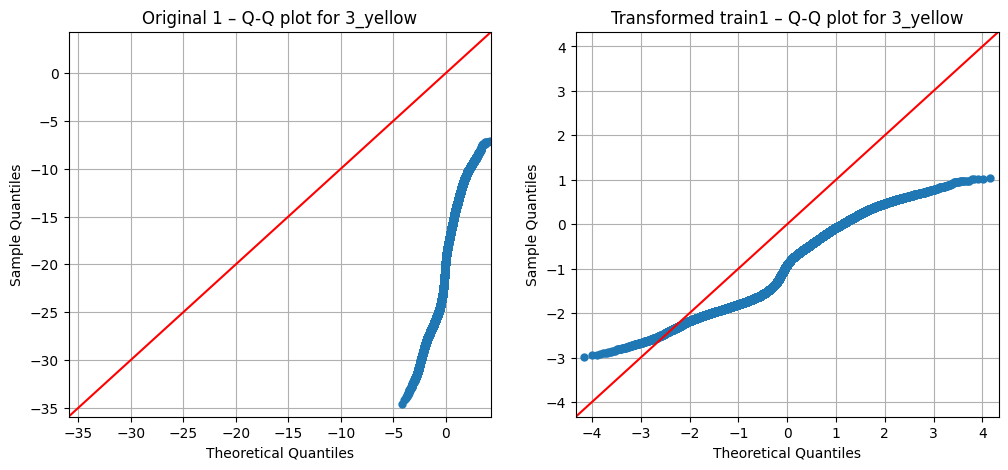

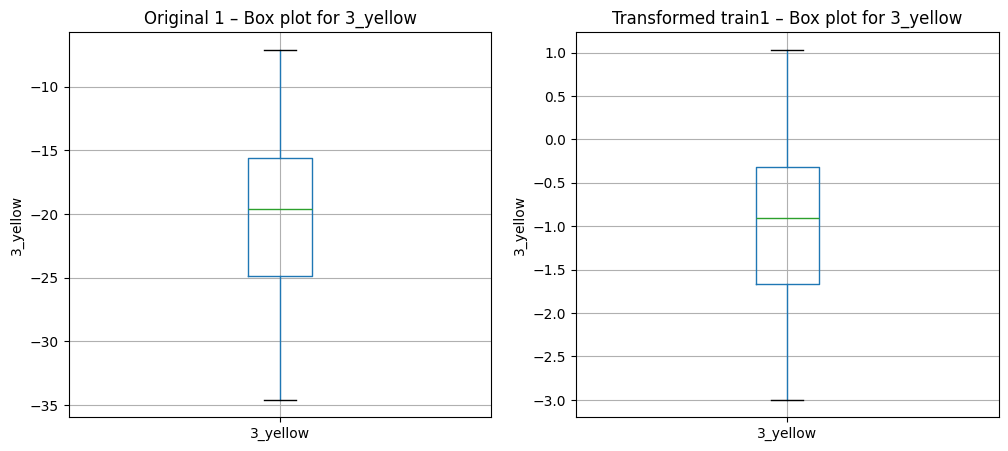

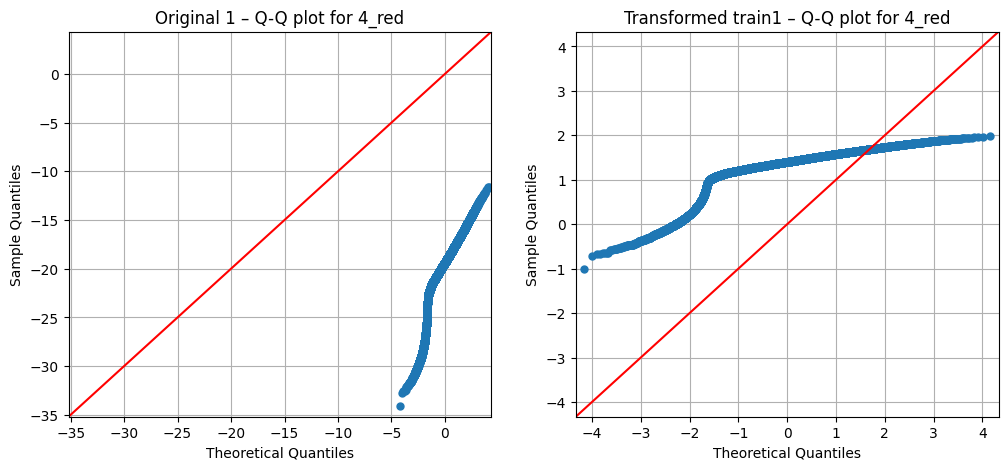

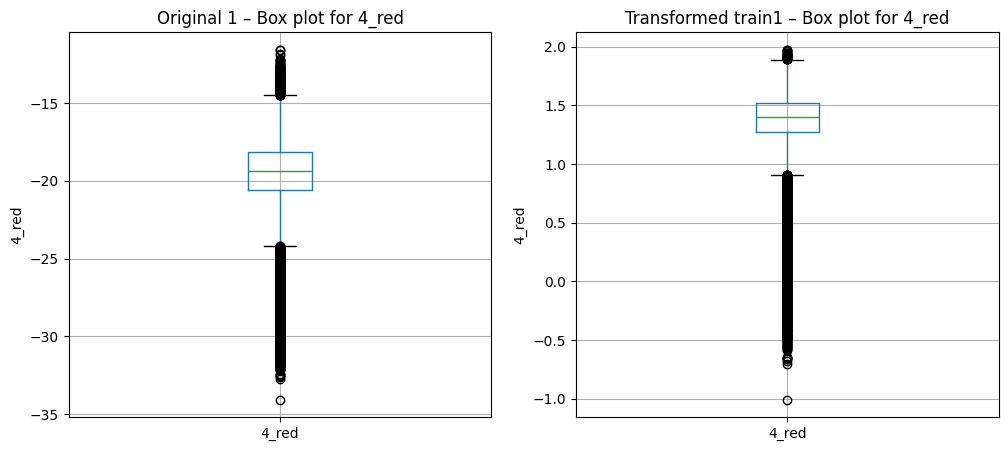

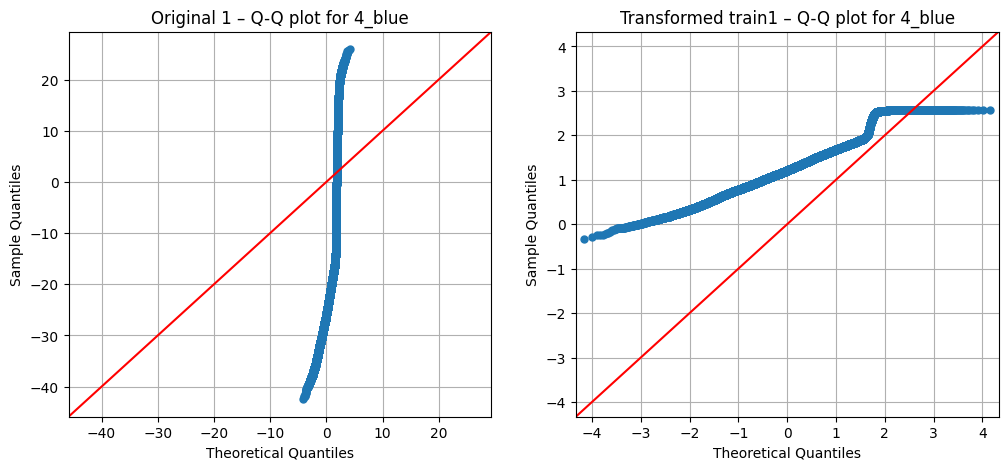

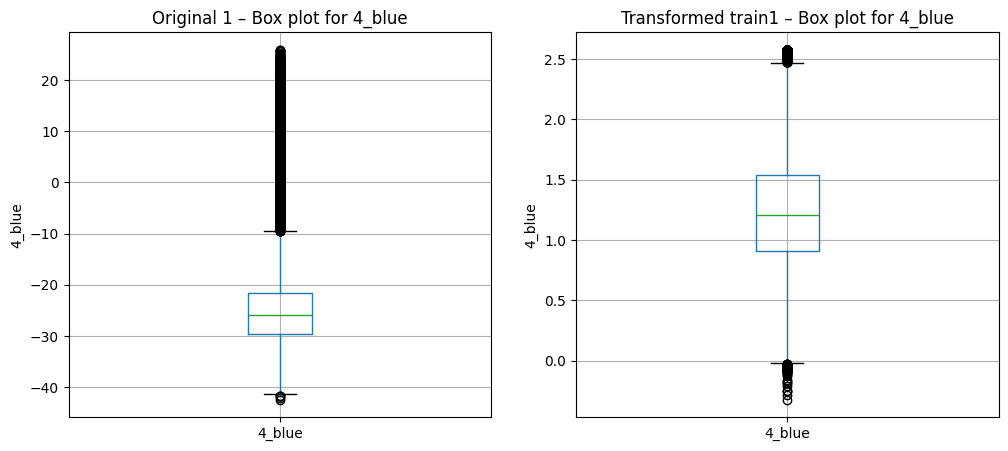

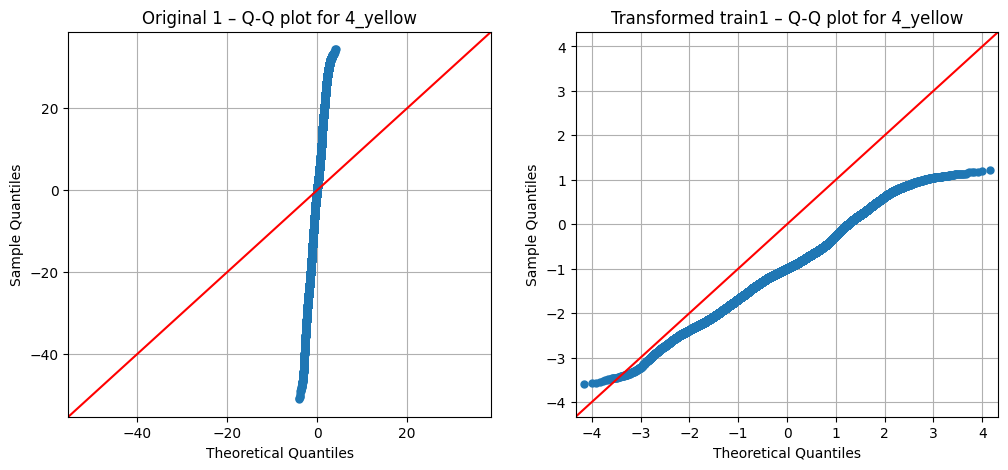

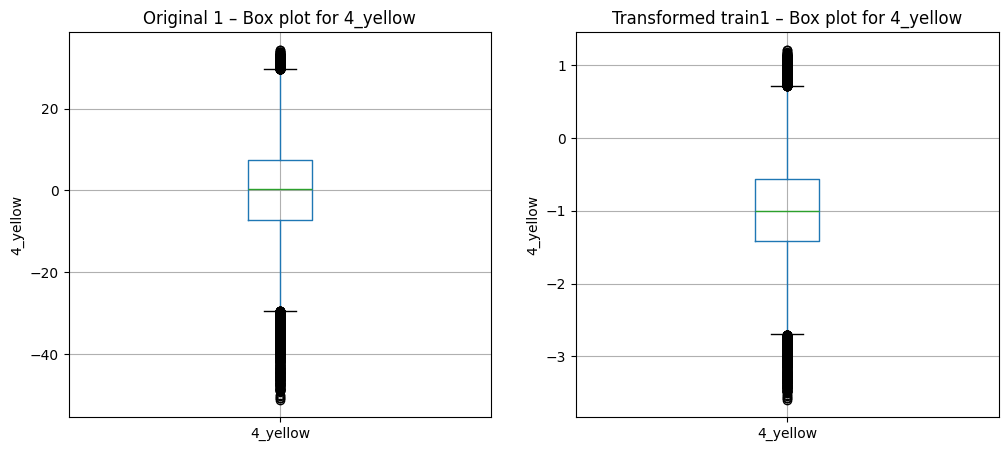

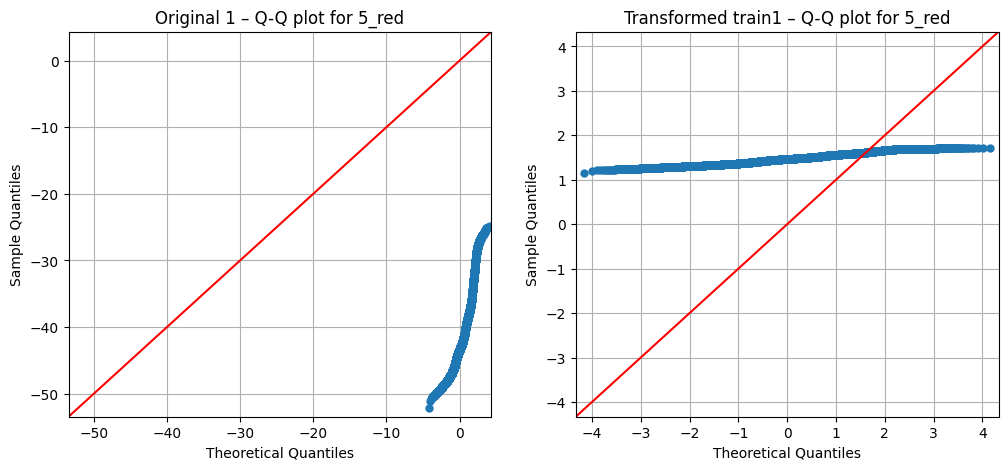

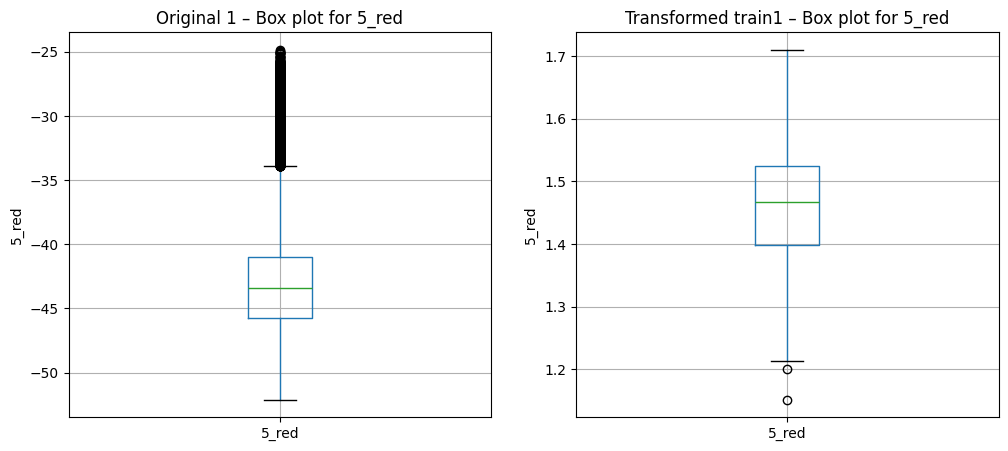

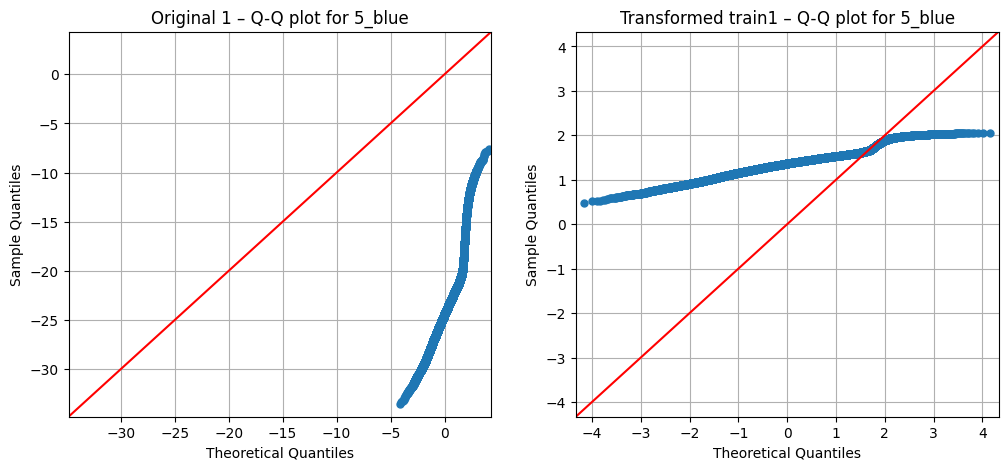

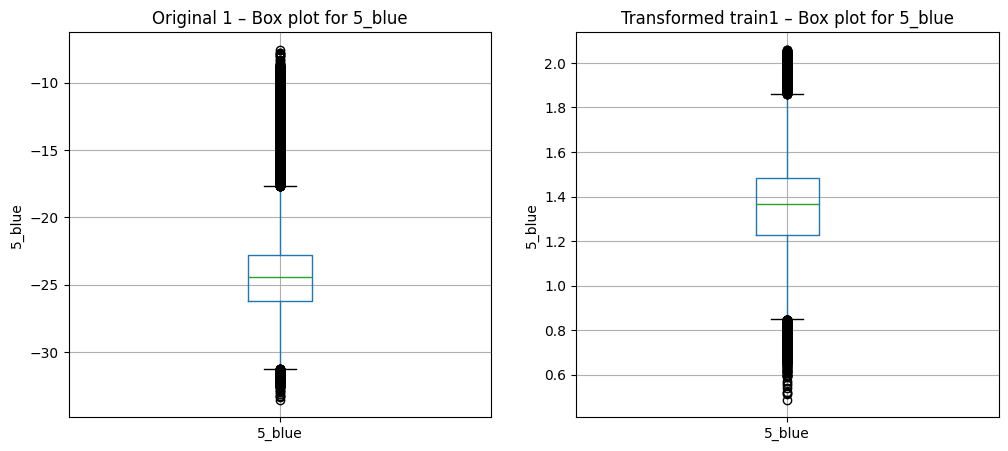

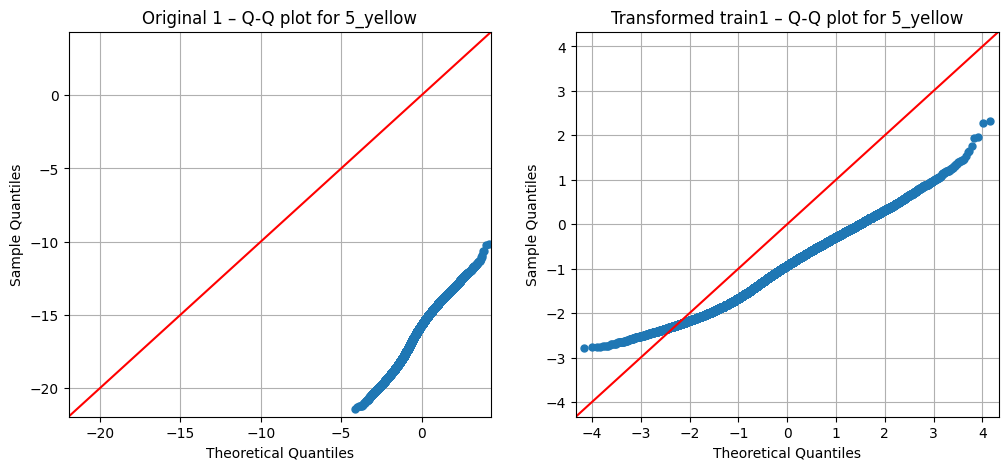

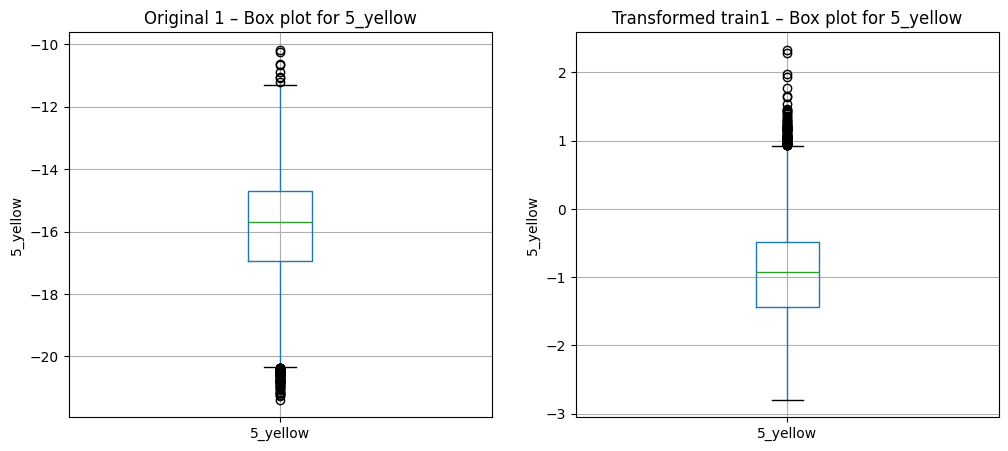

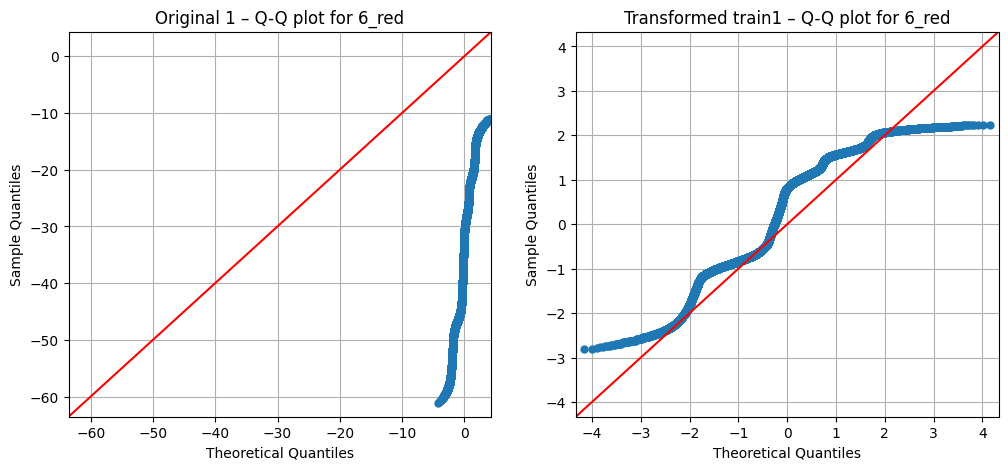

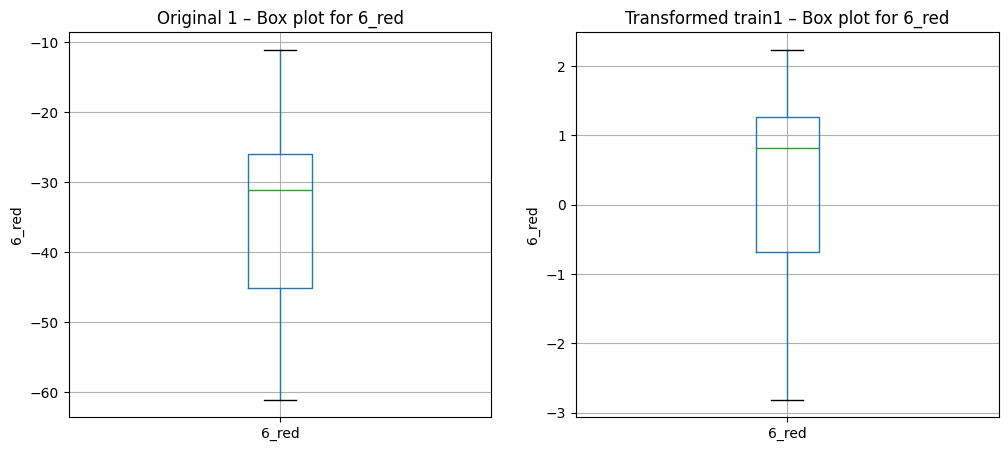

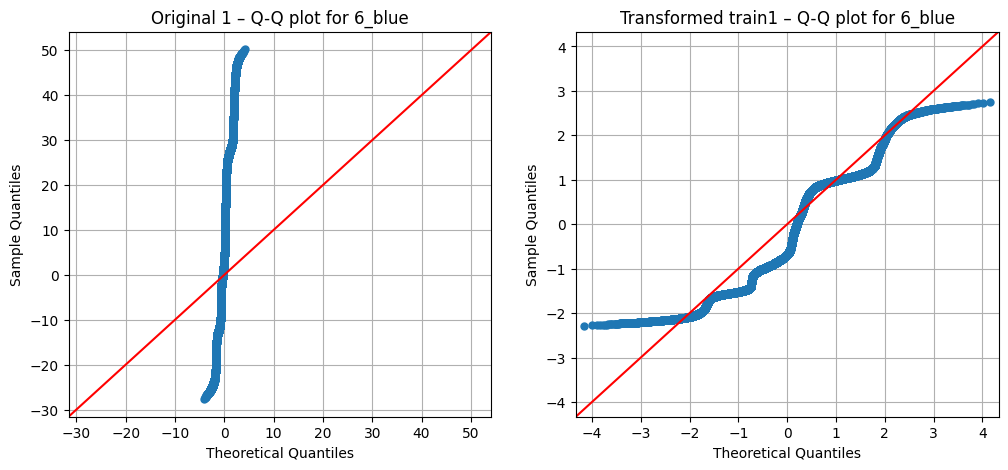

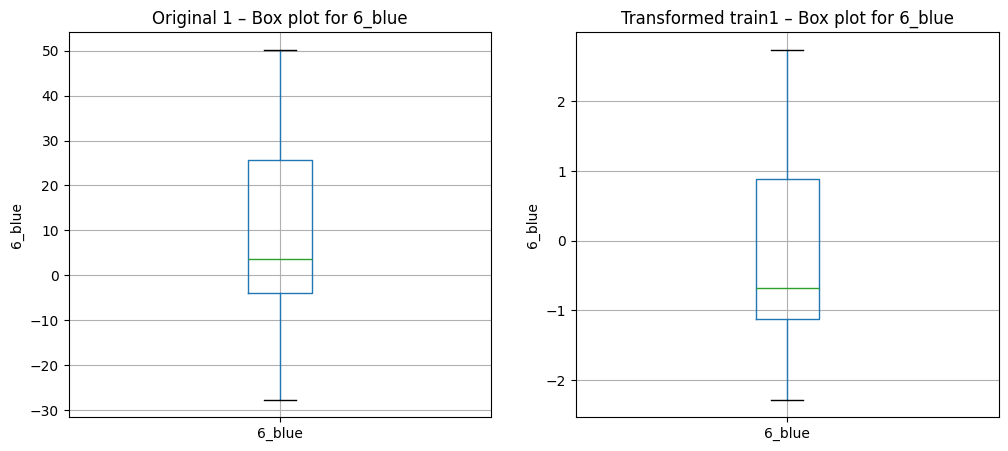

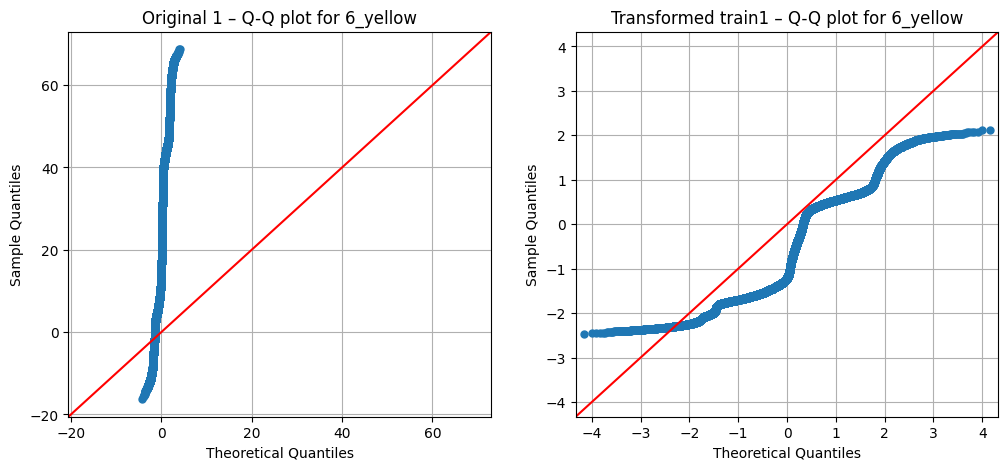

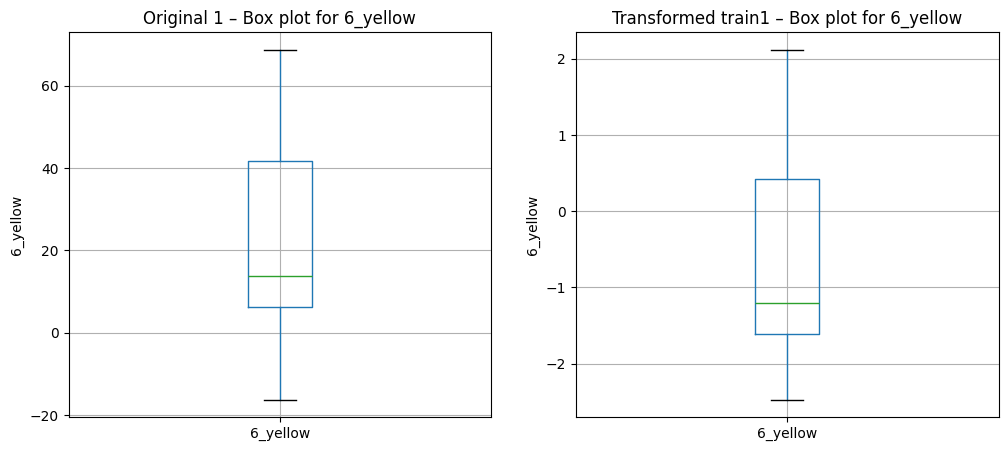

Processing DataFrame for original key 2 and transformed key train2.


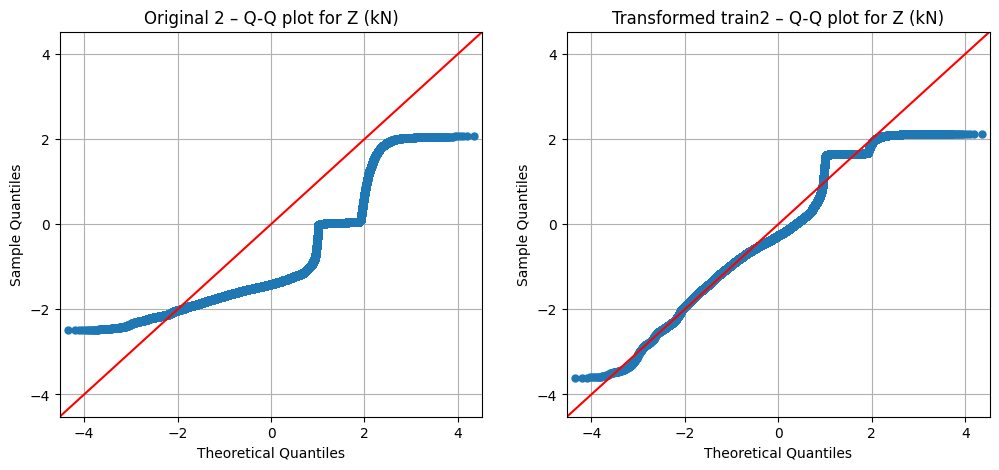

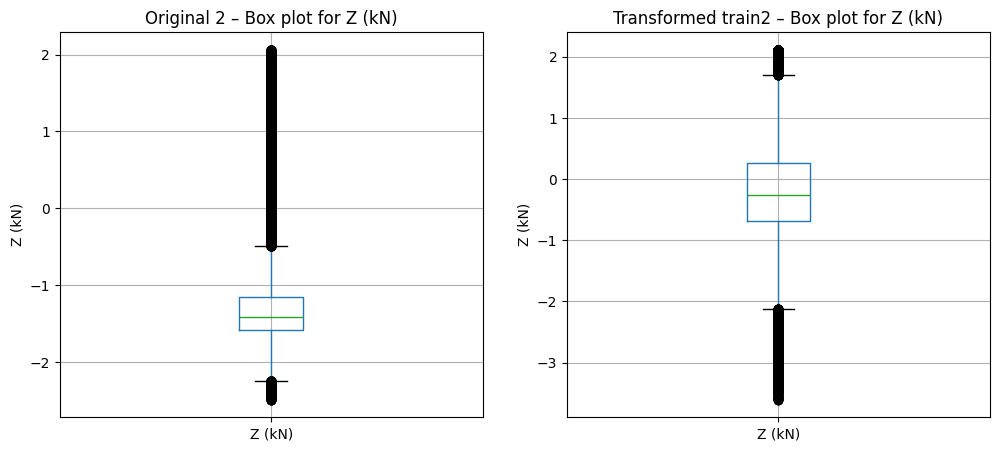

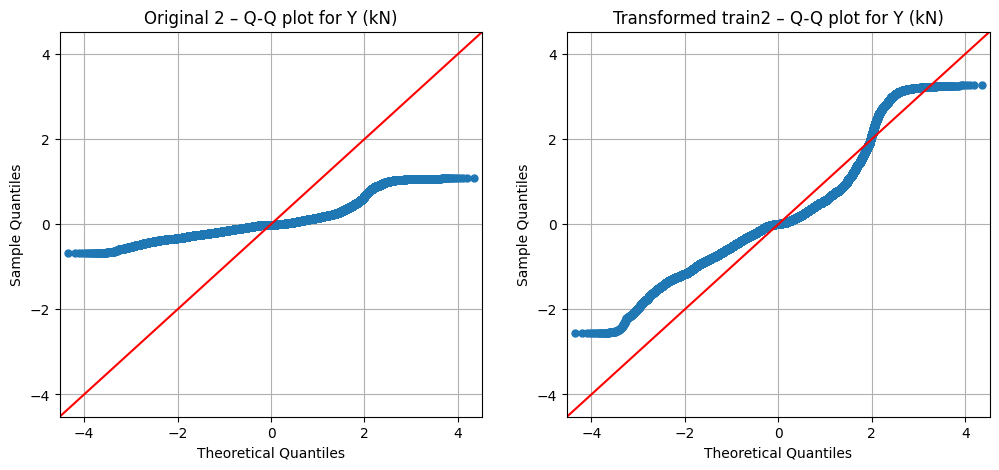

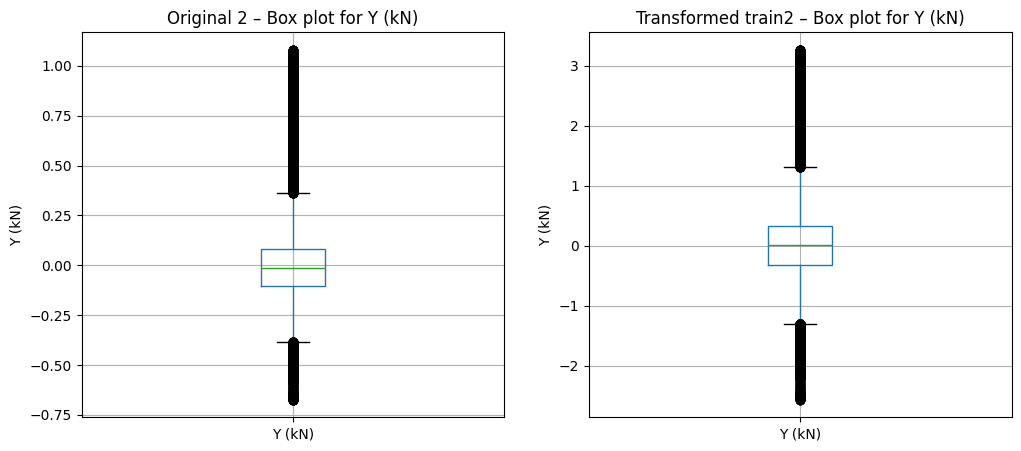

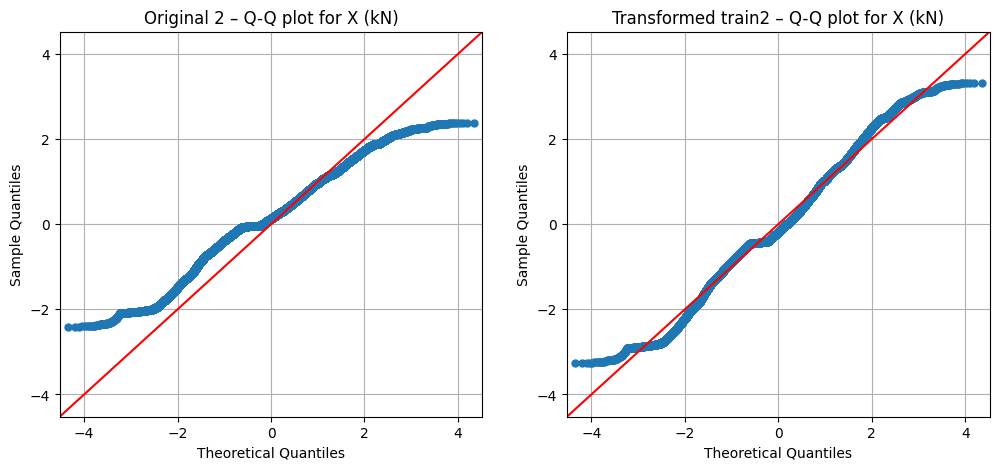

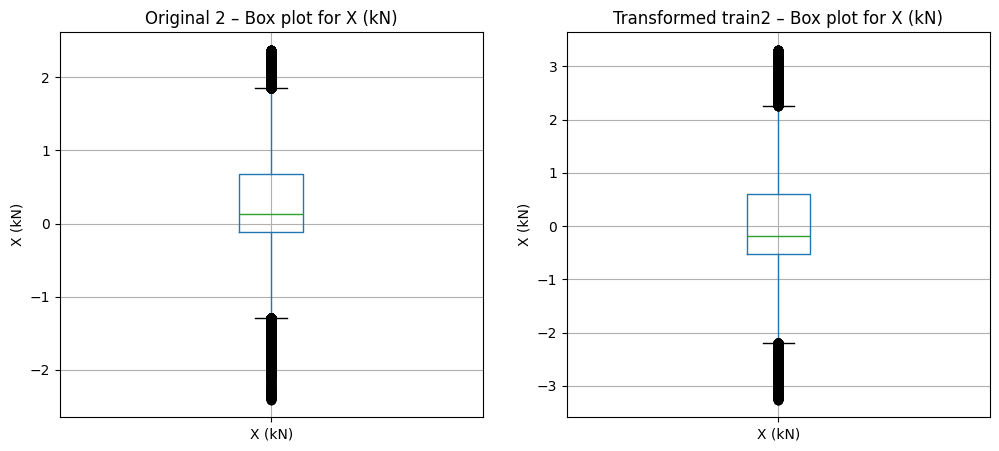

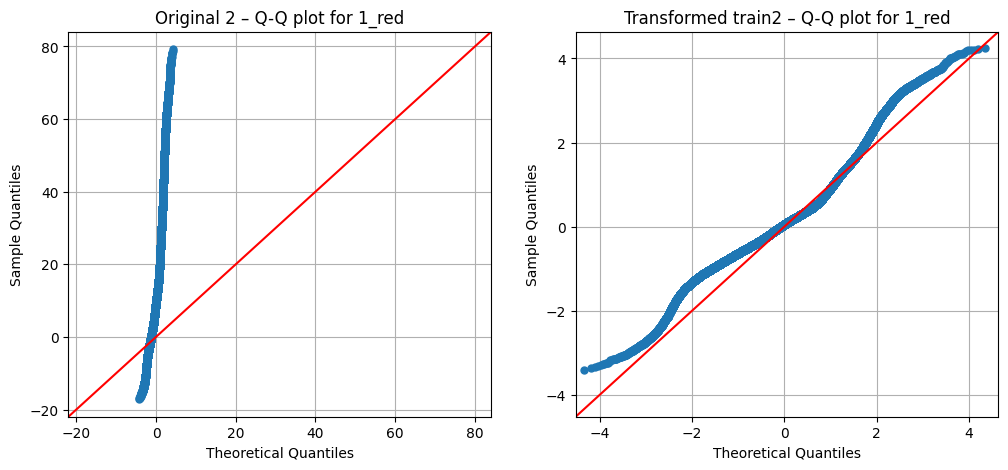

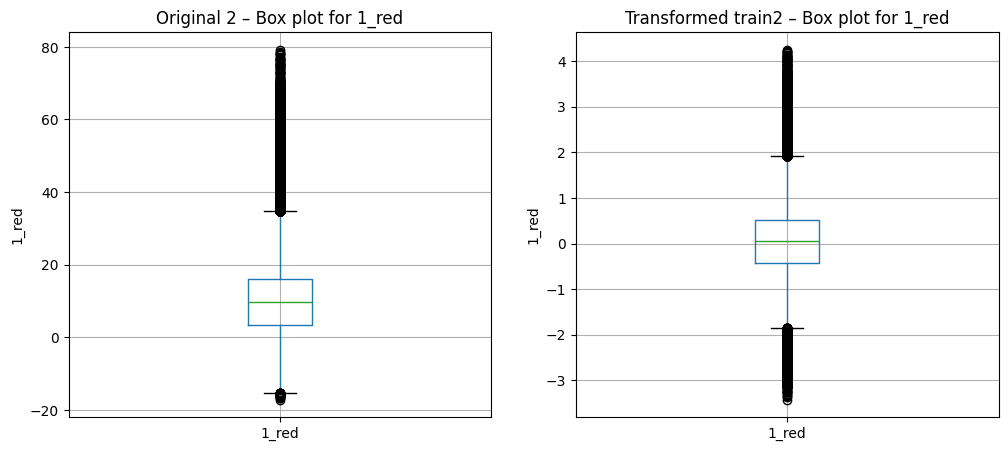

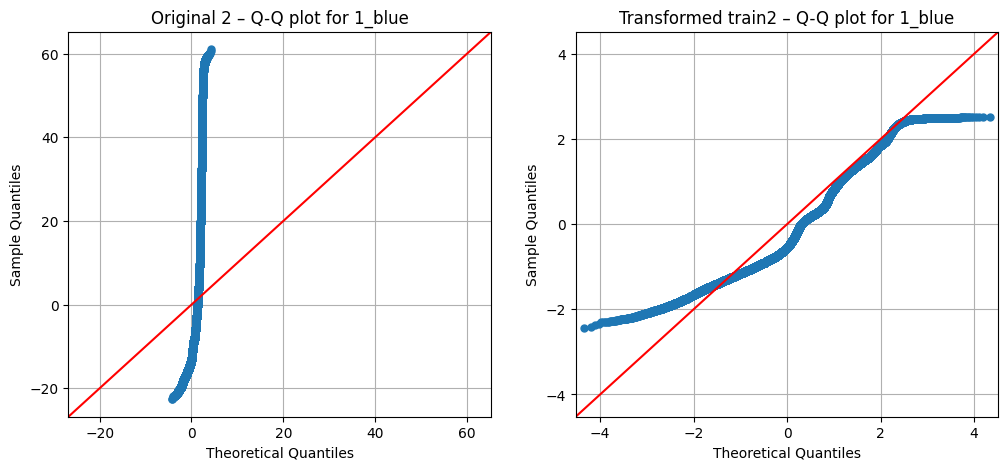

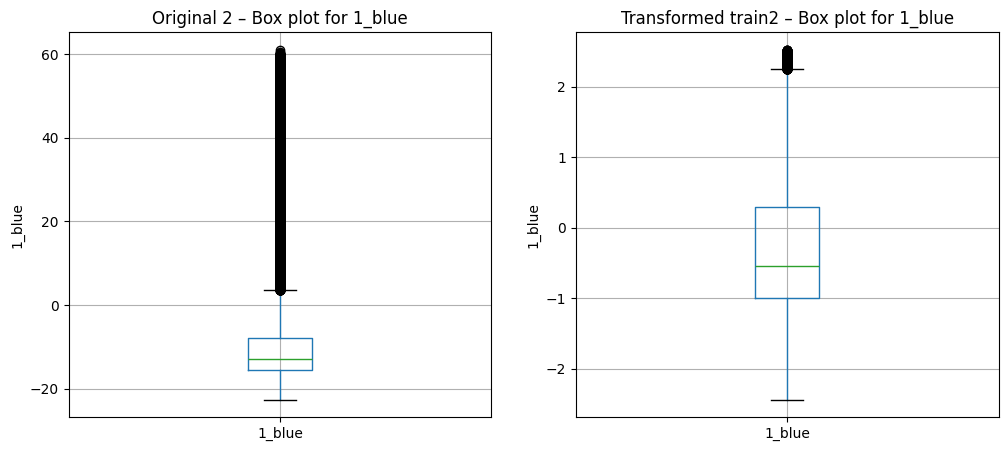

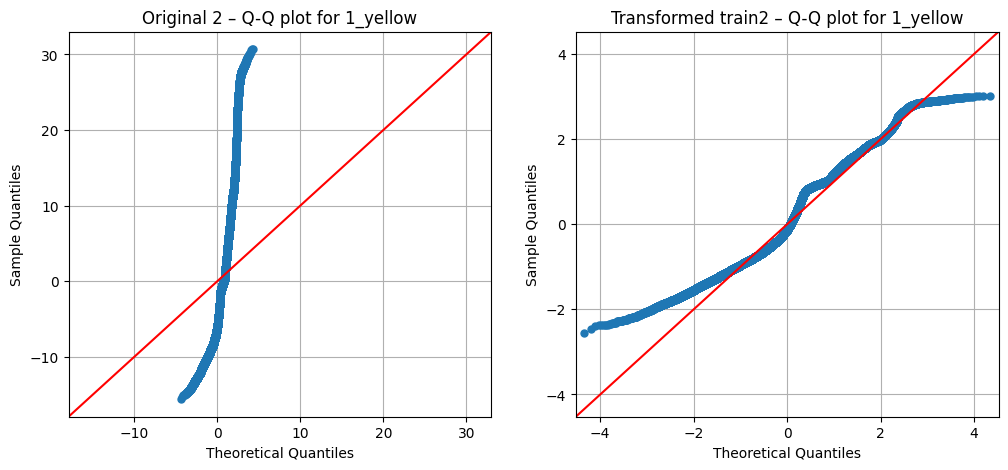

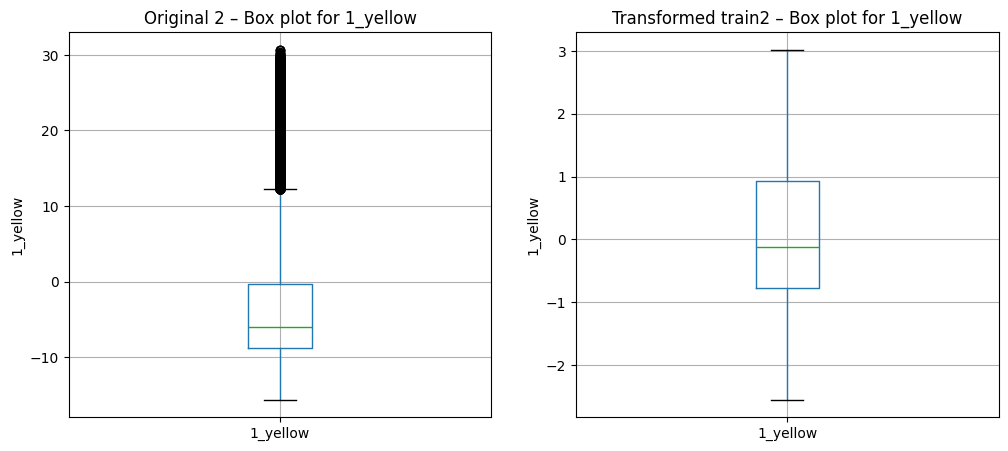

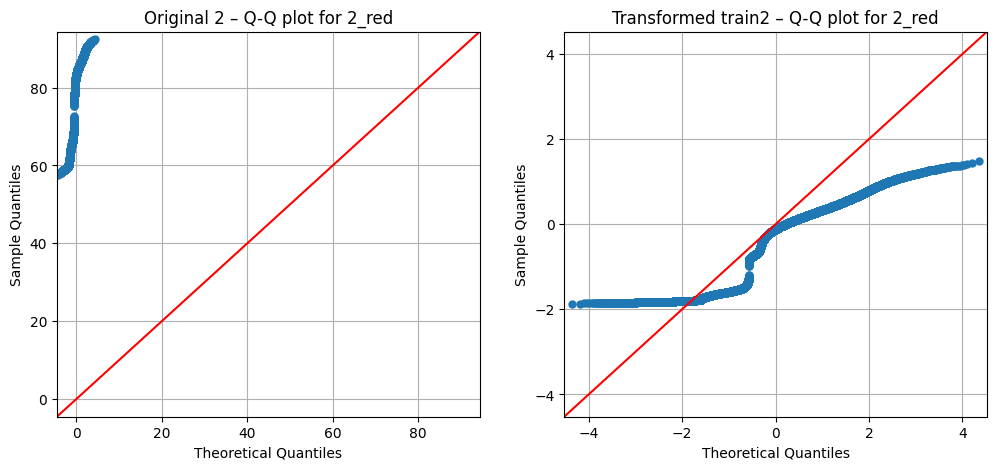

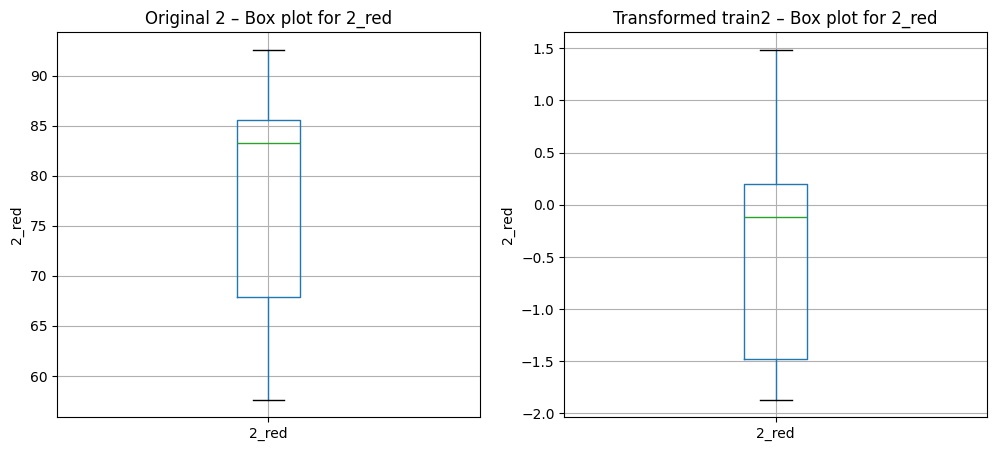

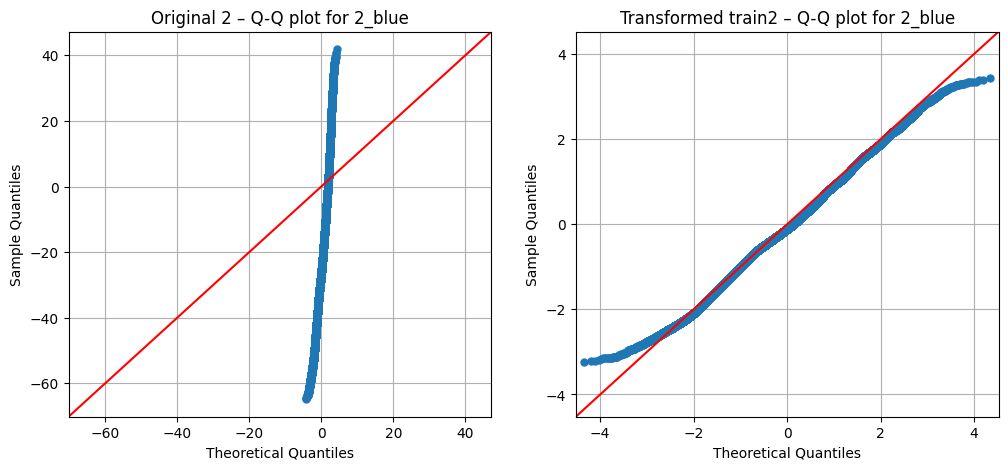

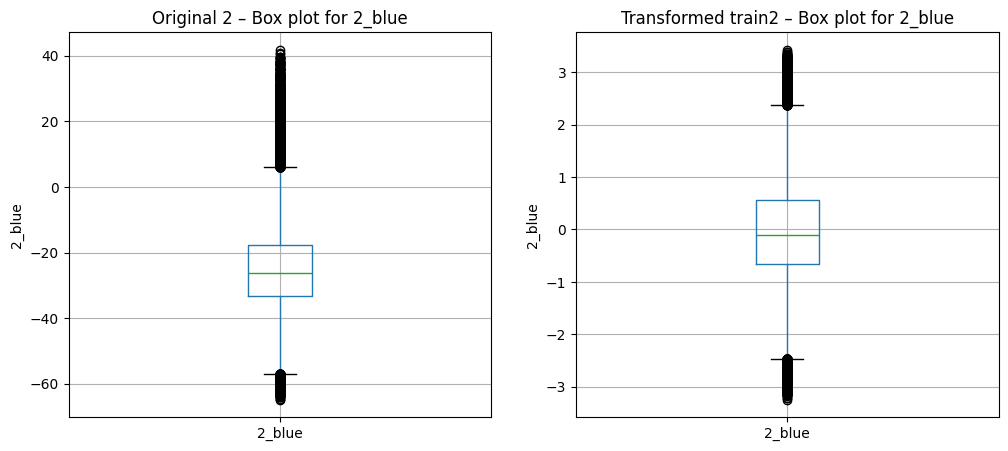

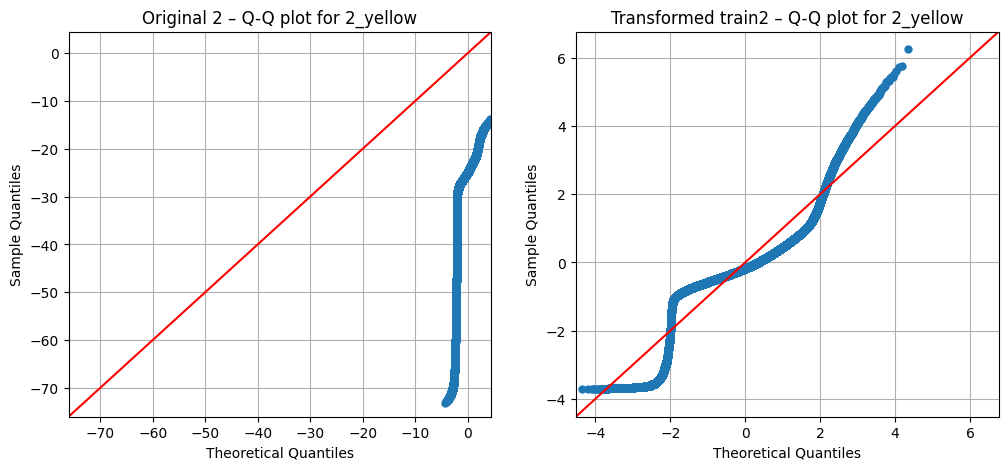

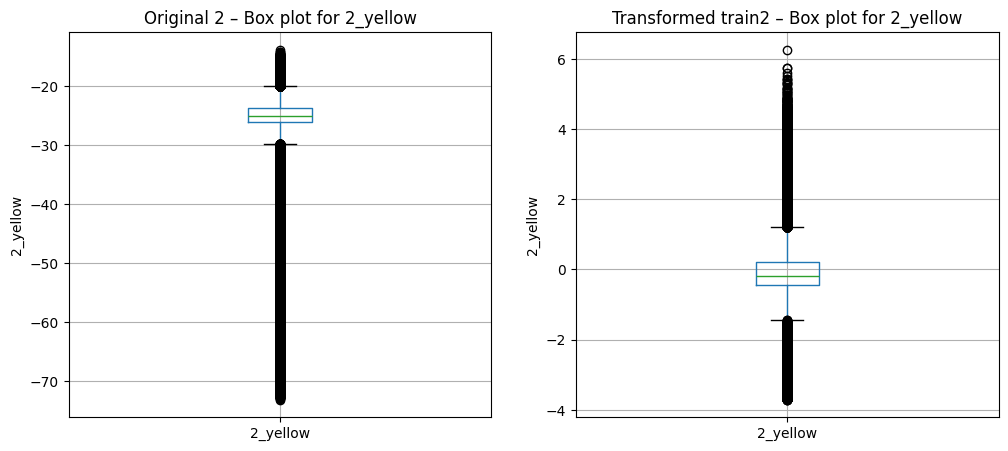

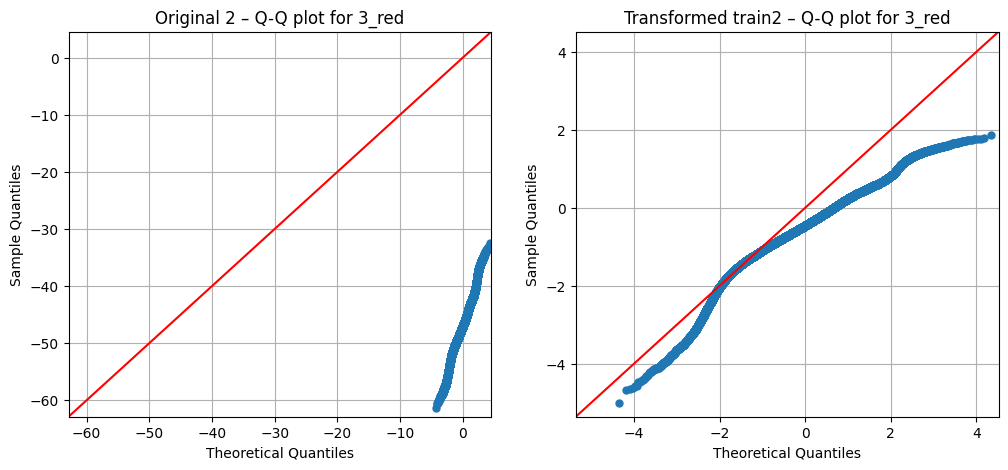

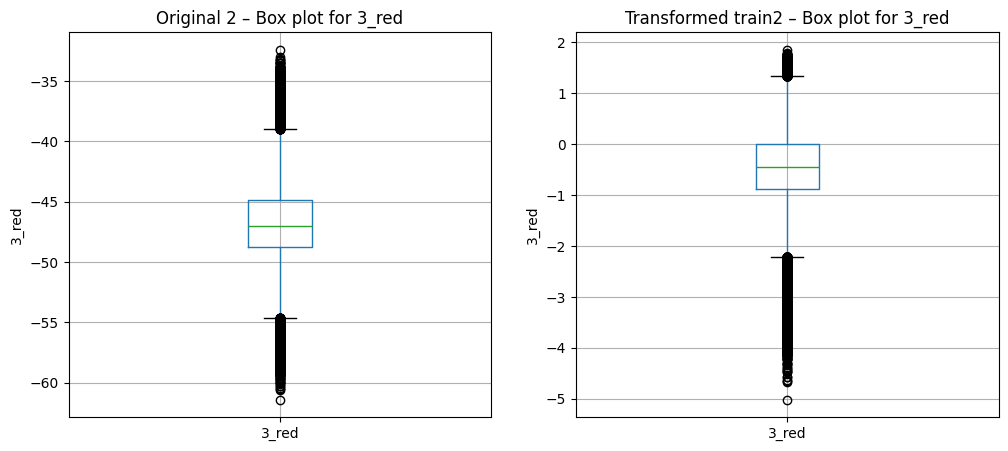

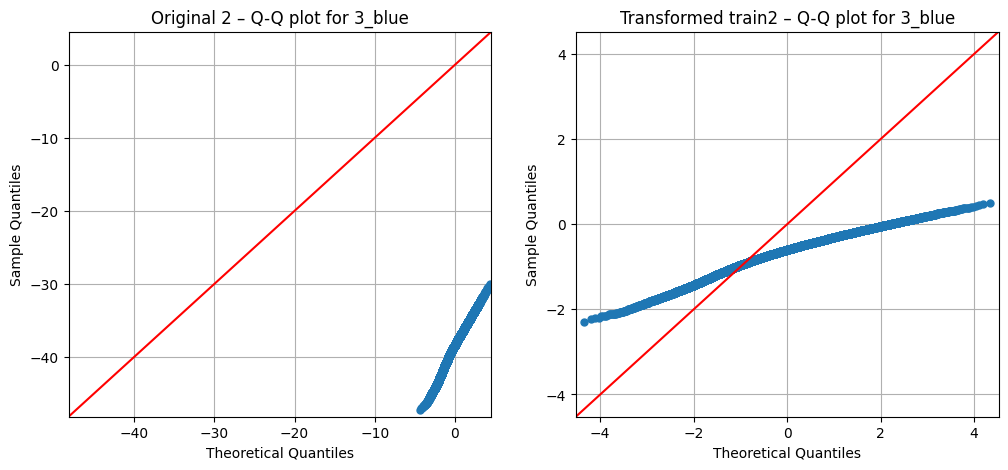

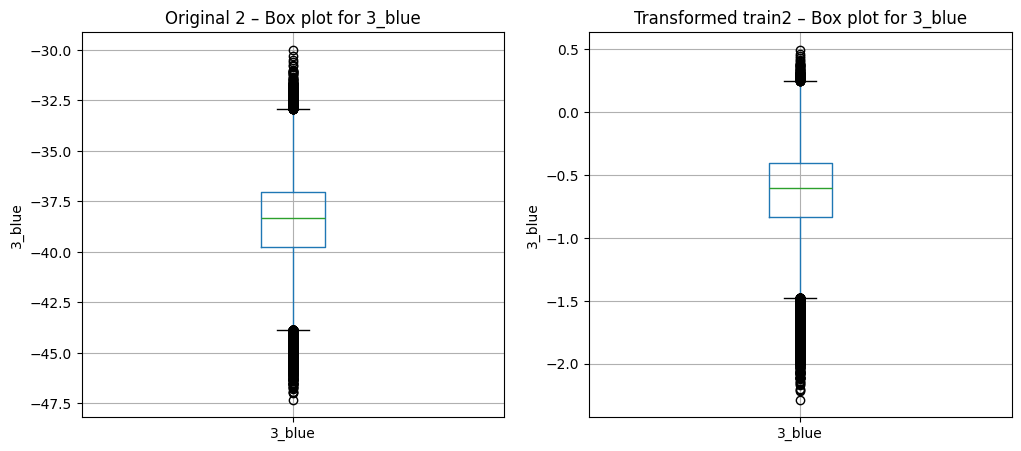

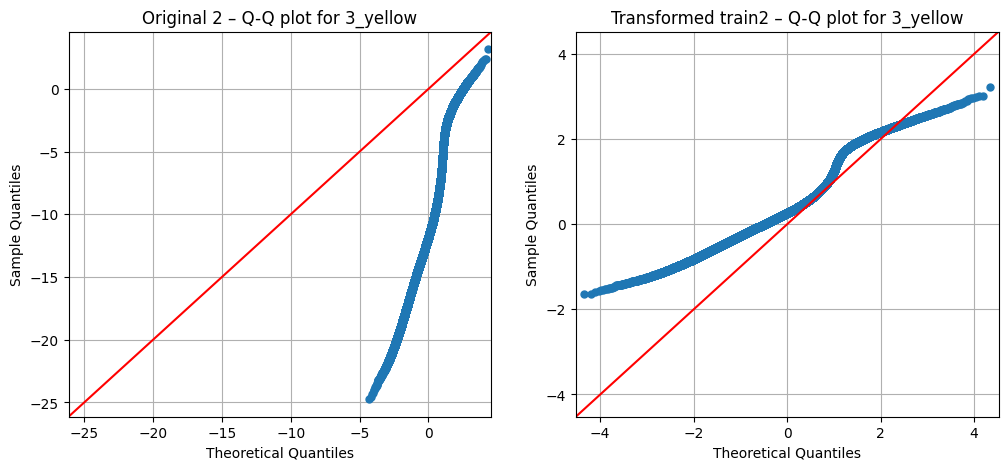

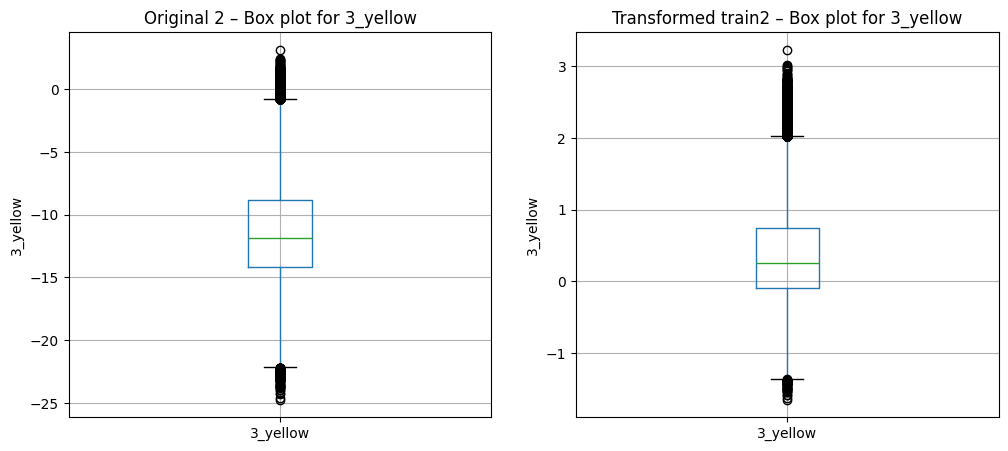

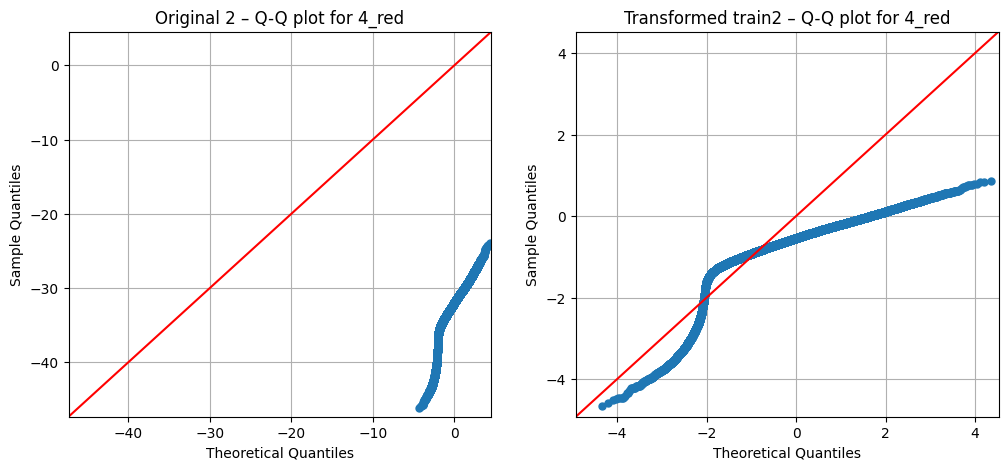

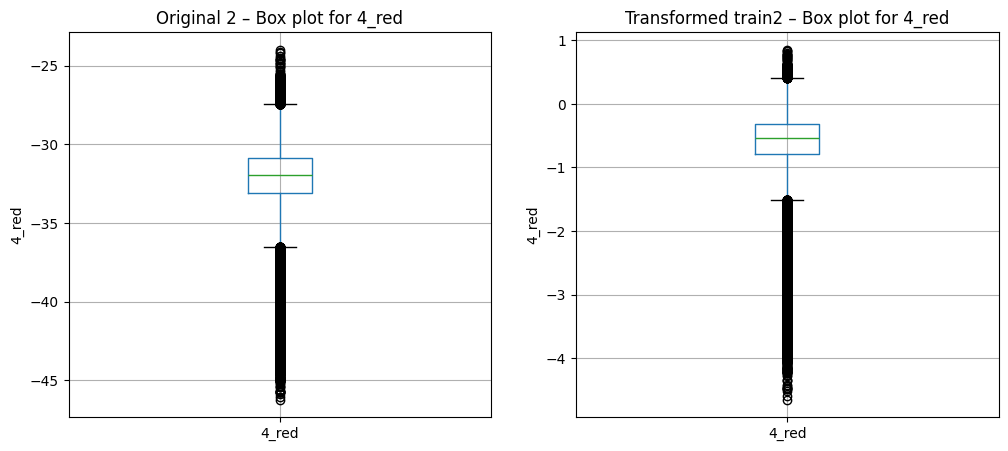

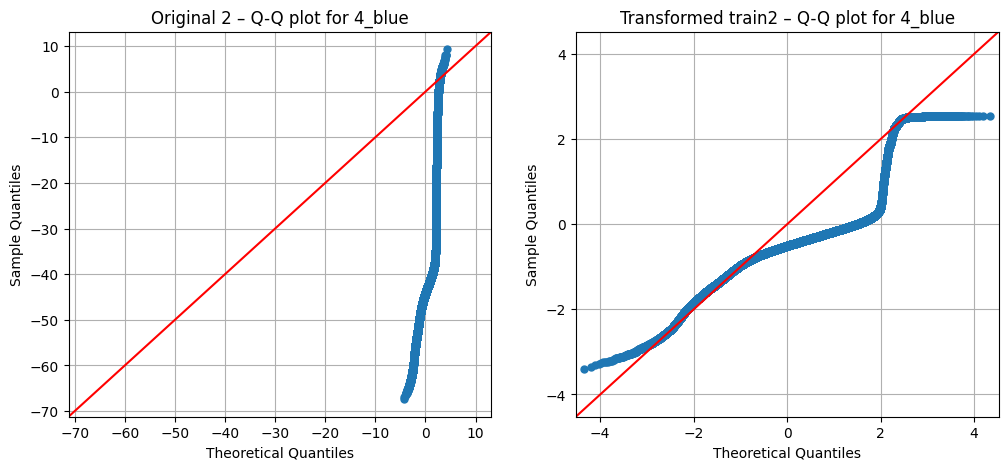

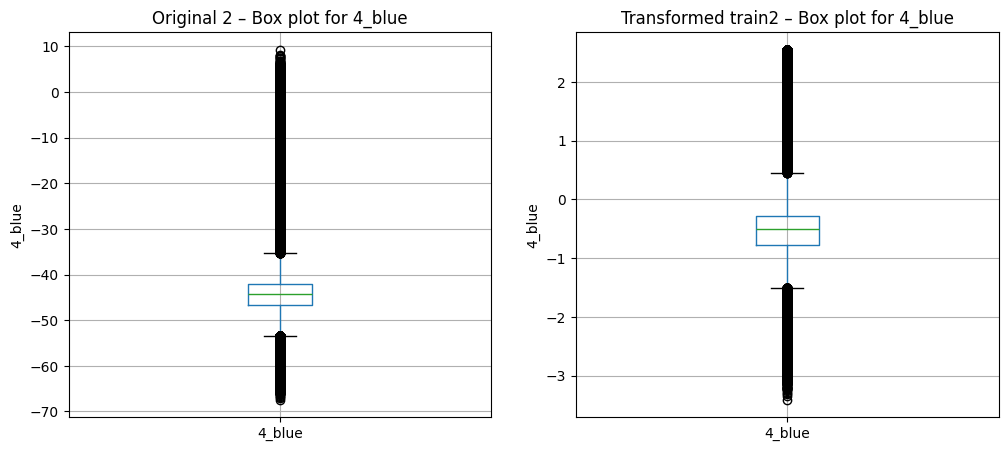

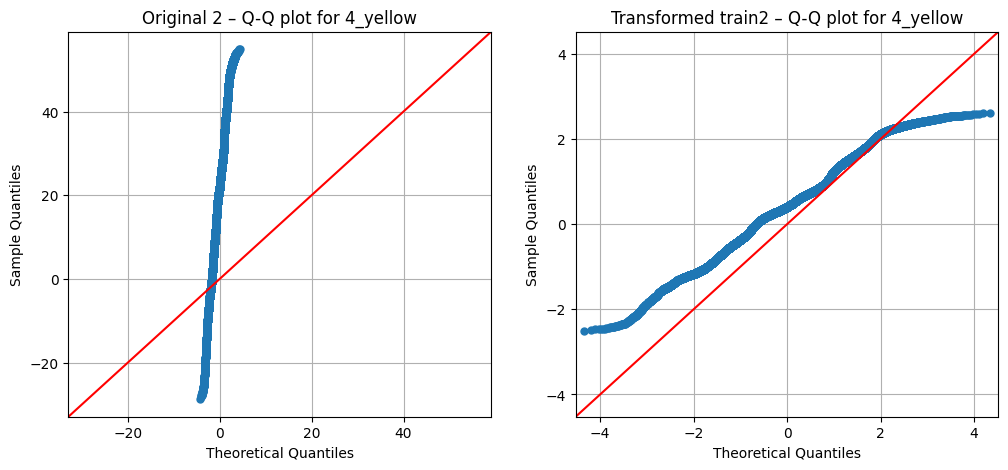

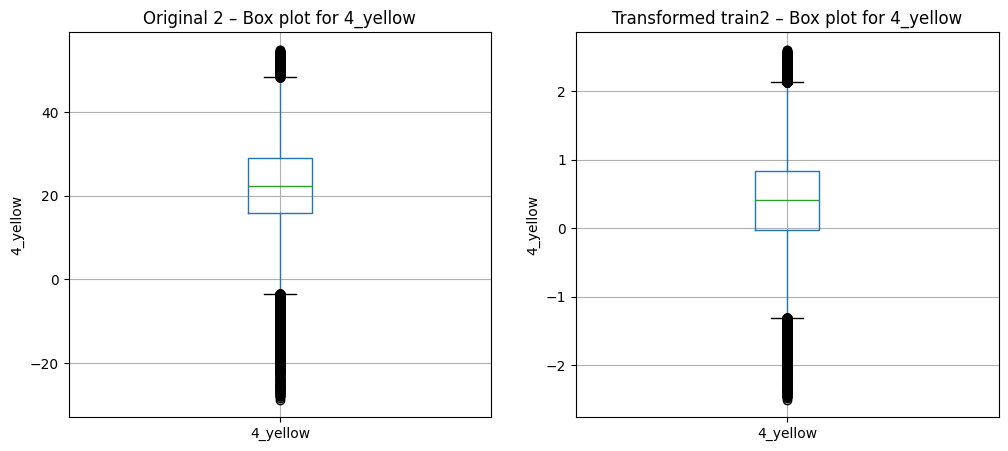

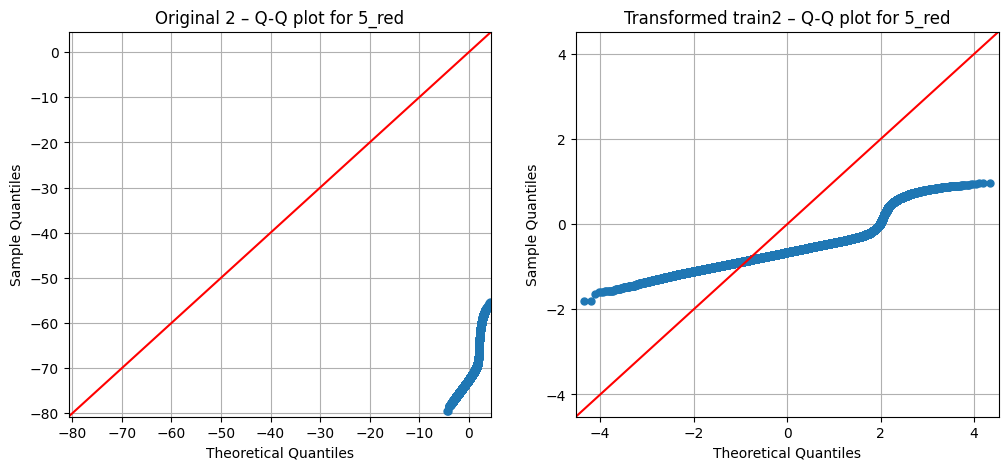

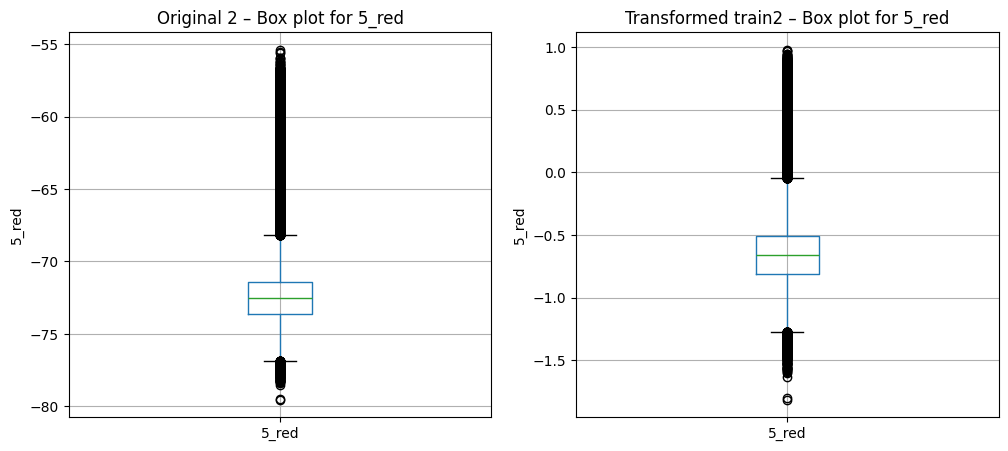

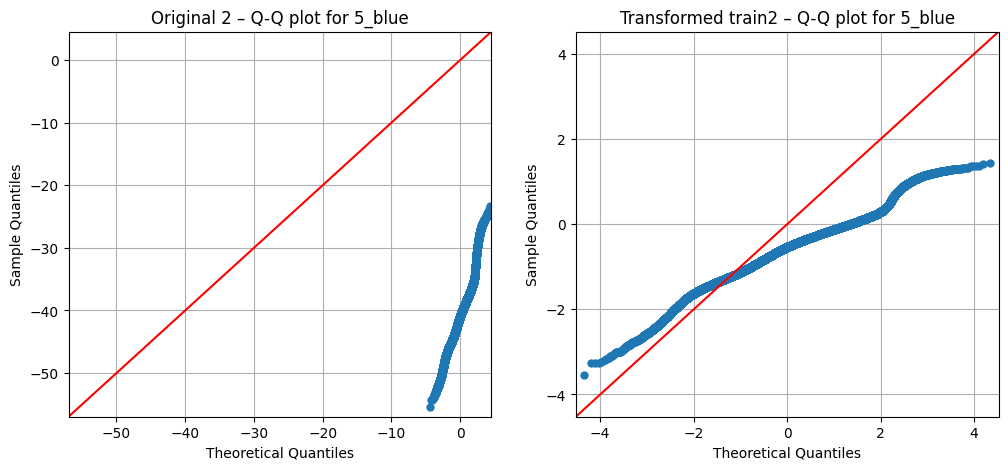

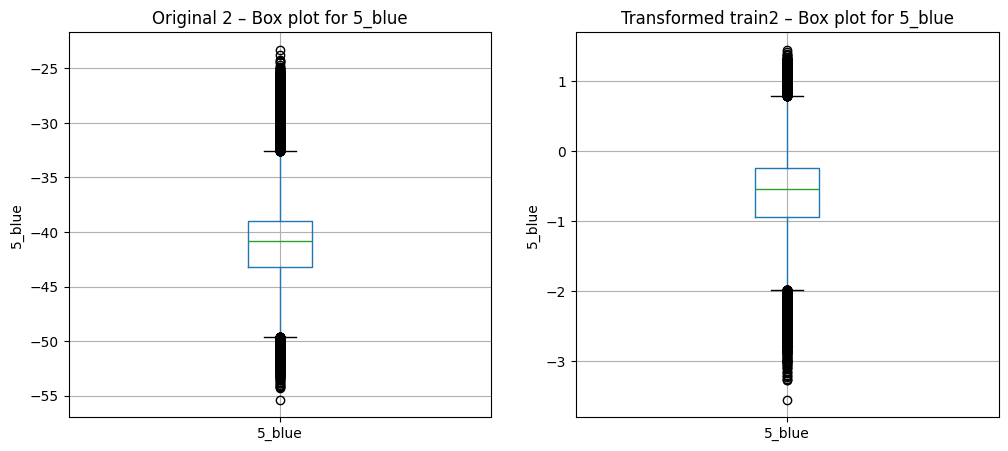

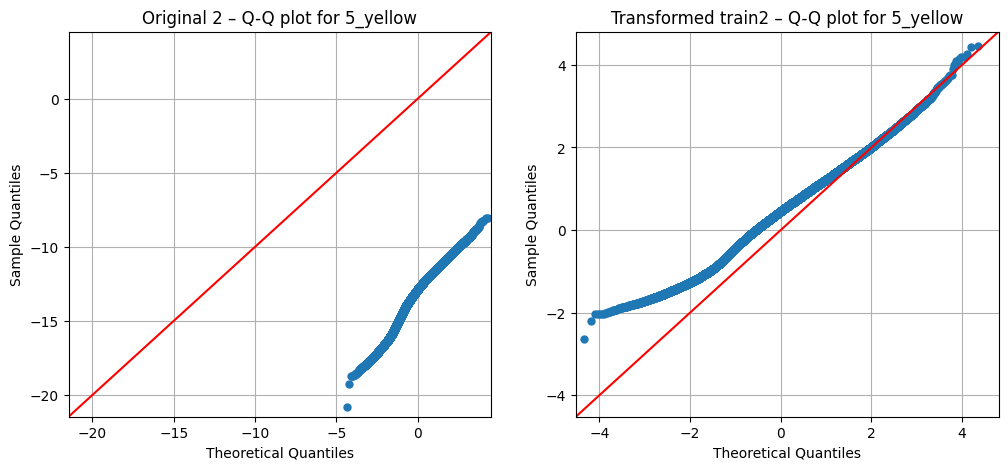

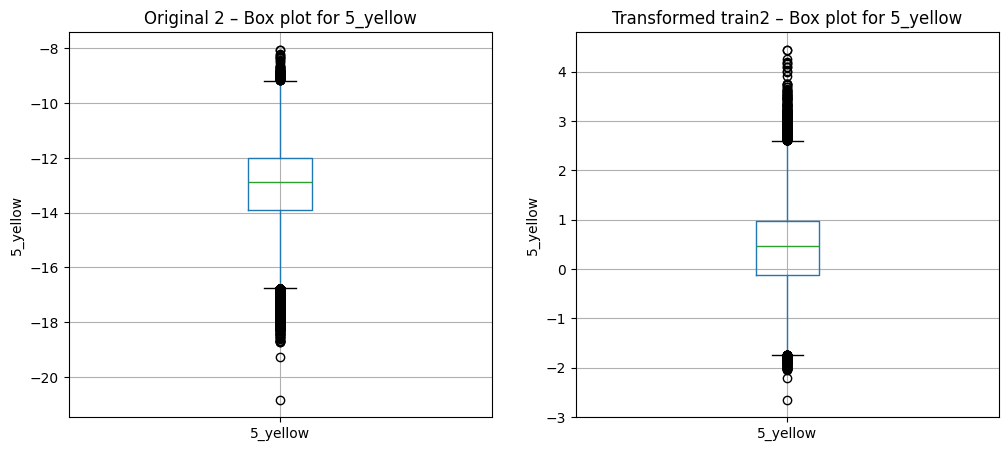

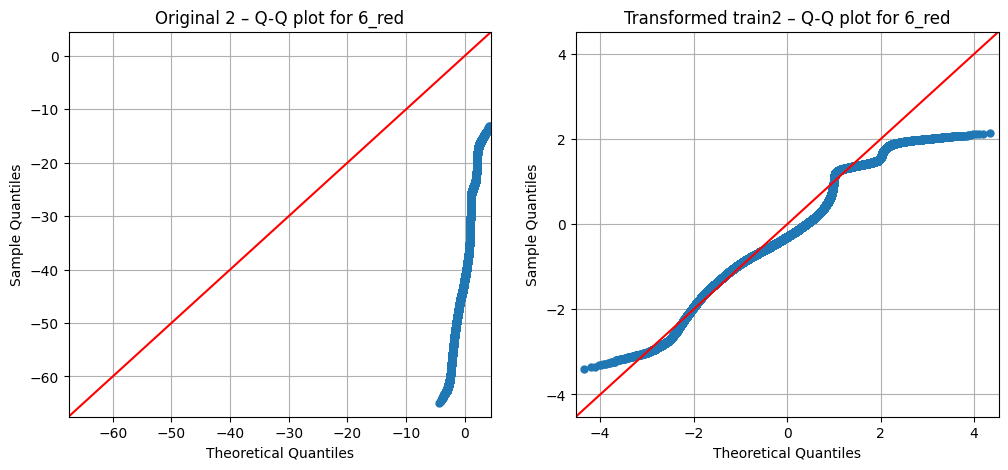

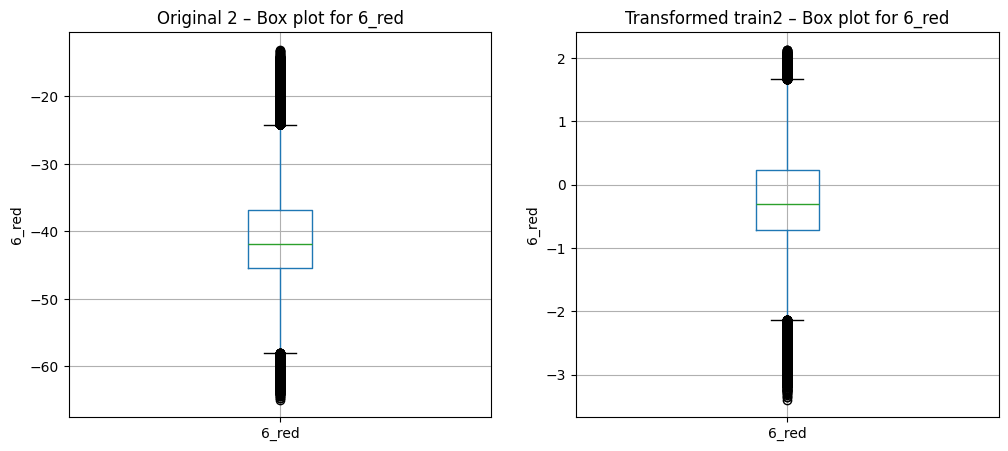

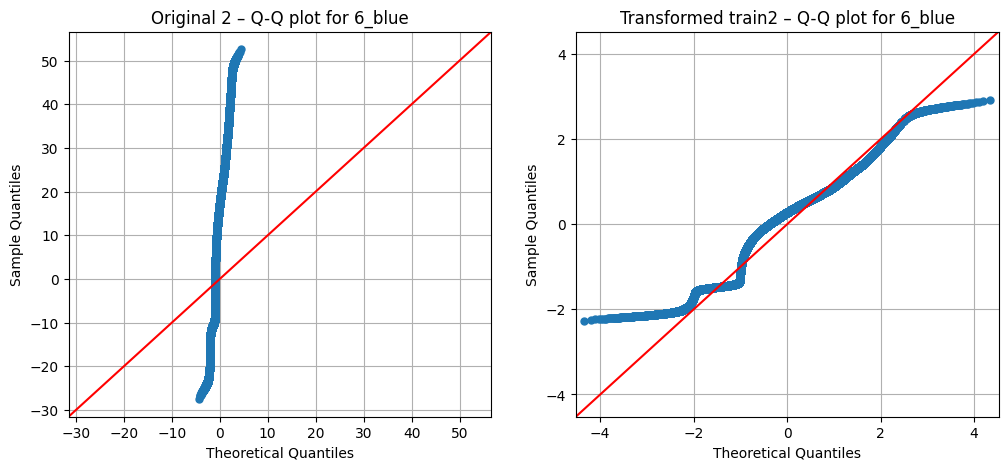

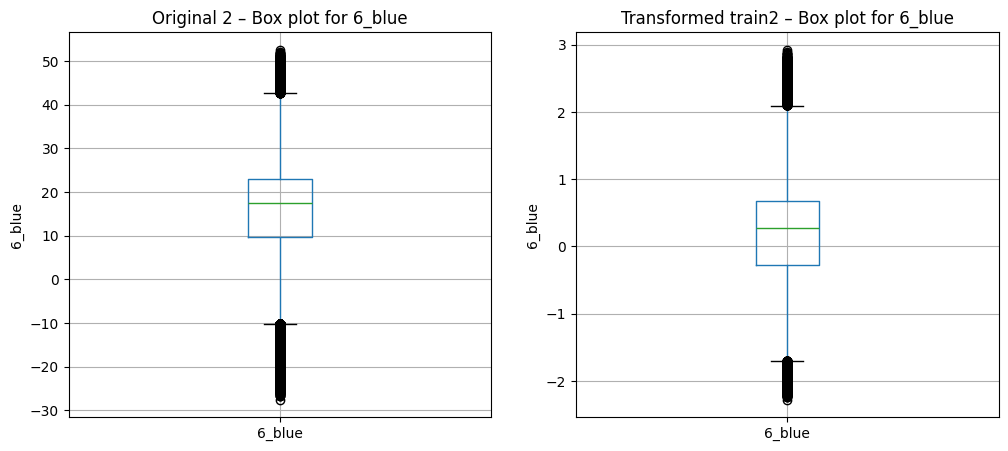

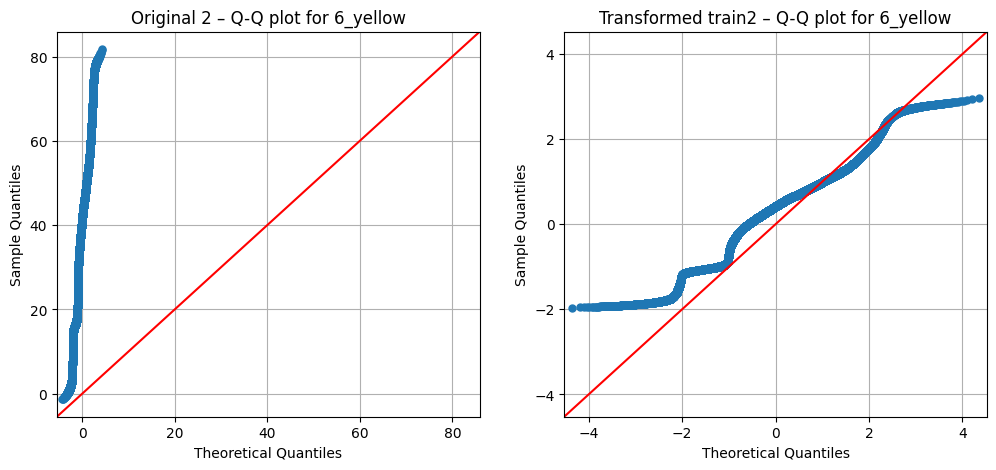

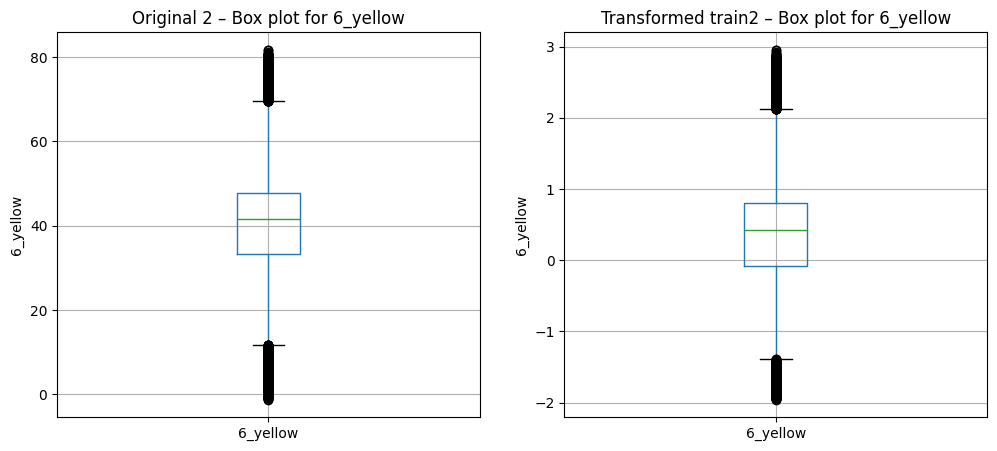

Processing DataFrame for original key 3 and transformed key val.


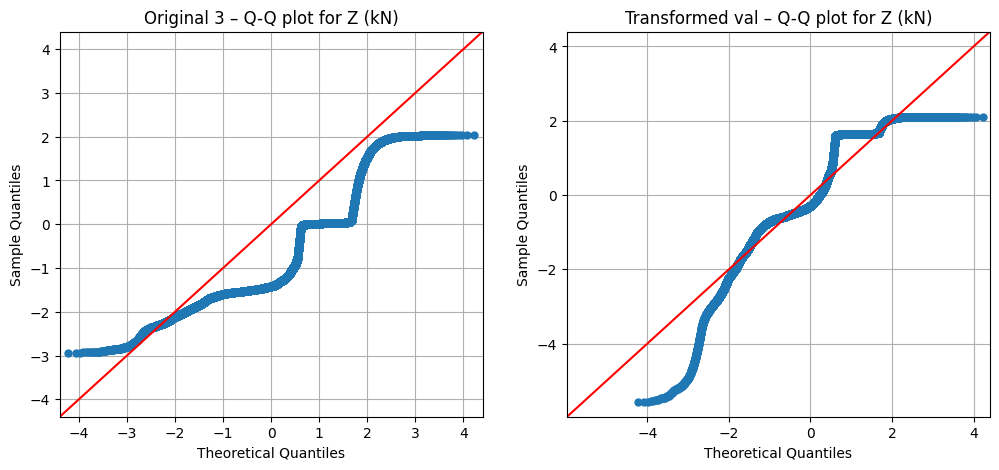

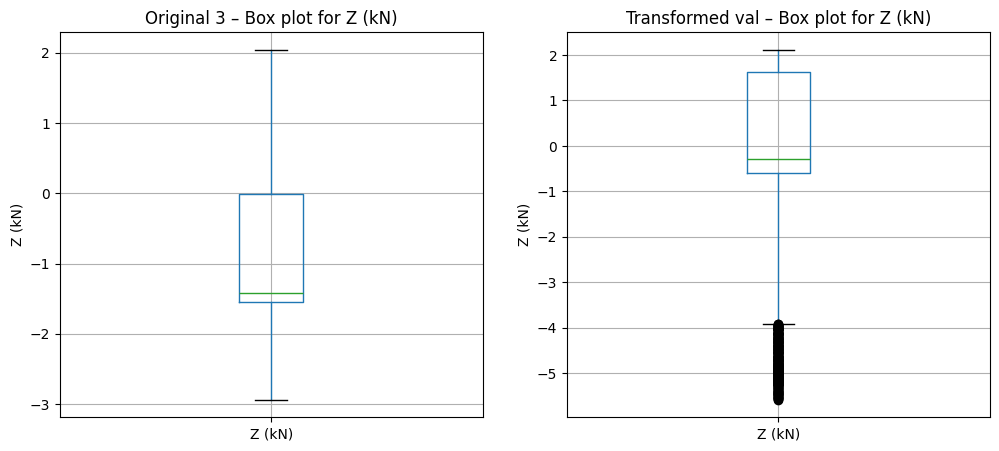

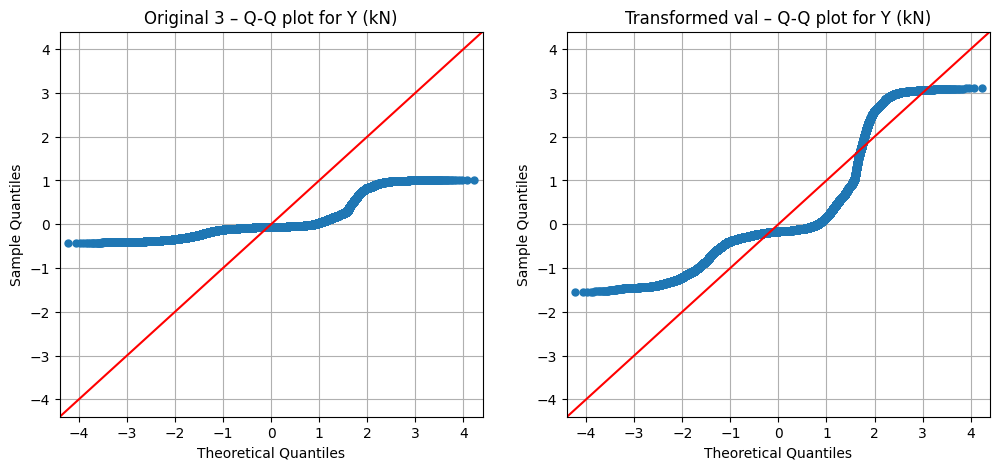

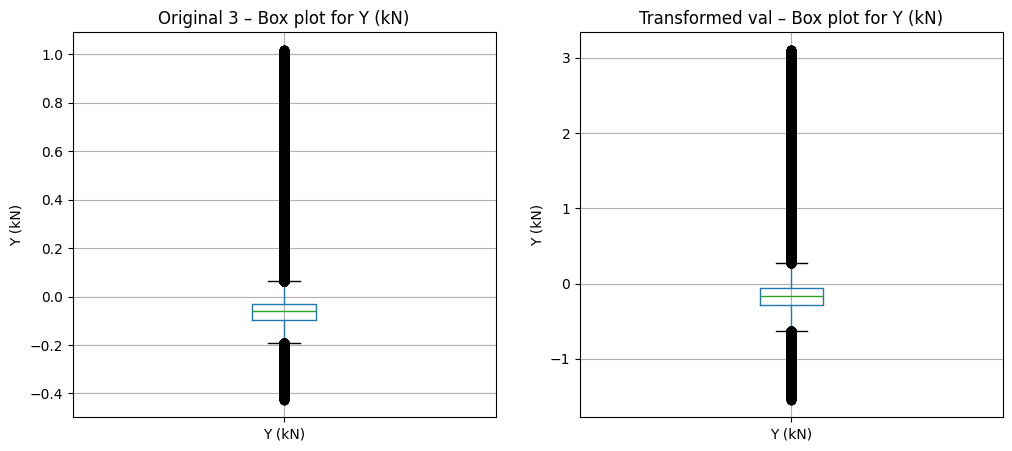

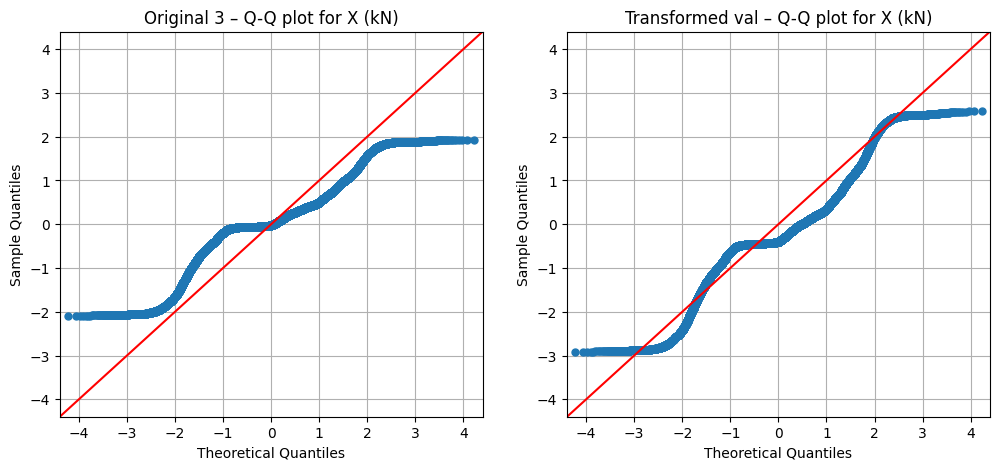

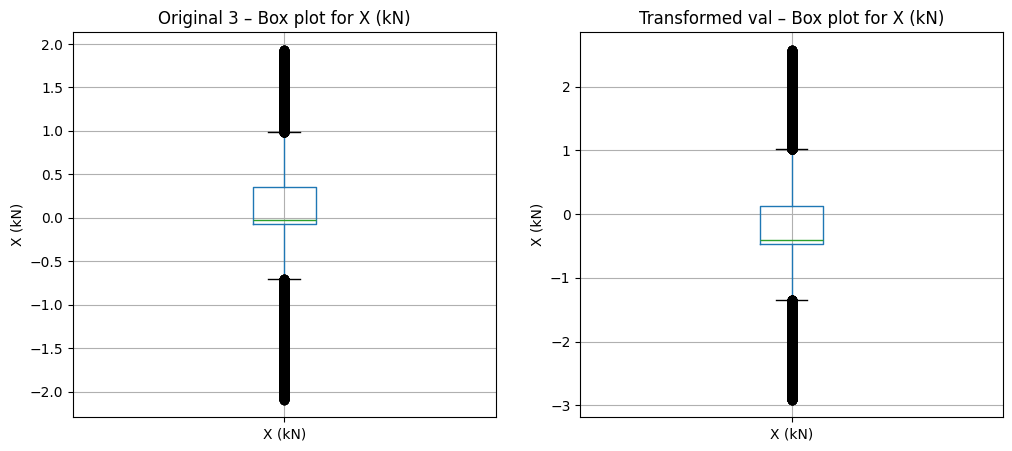

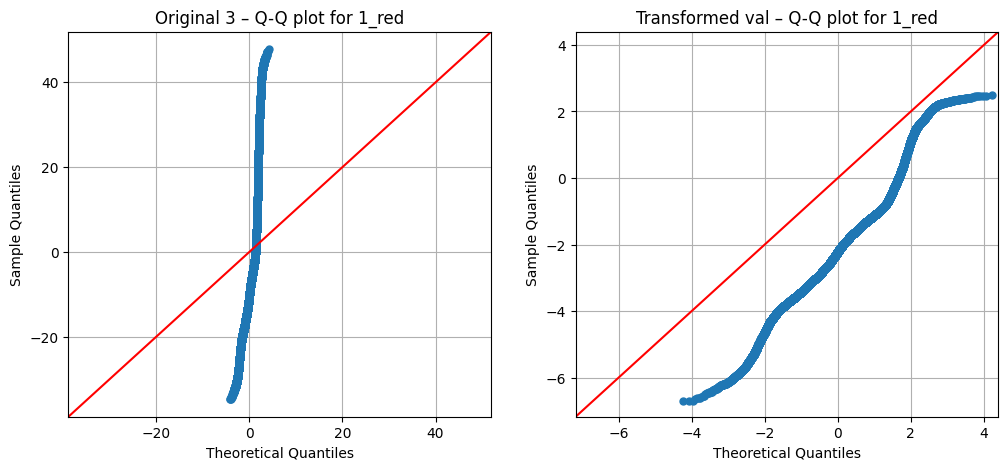

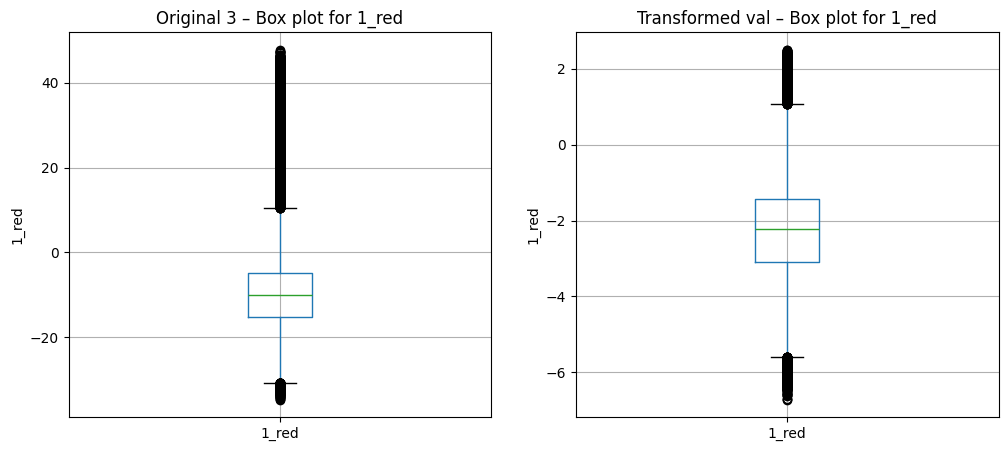

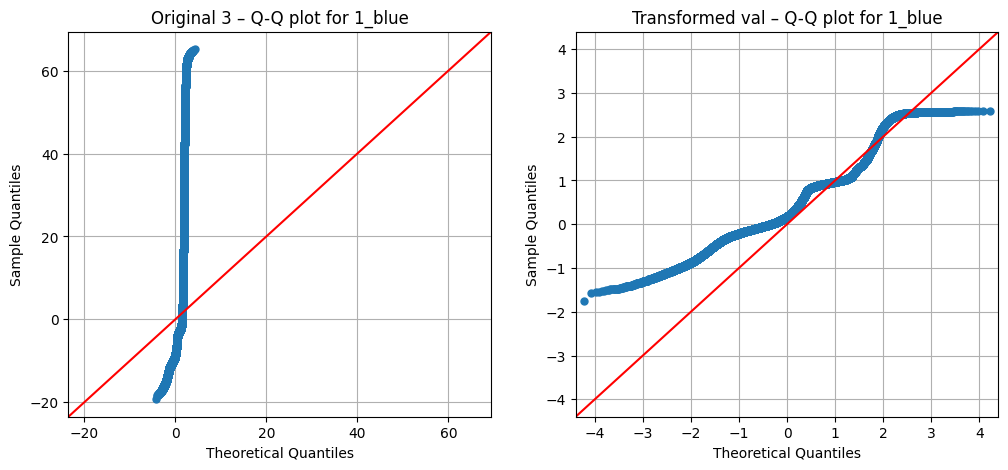

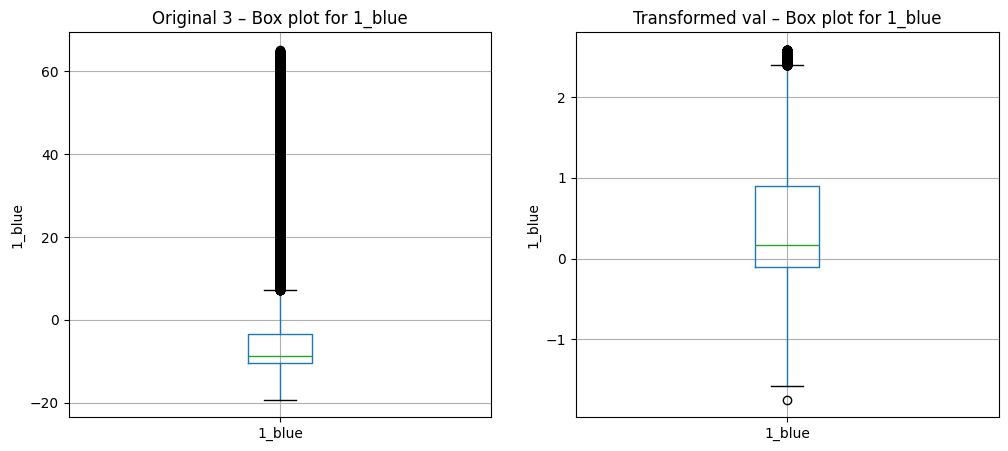

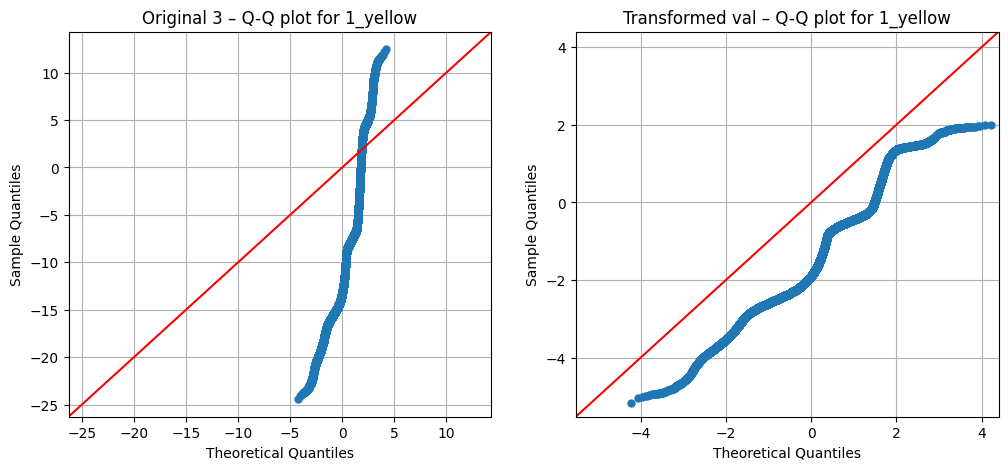

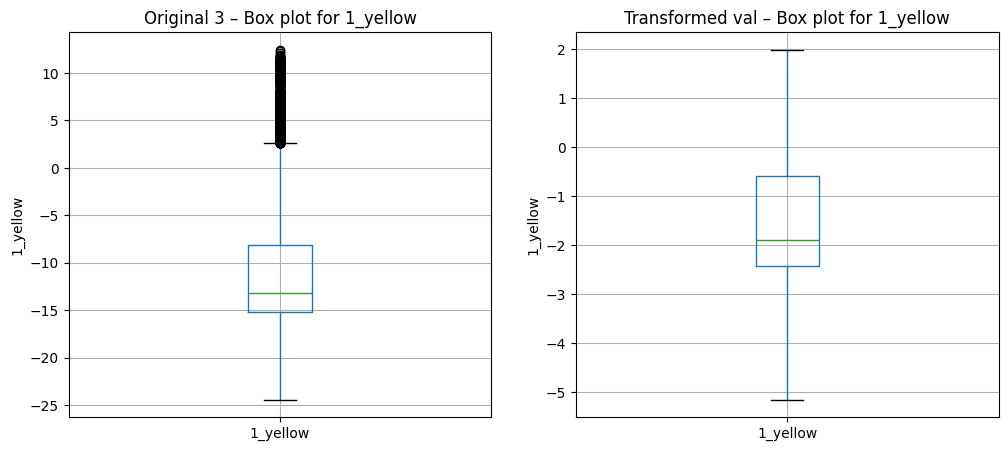

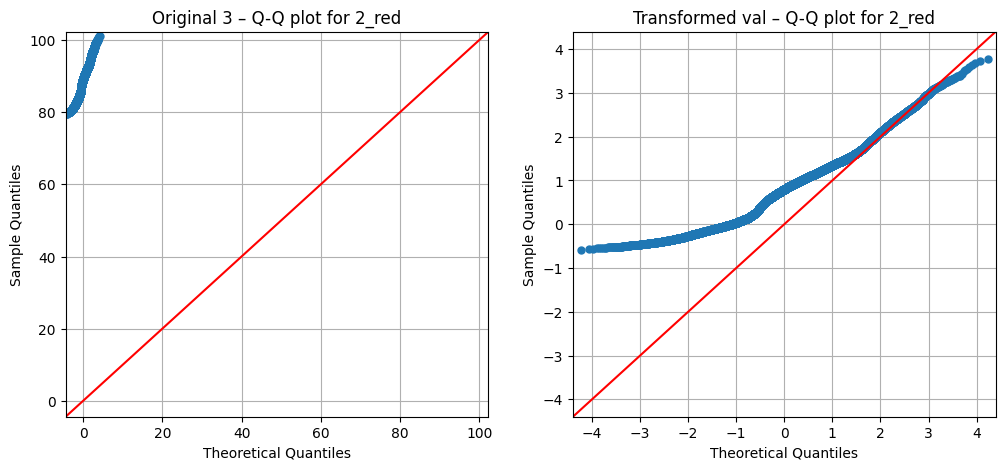

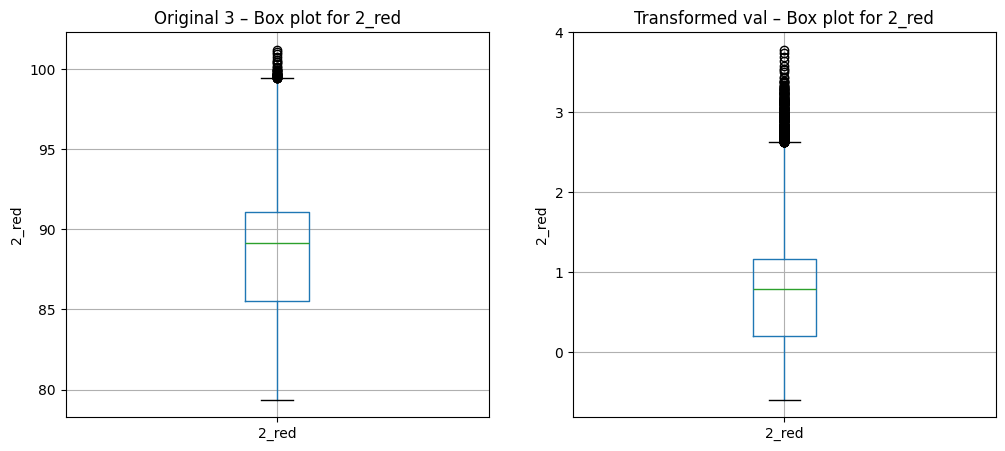

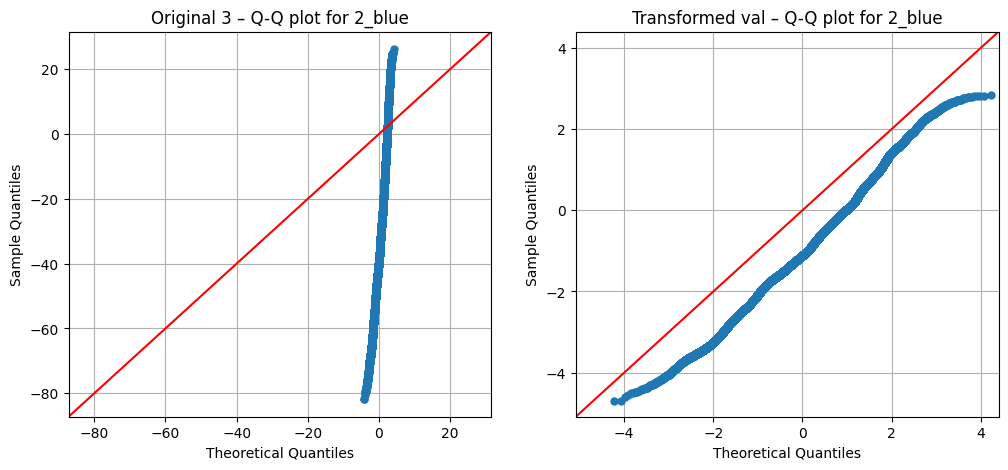

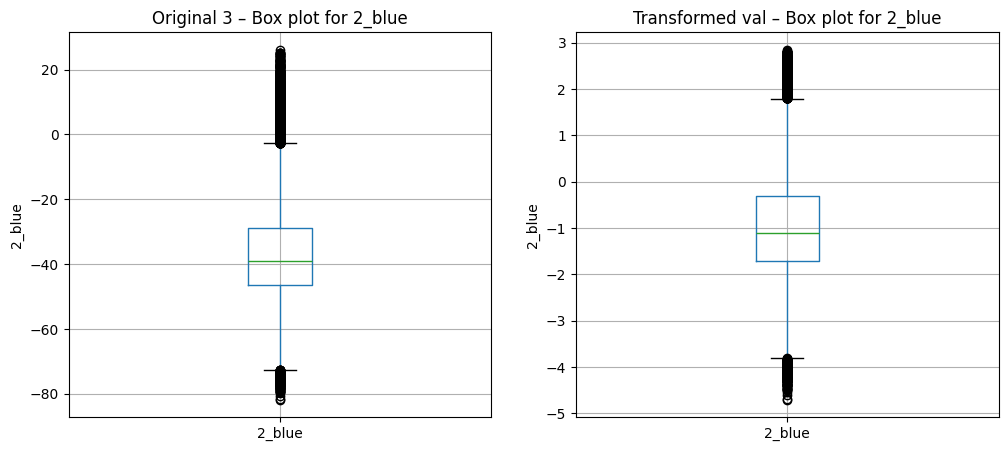

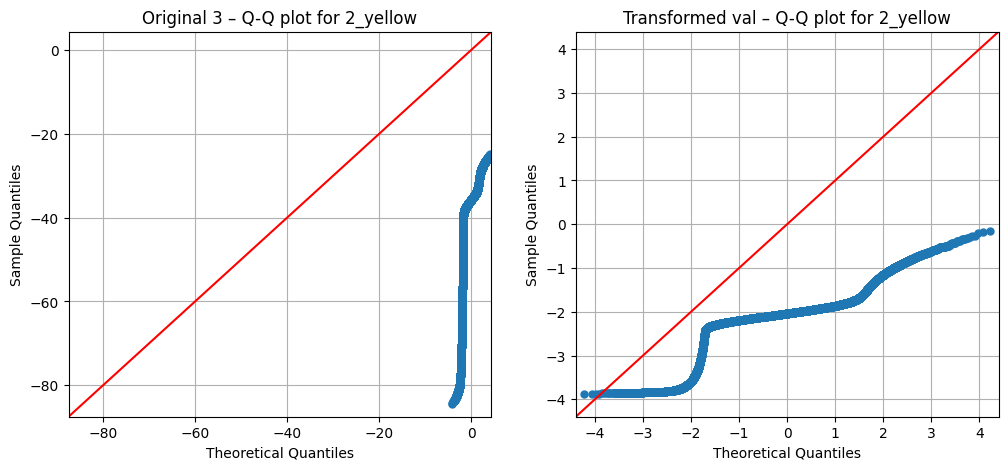

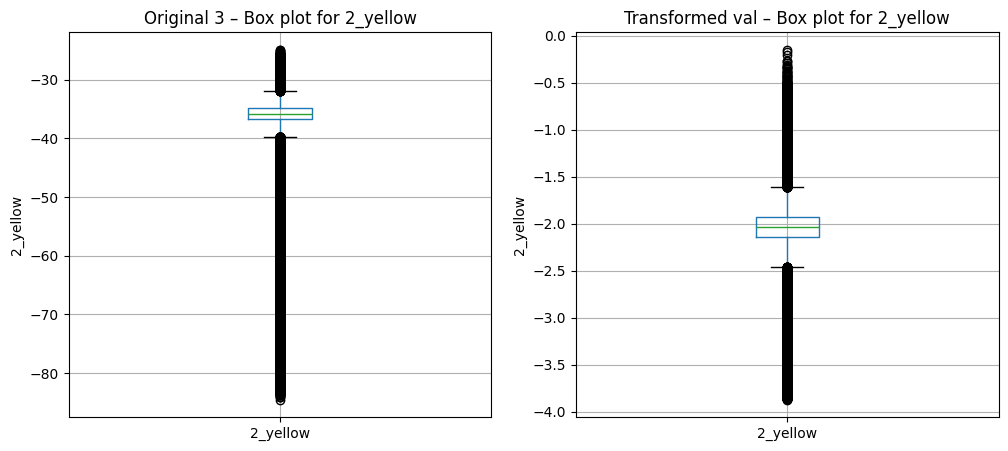

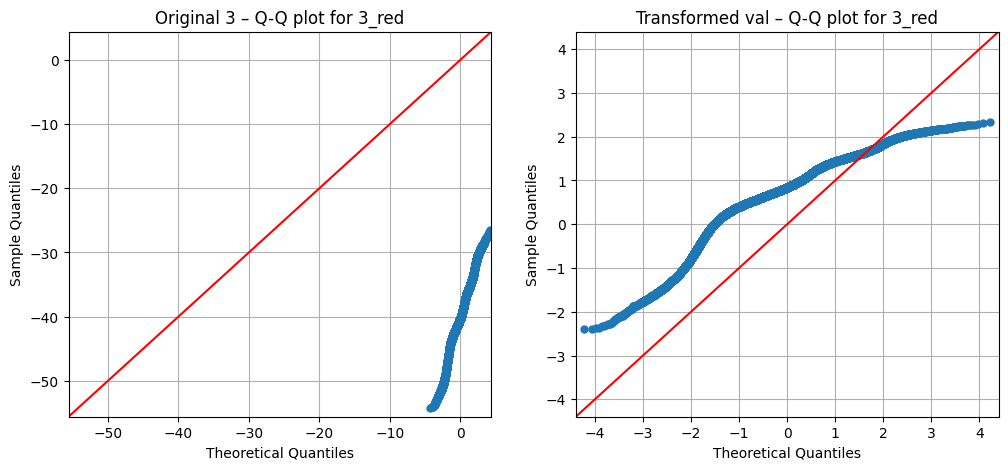

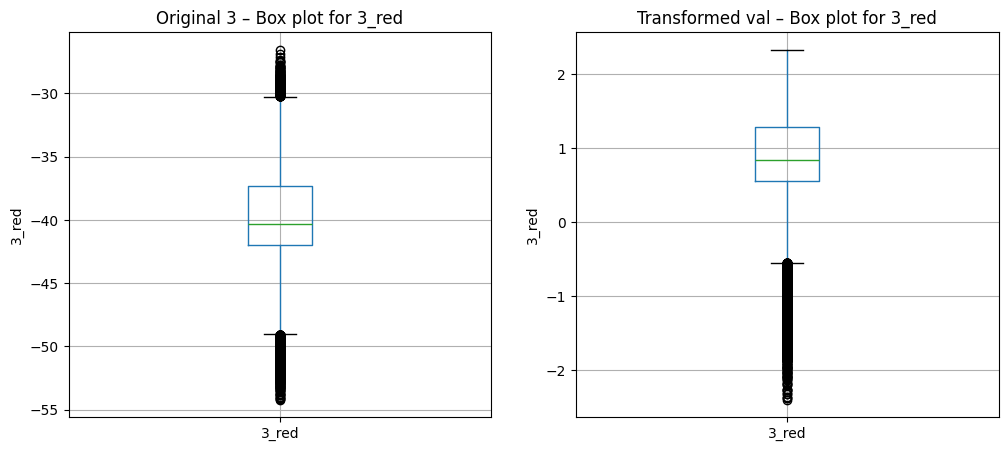

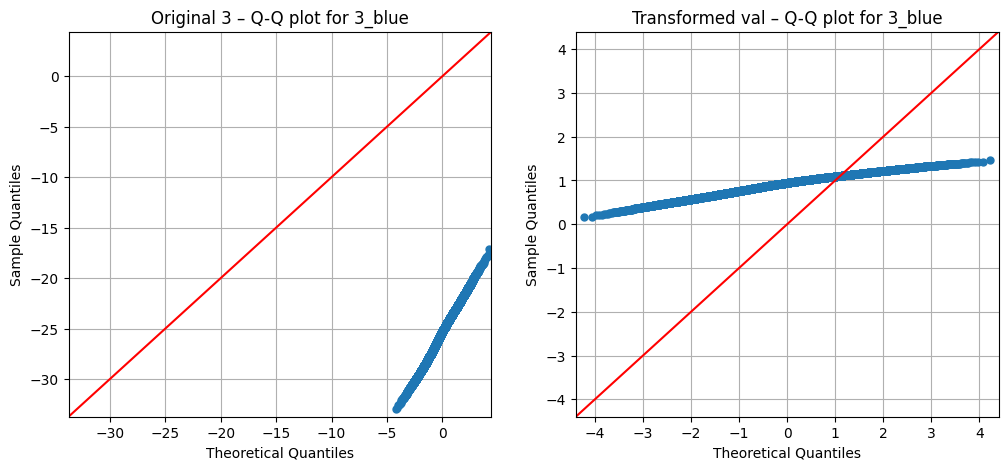

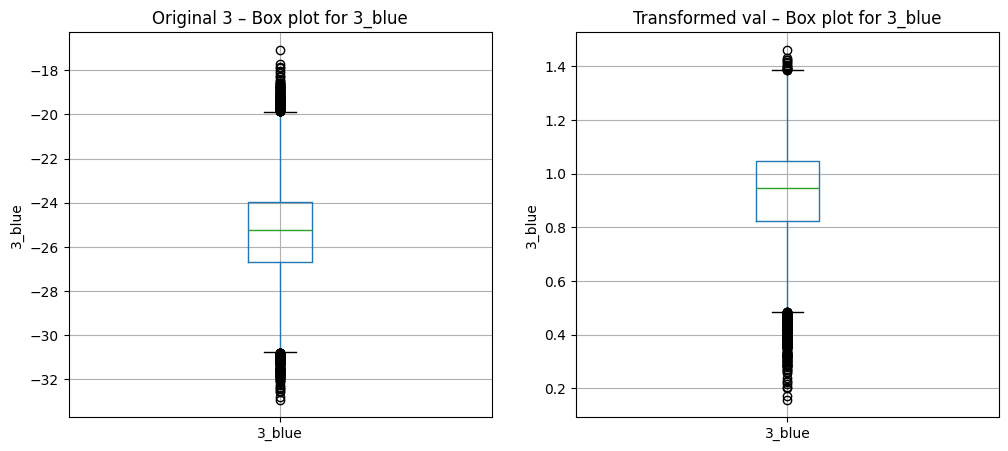

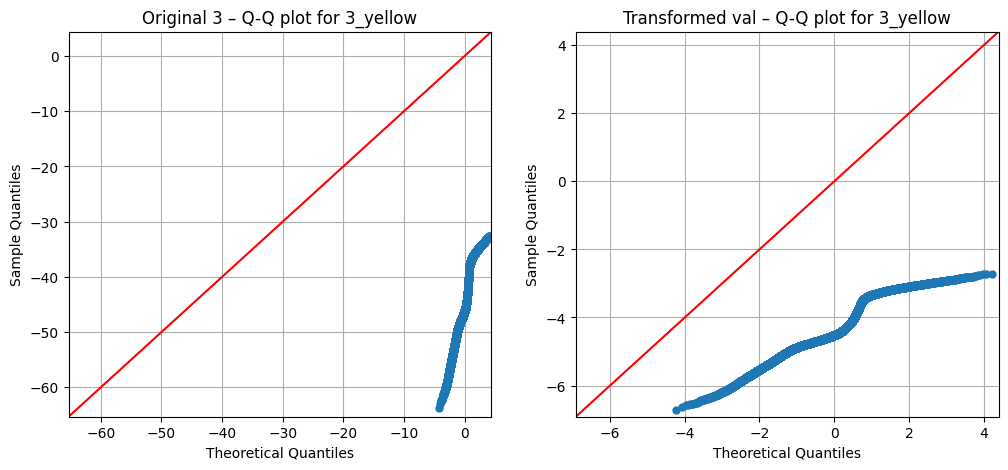

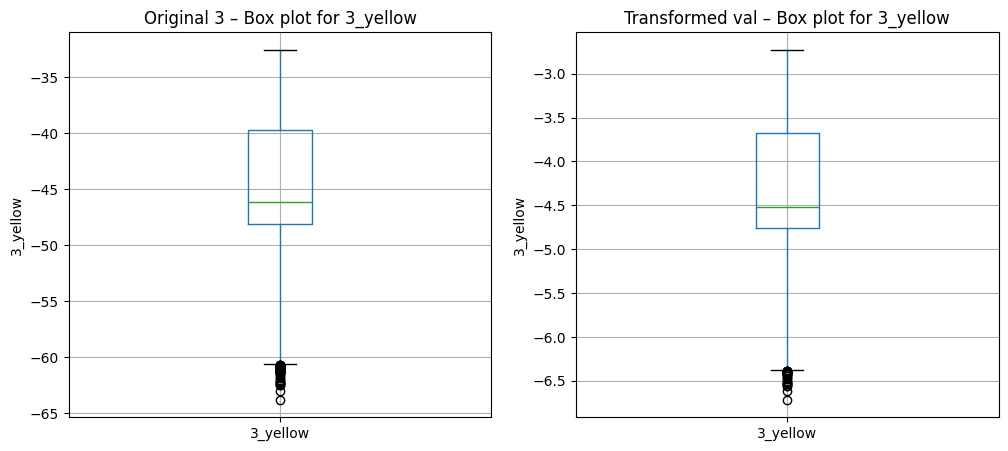

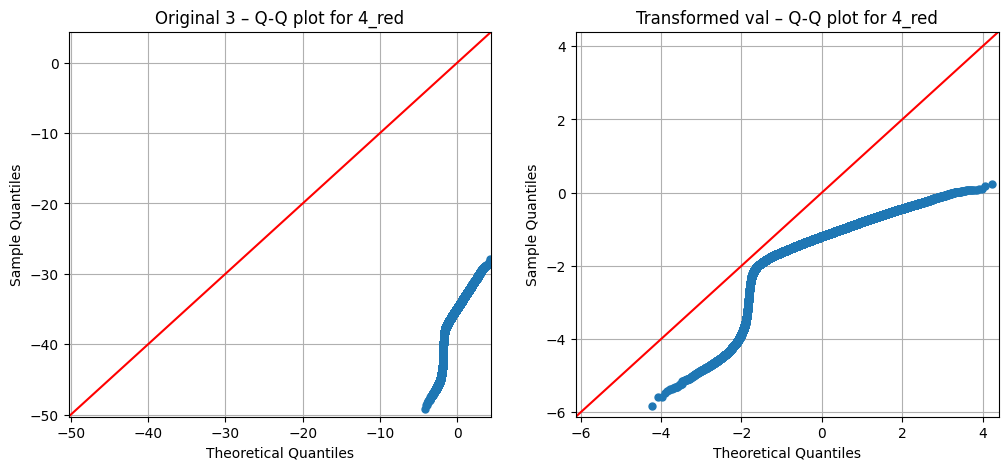

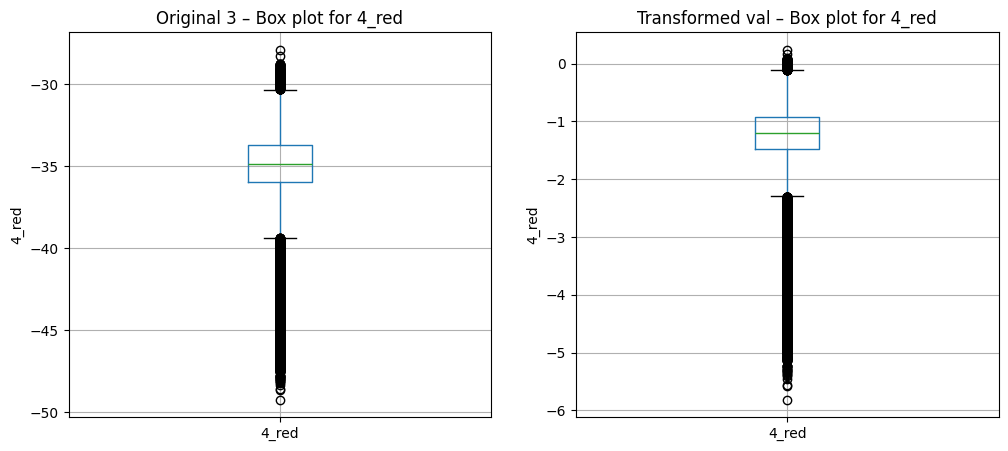

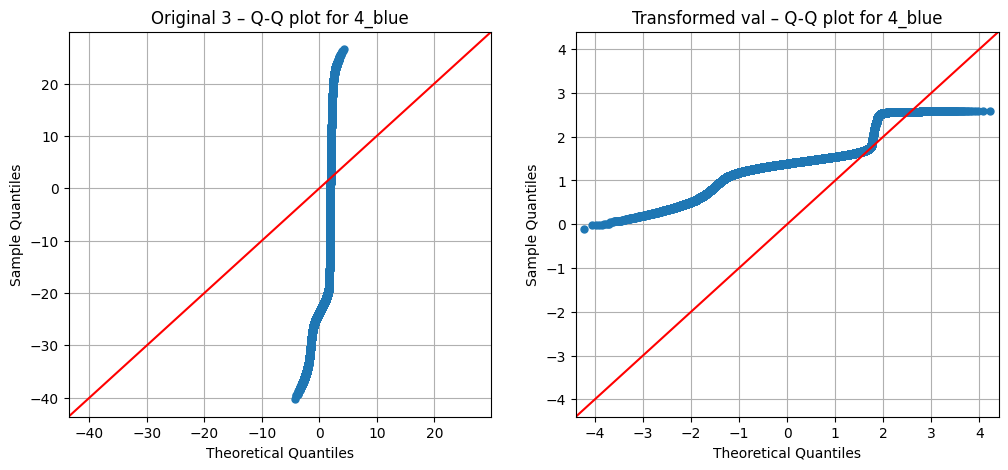

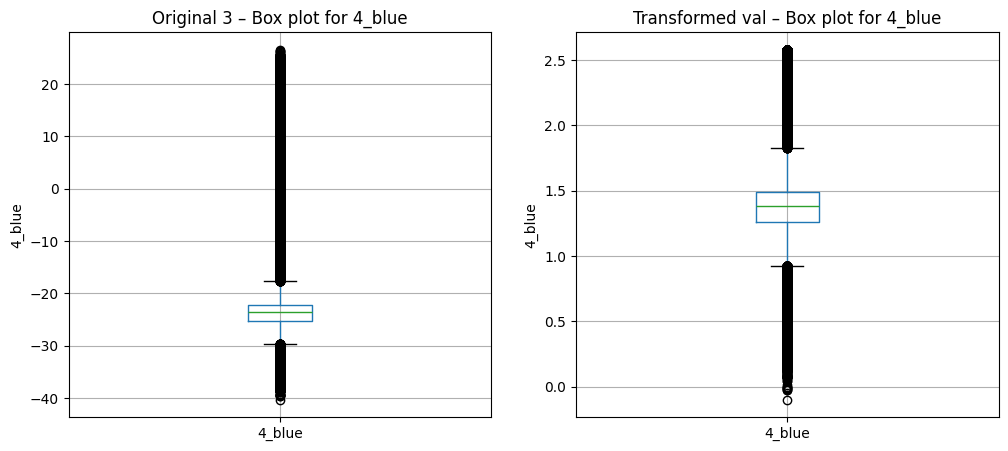

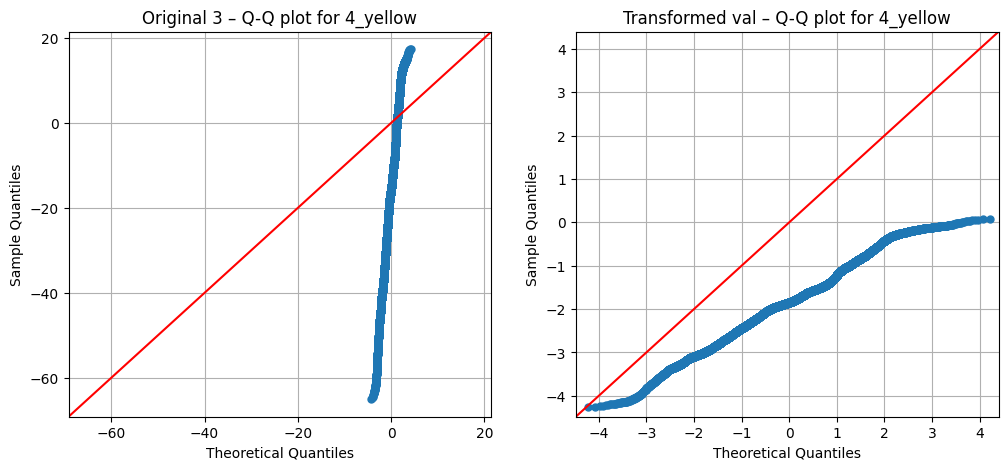

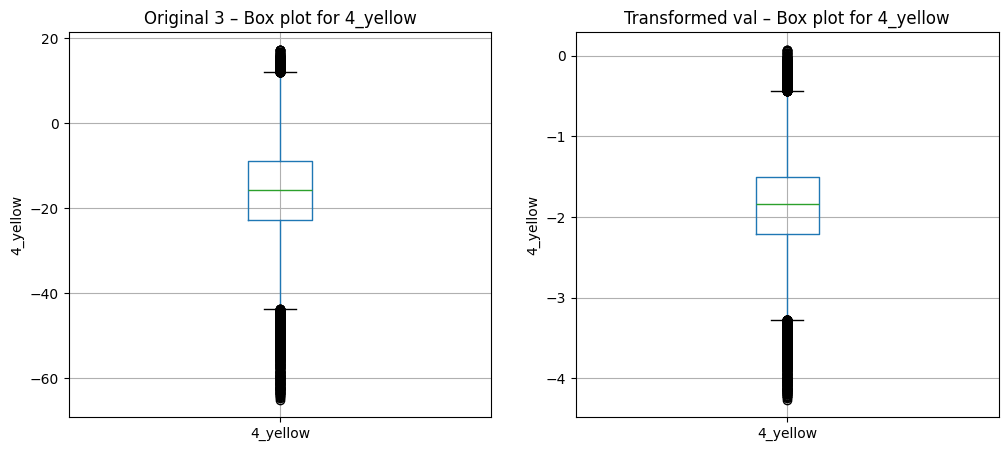

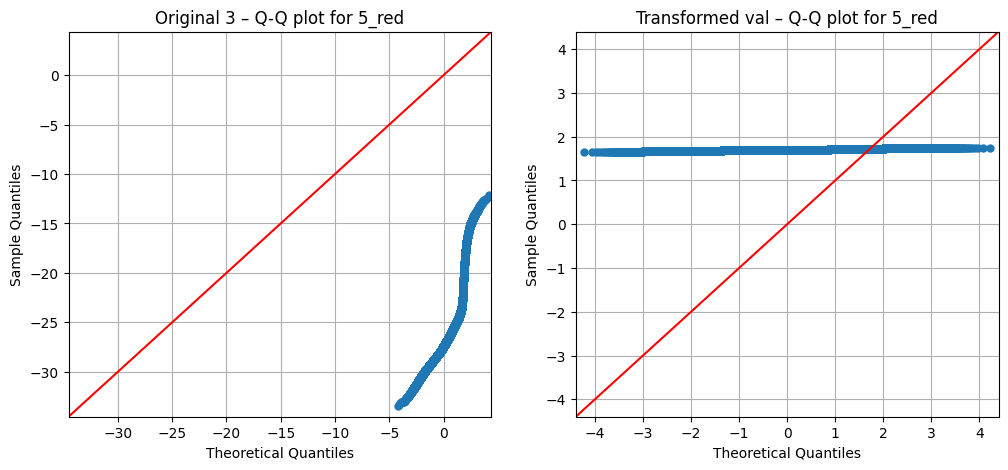

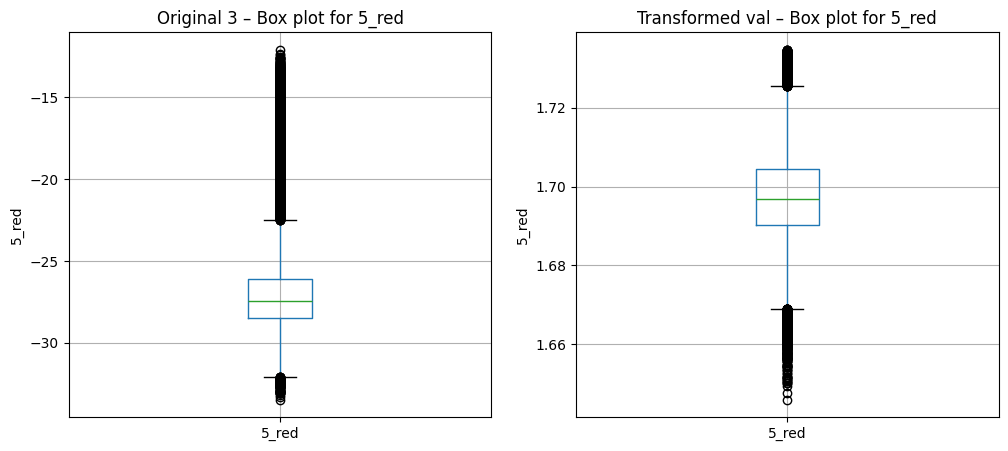

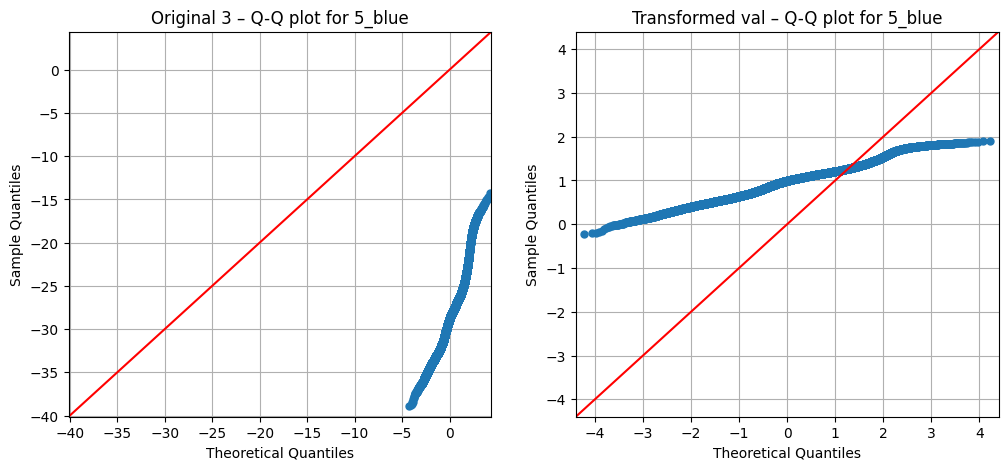

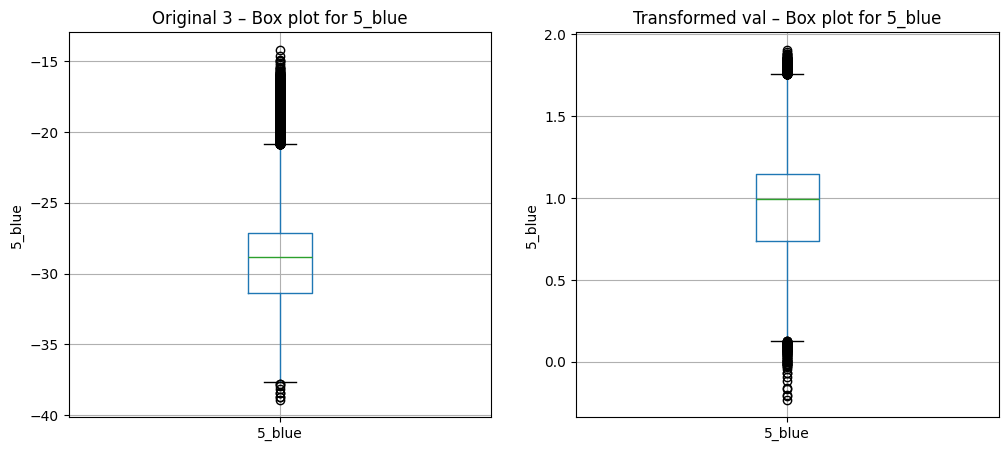

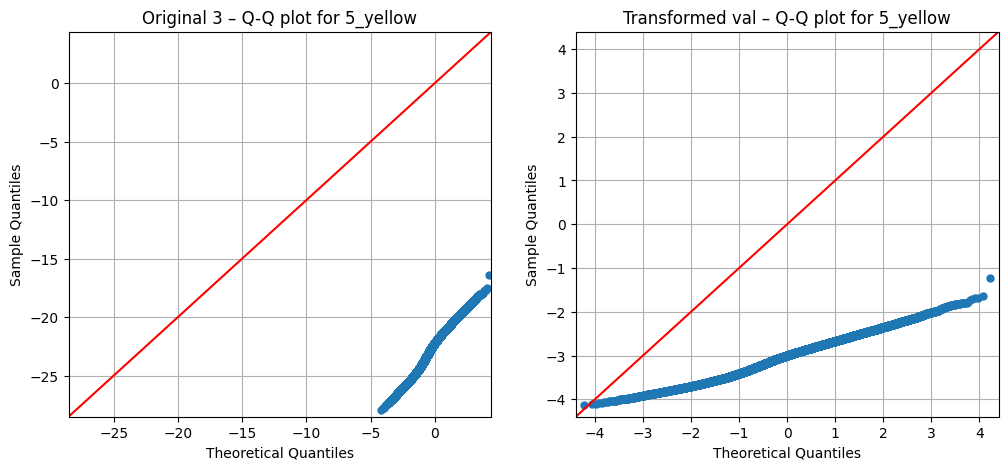

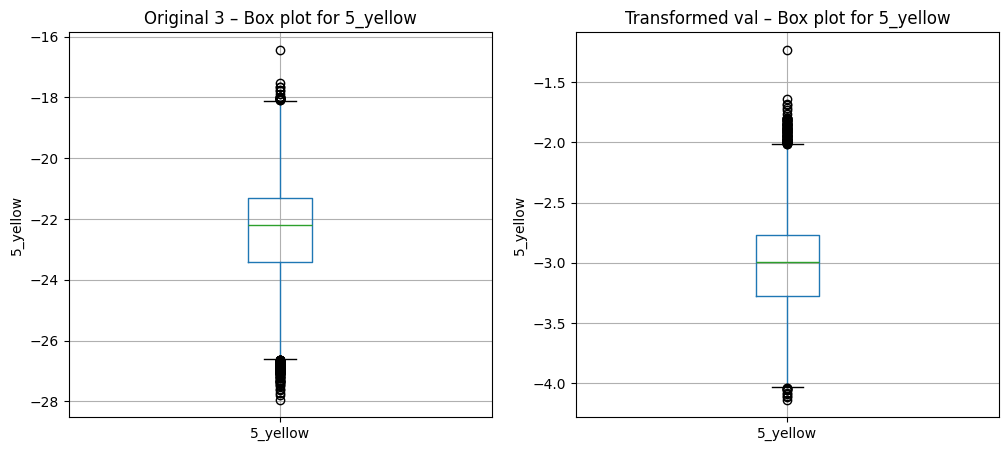

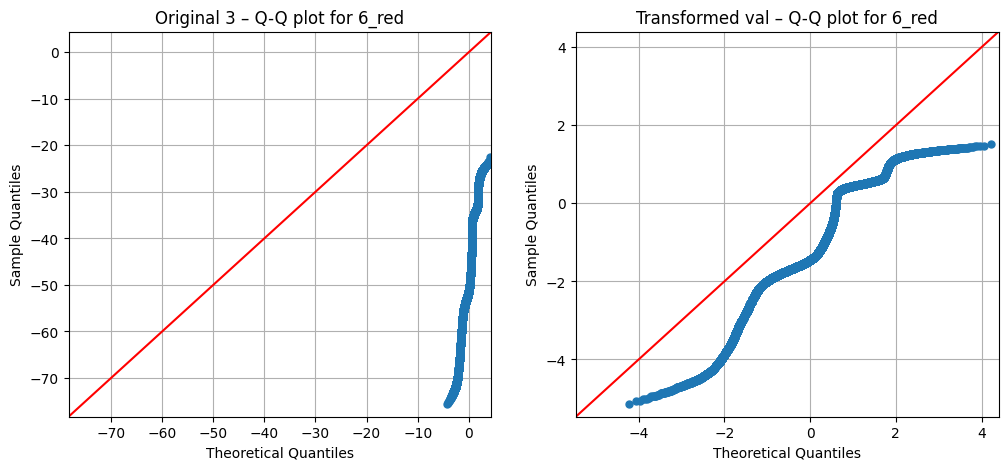

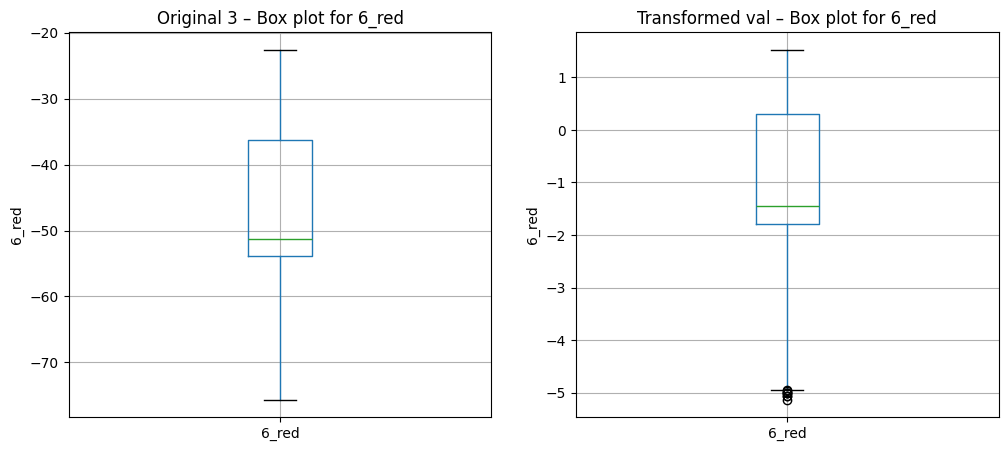

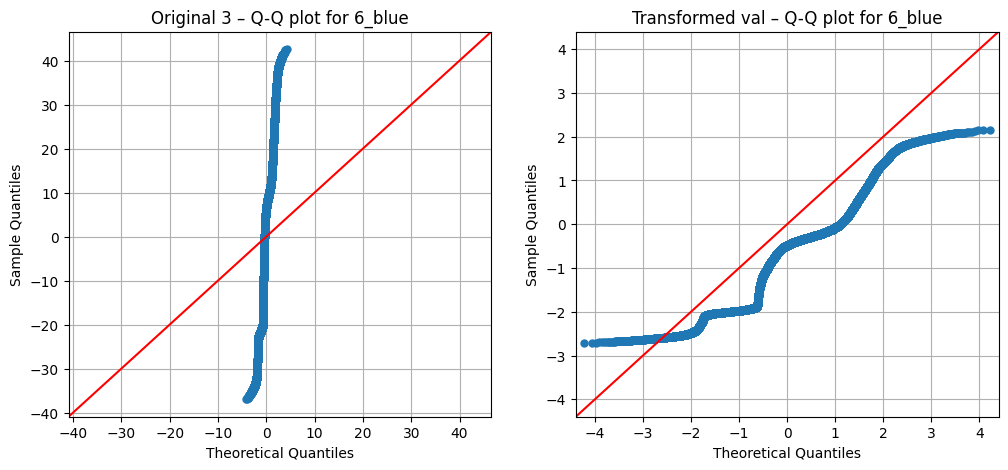

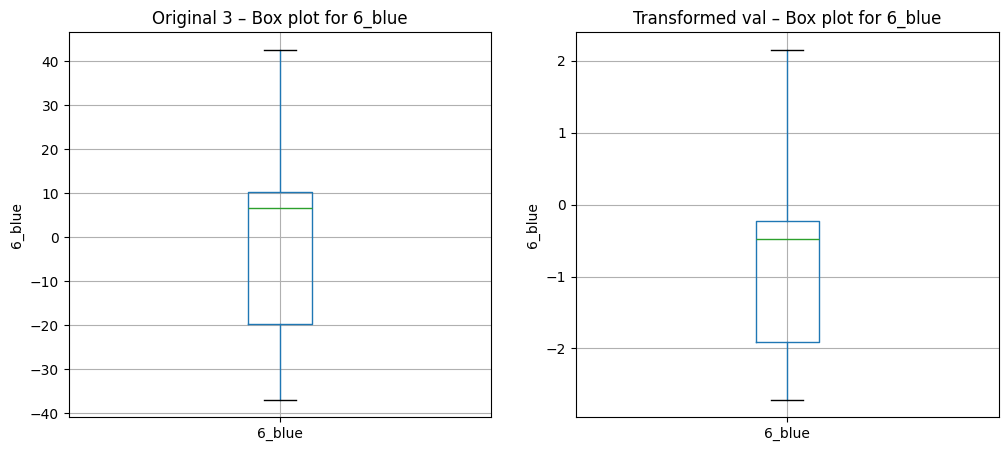

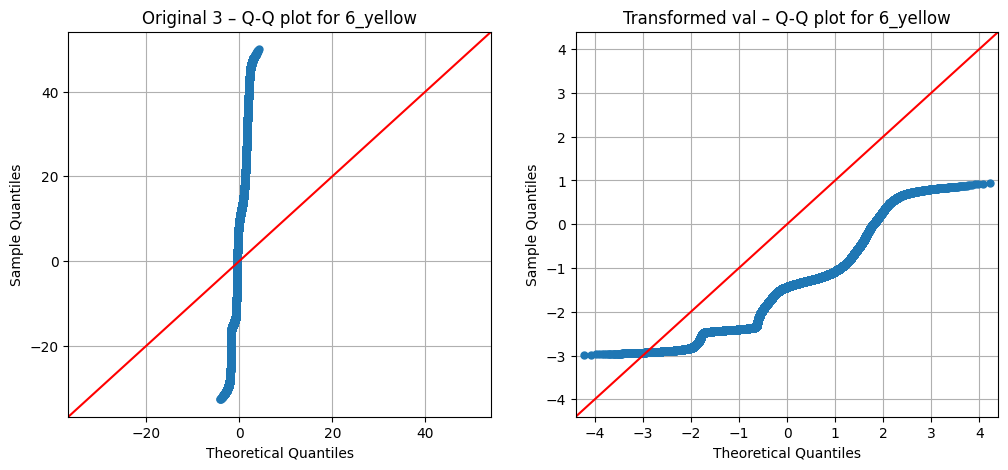

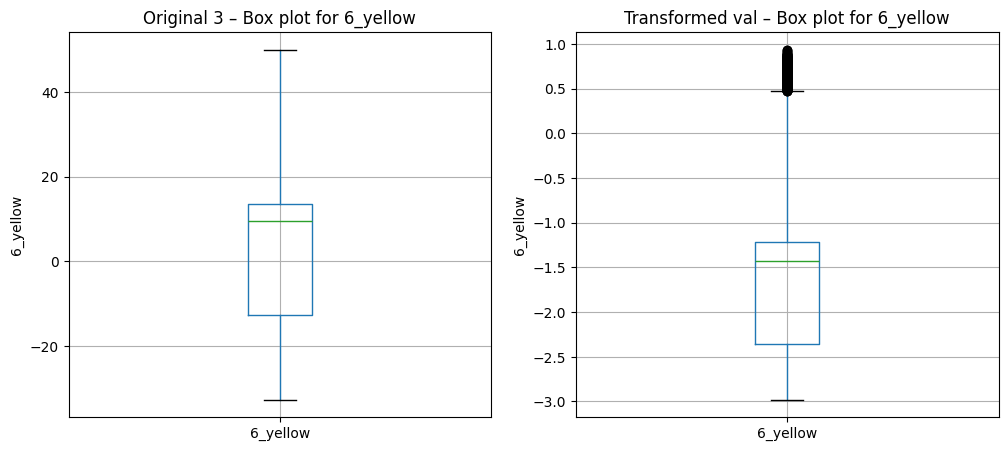

Processing DataFrame for original key 4 and transformed key test.


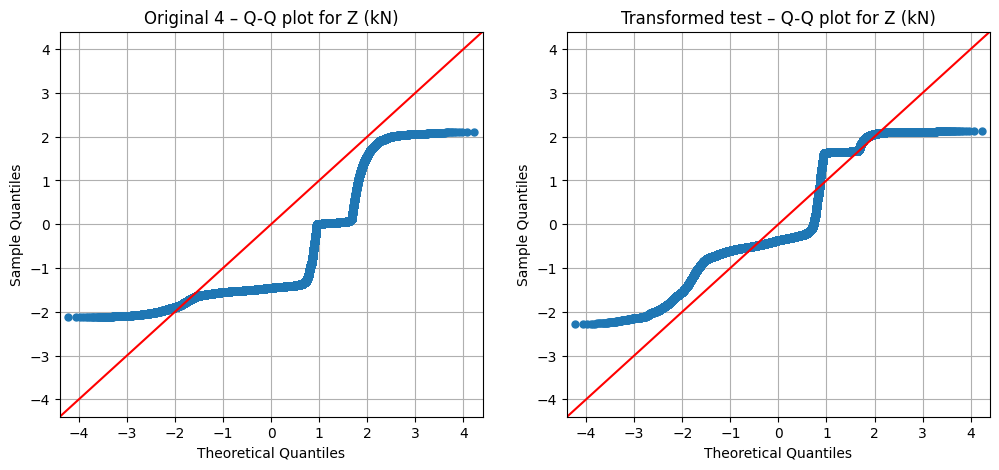

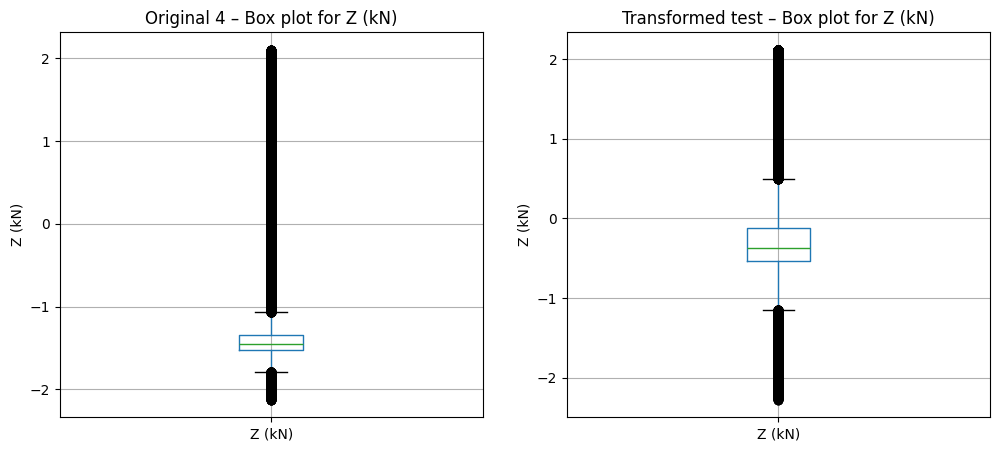

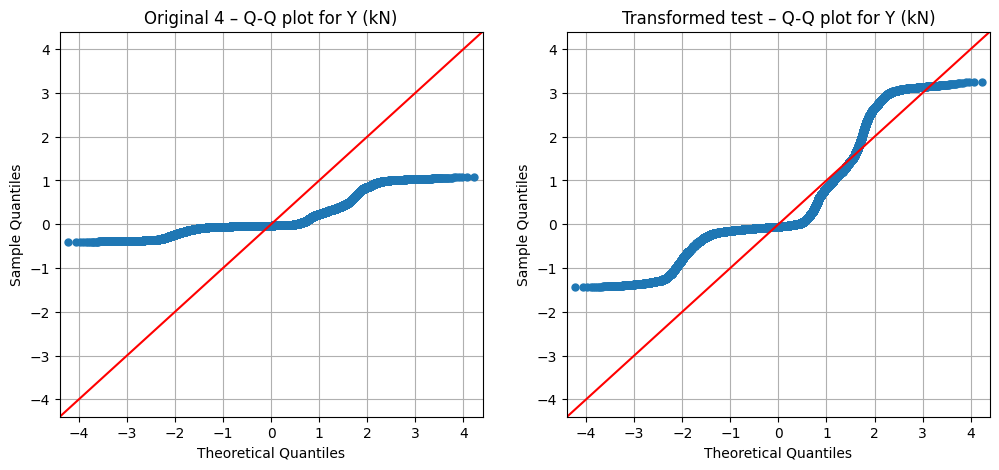

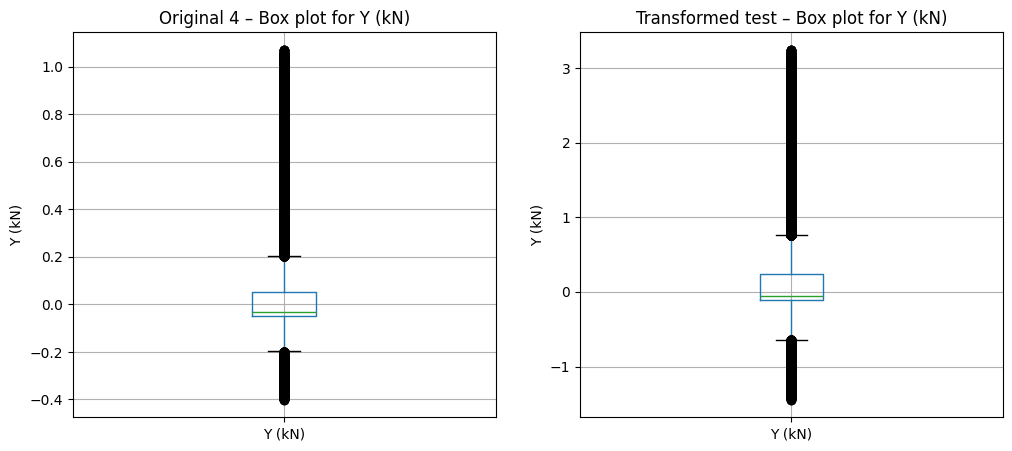

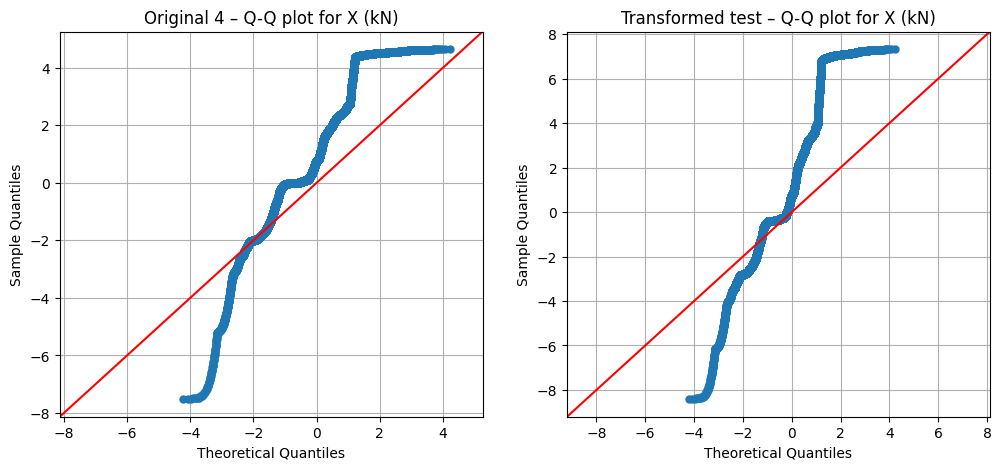

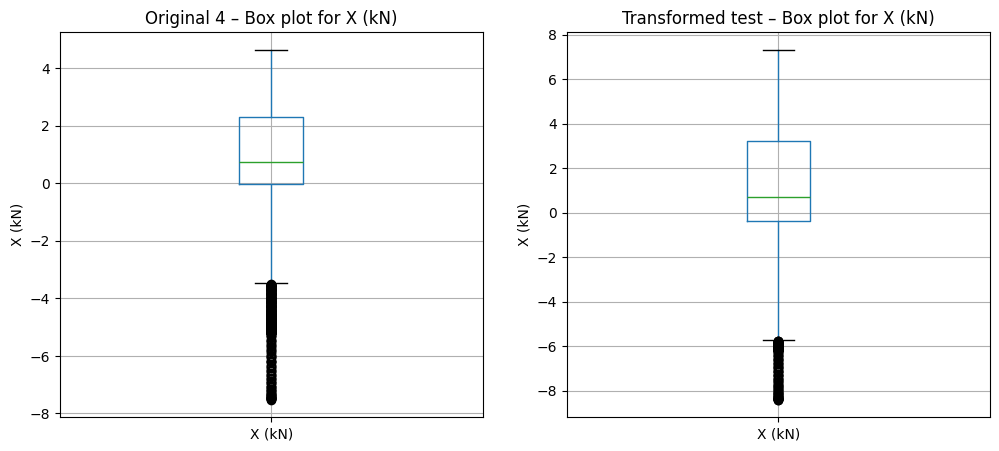

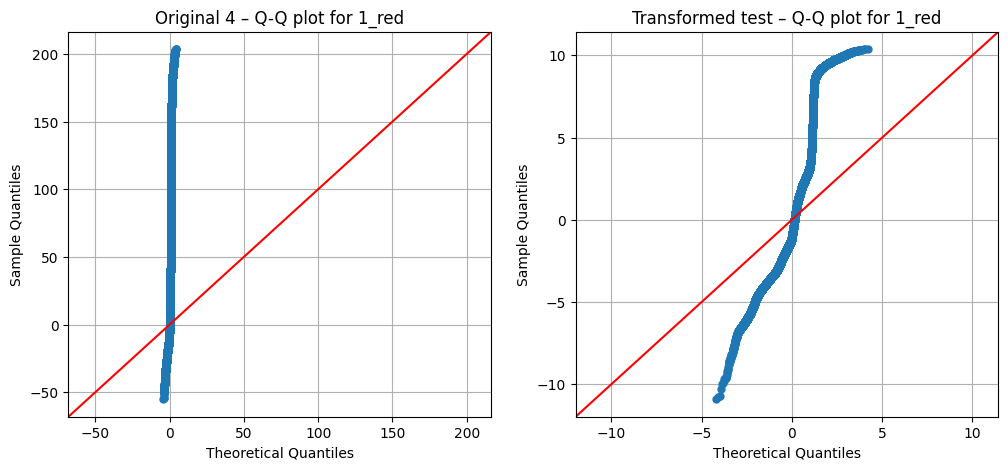

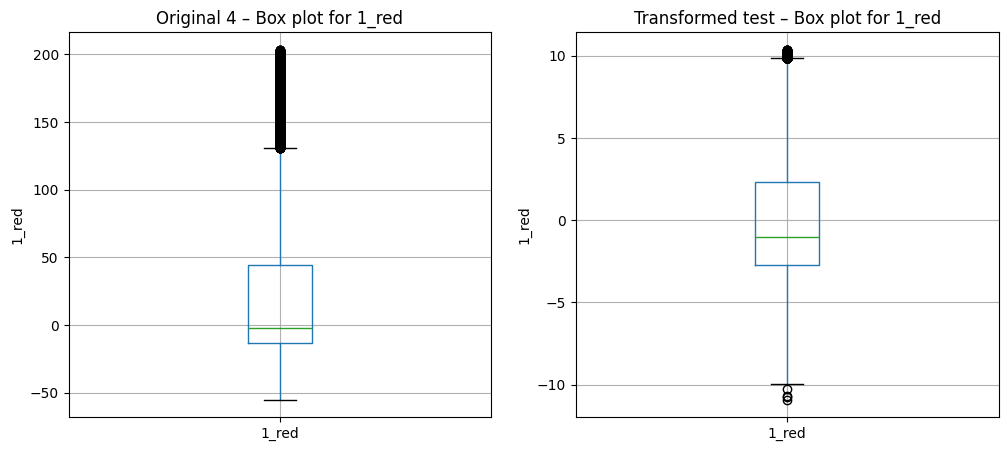

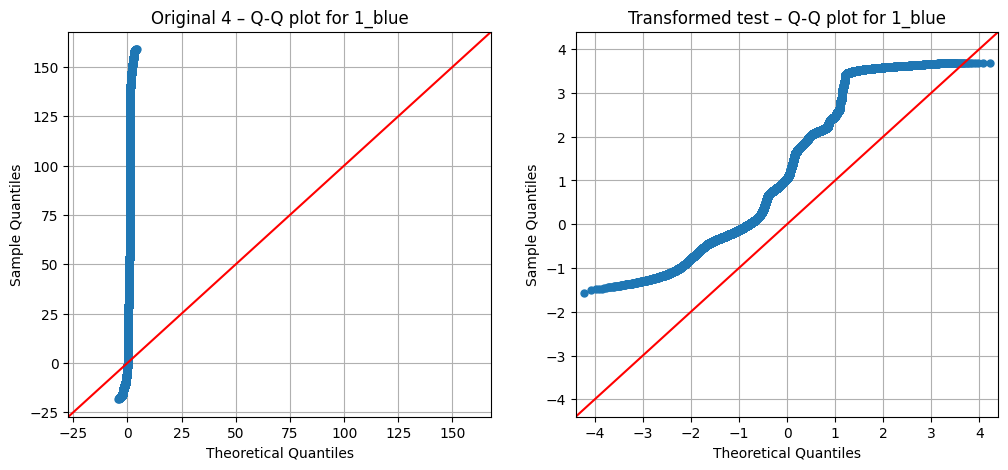

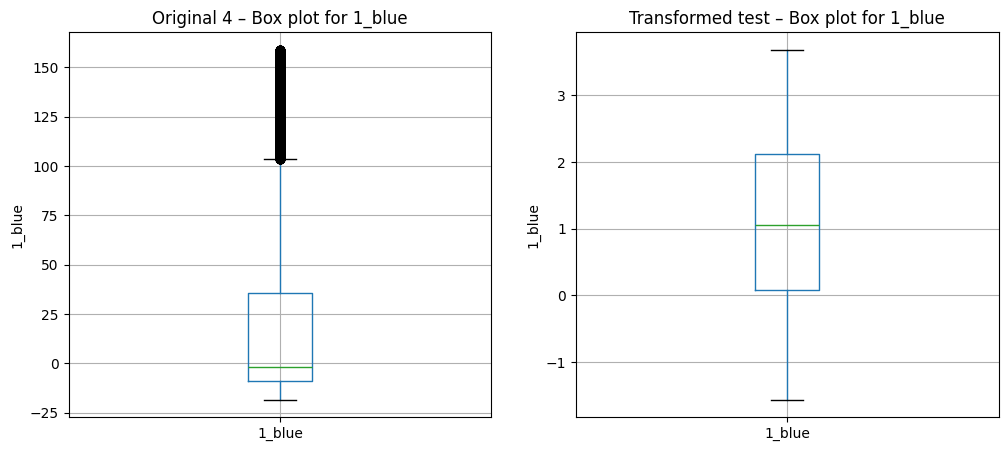

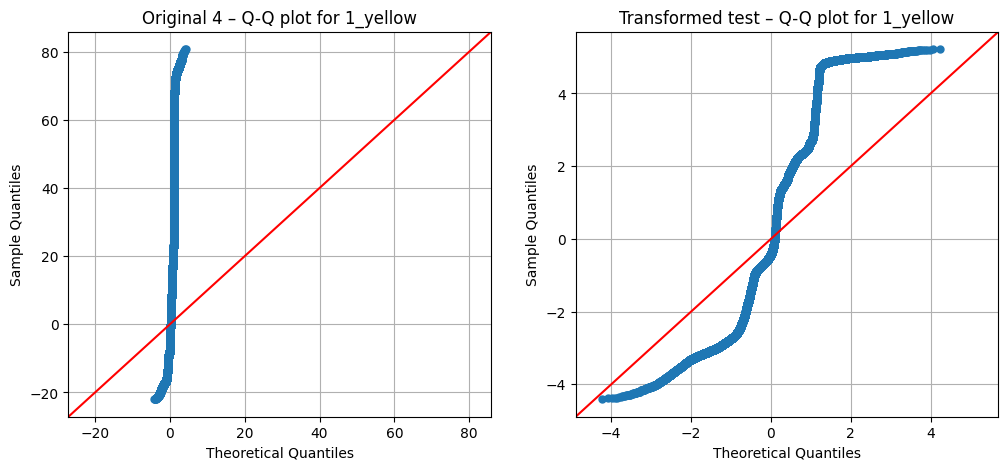

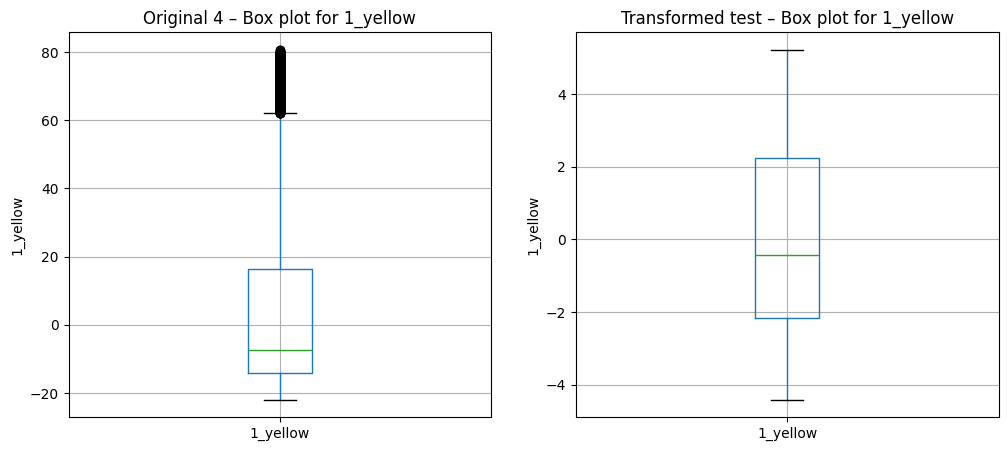

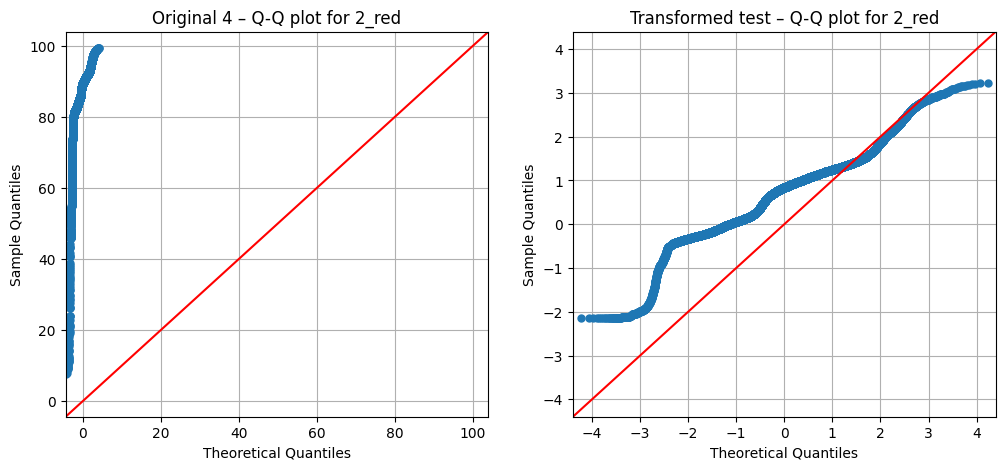

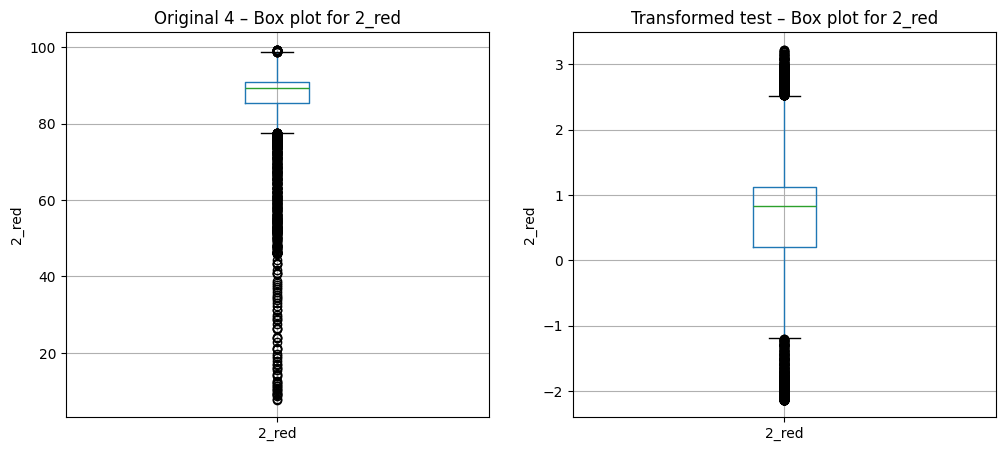

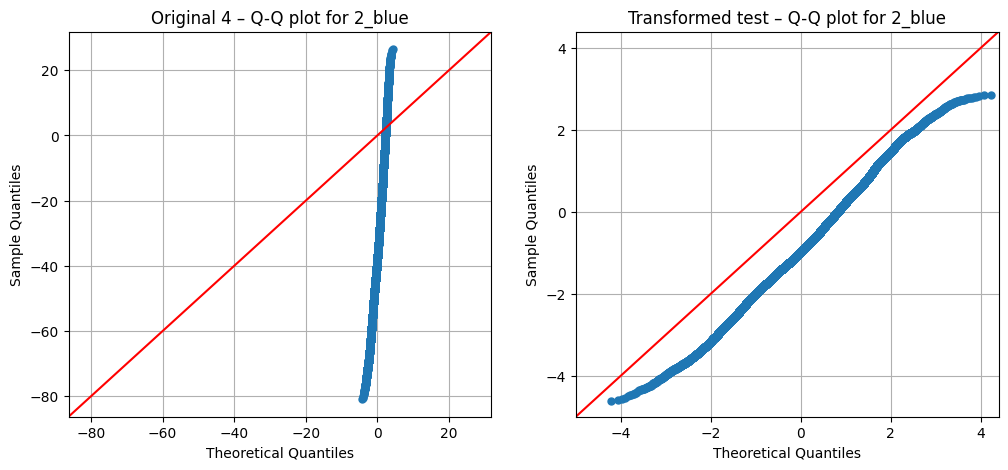

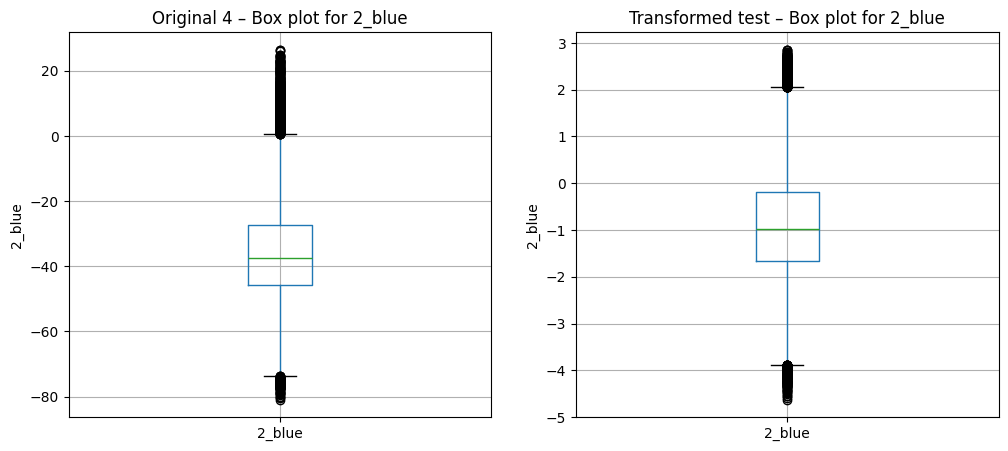

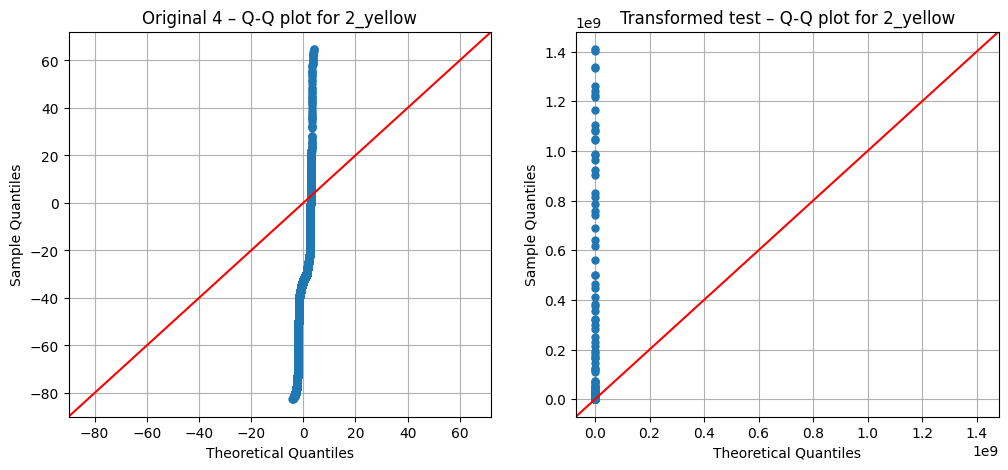

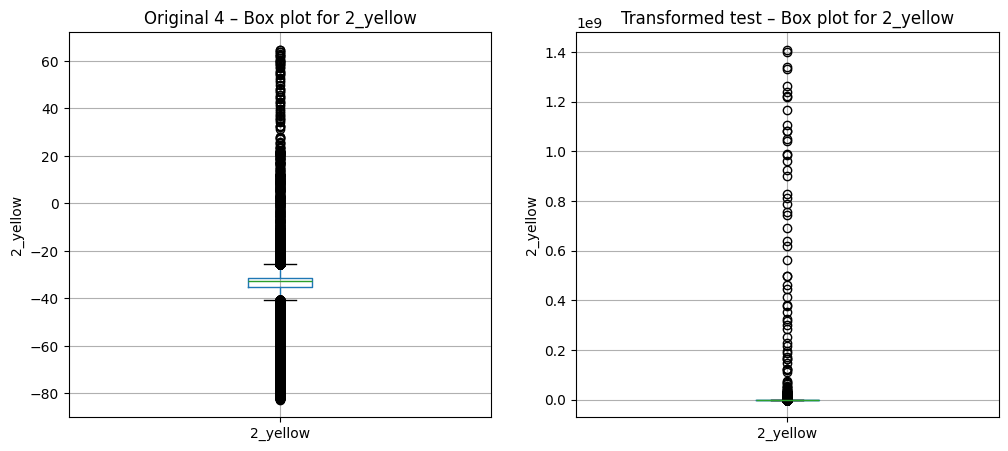

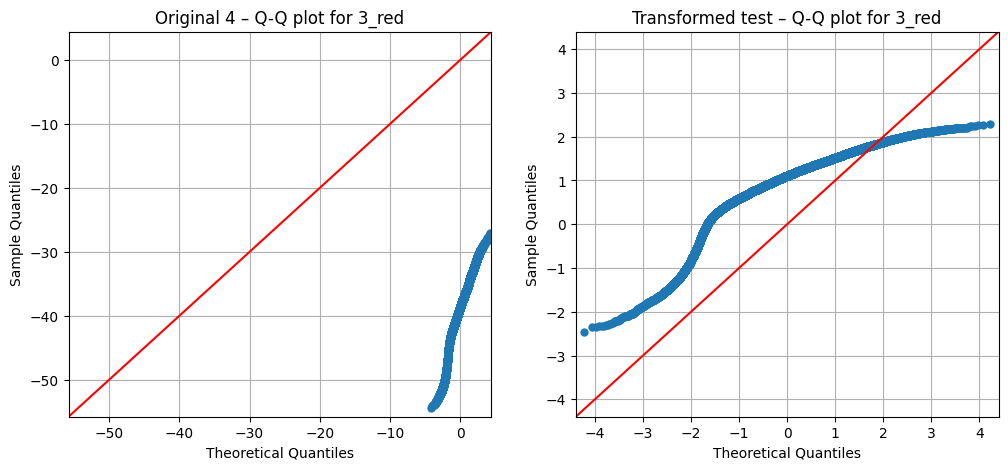

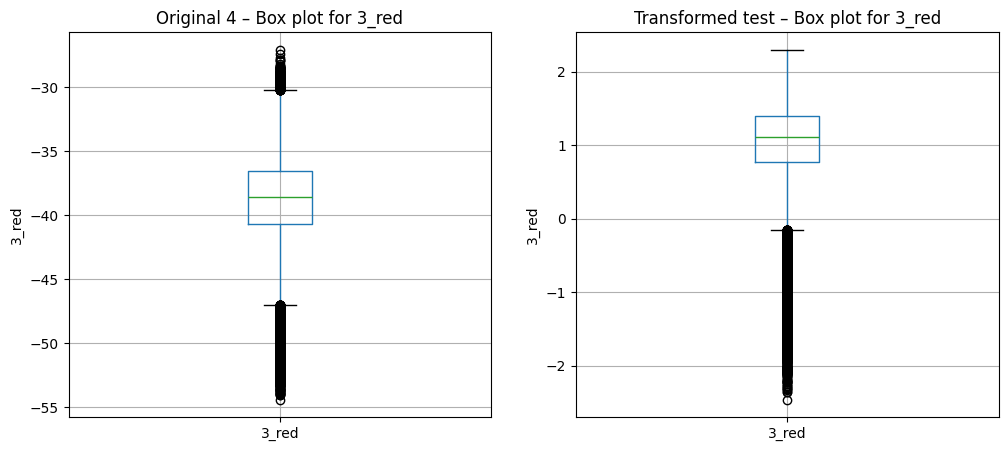

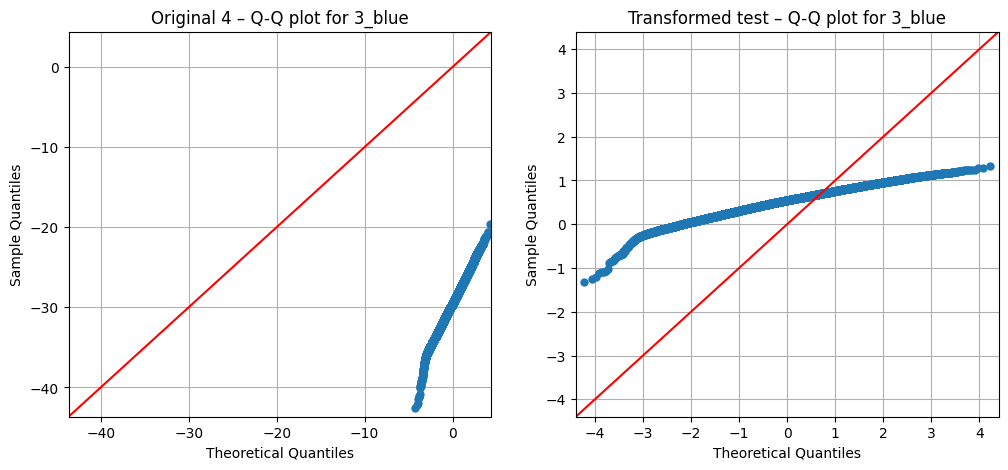

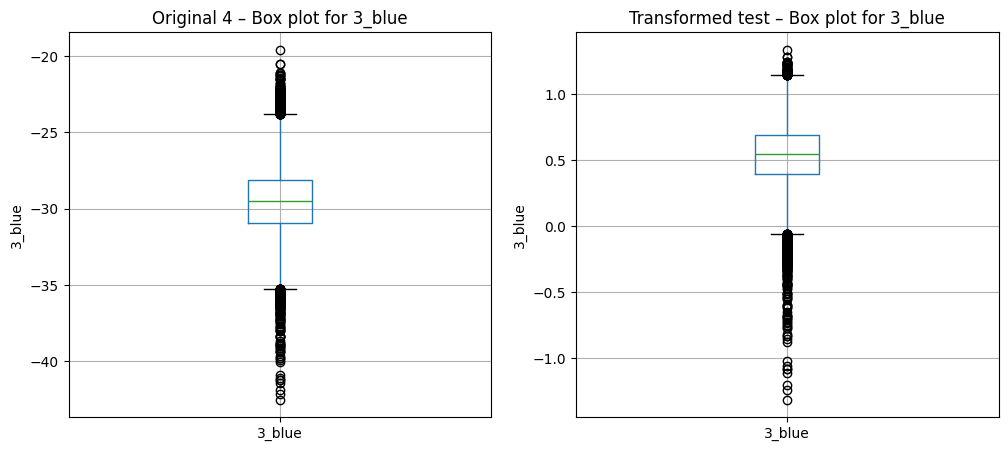

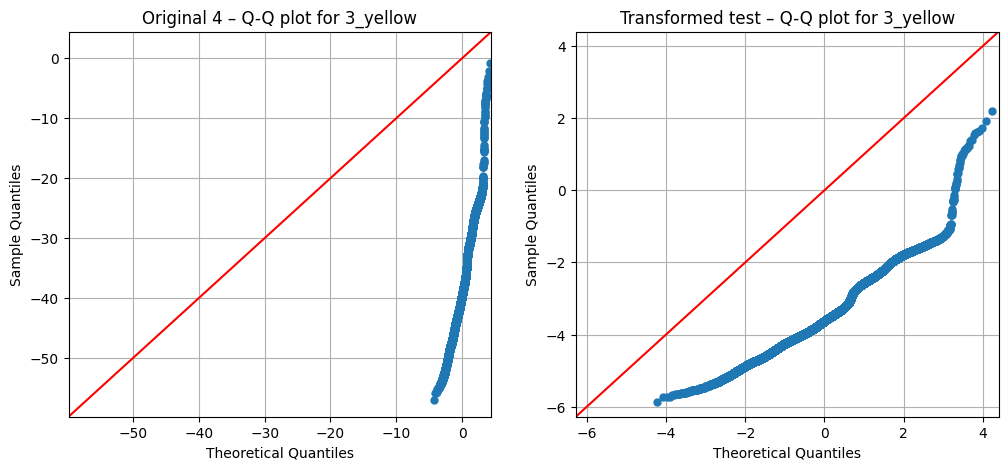

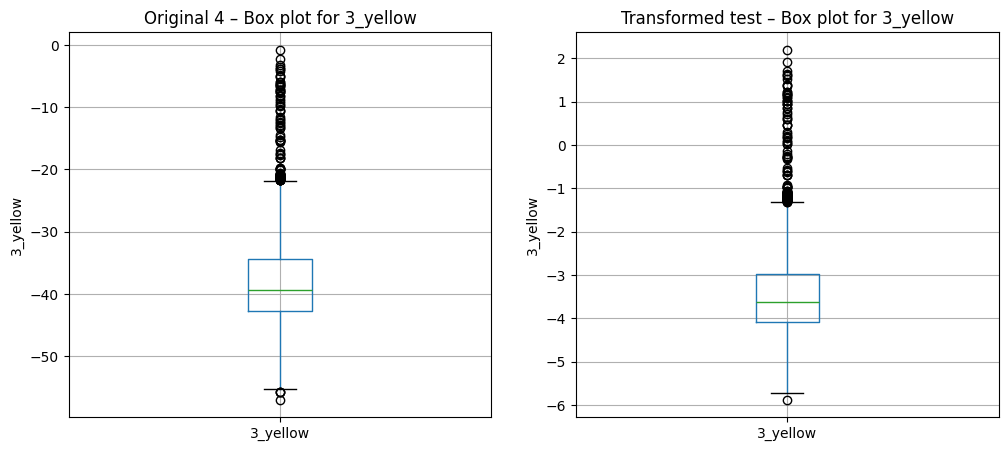

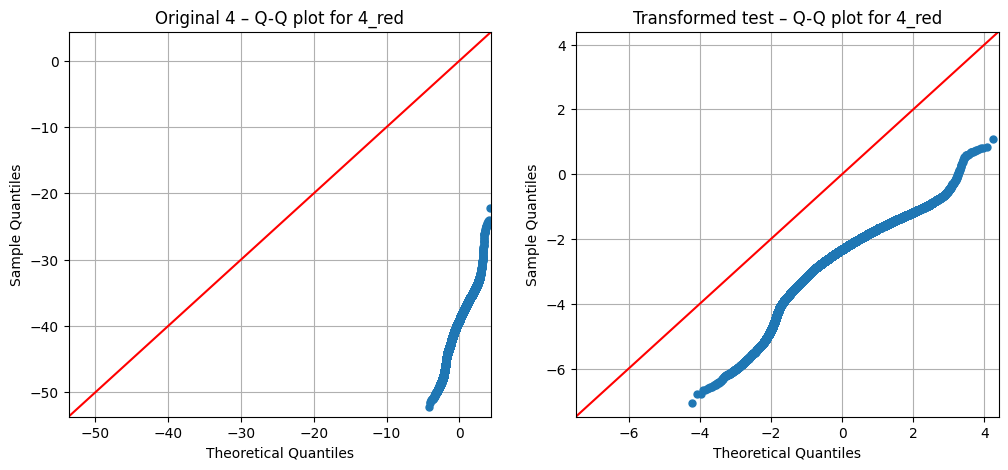

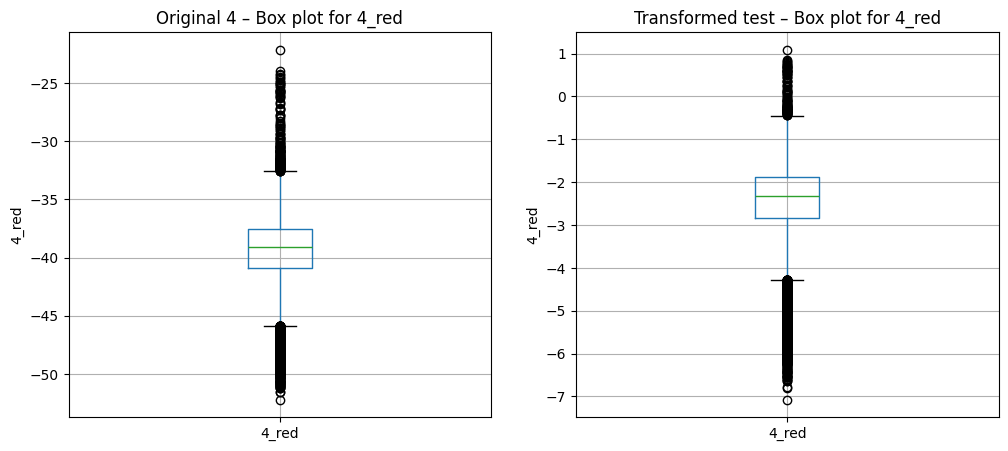

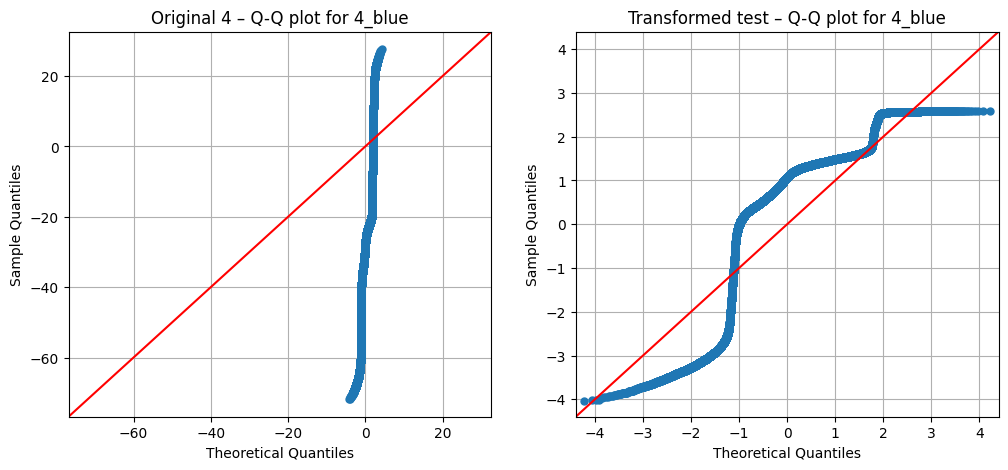

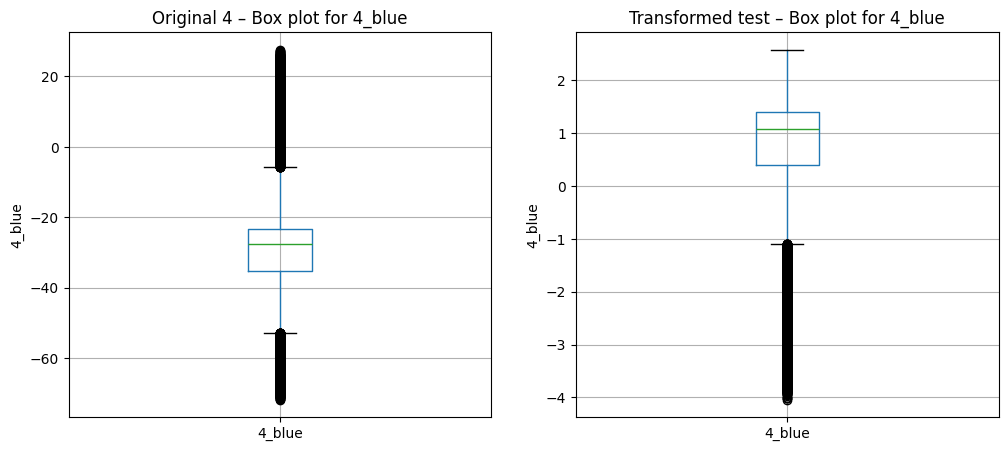

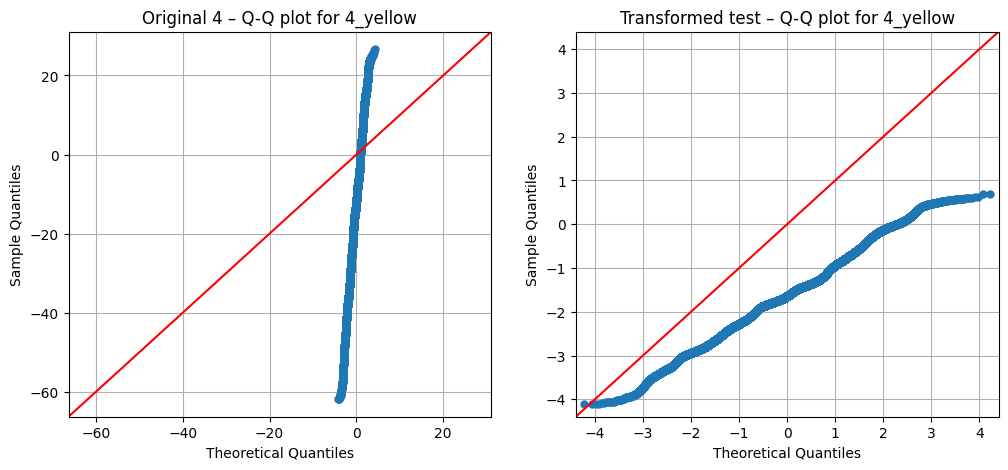

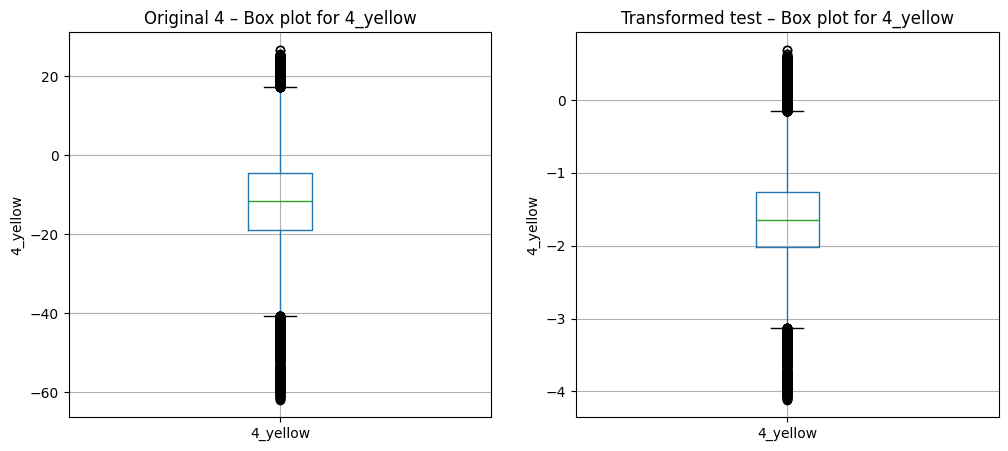

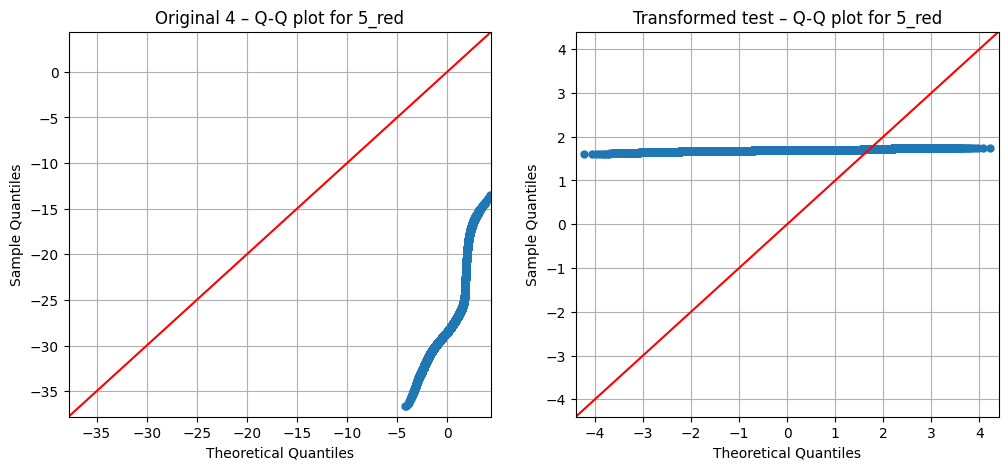

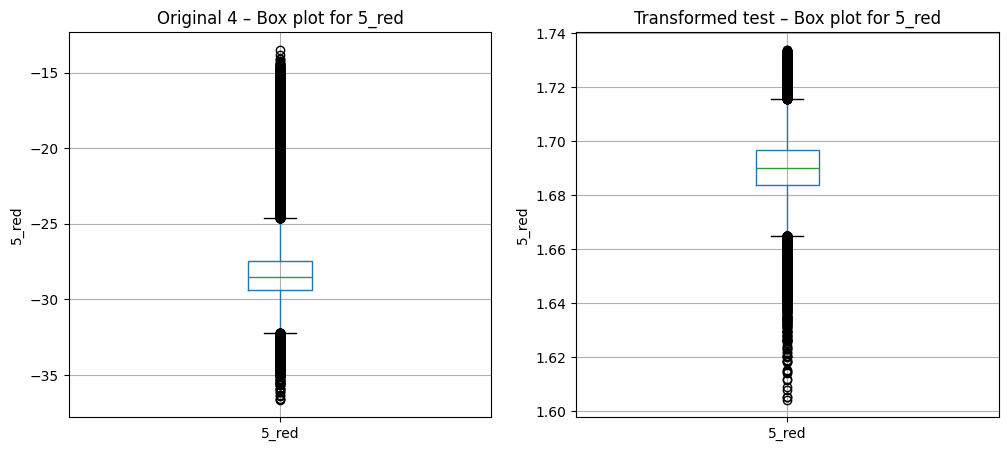

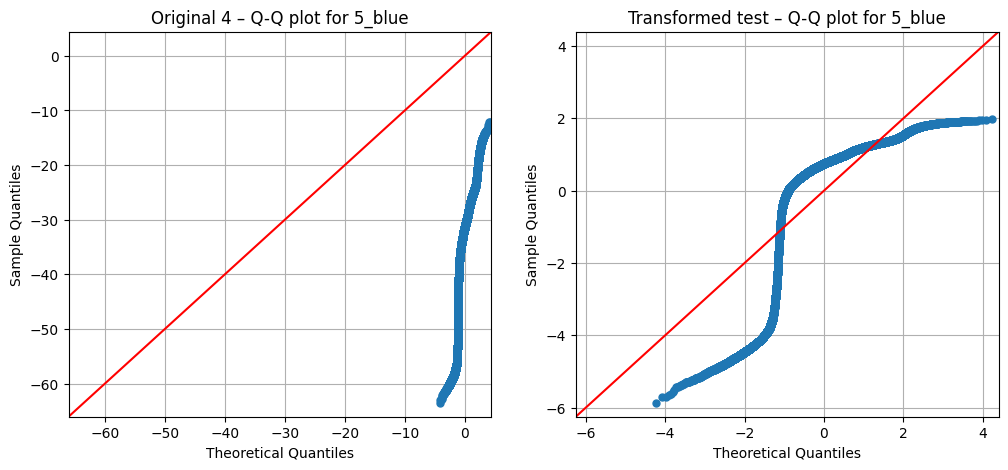

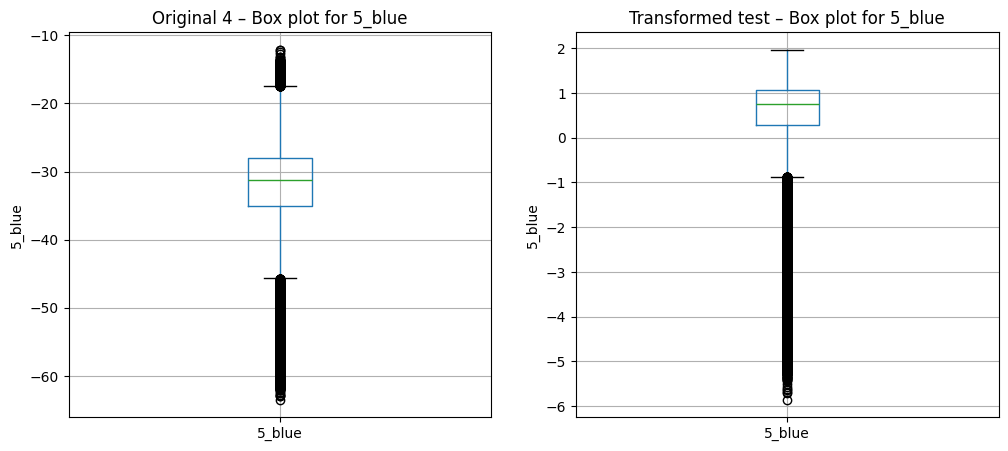

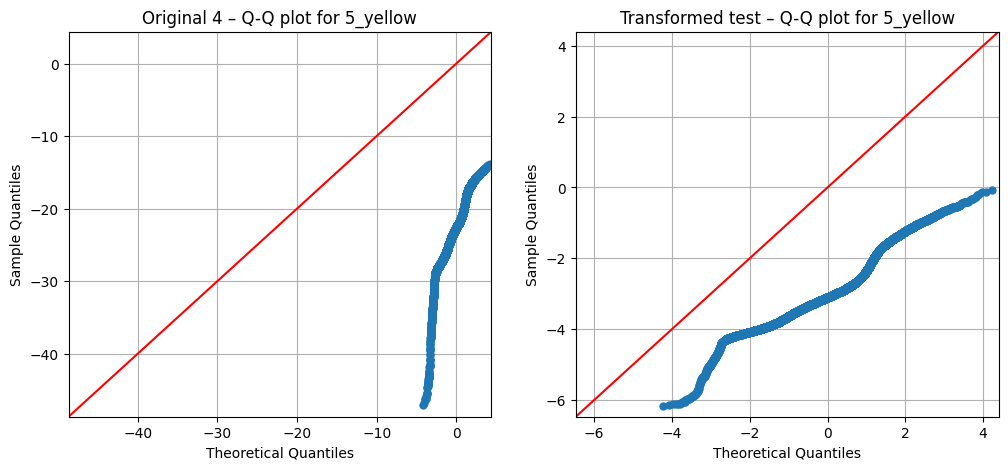

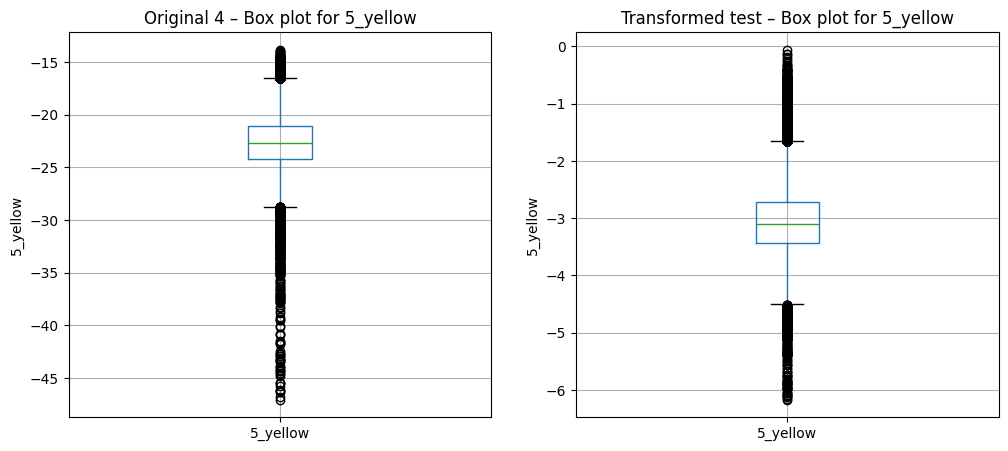

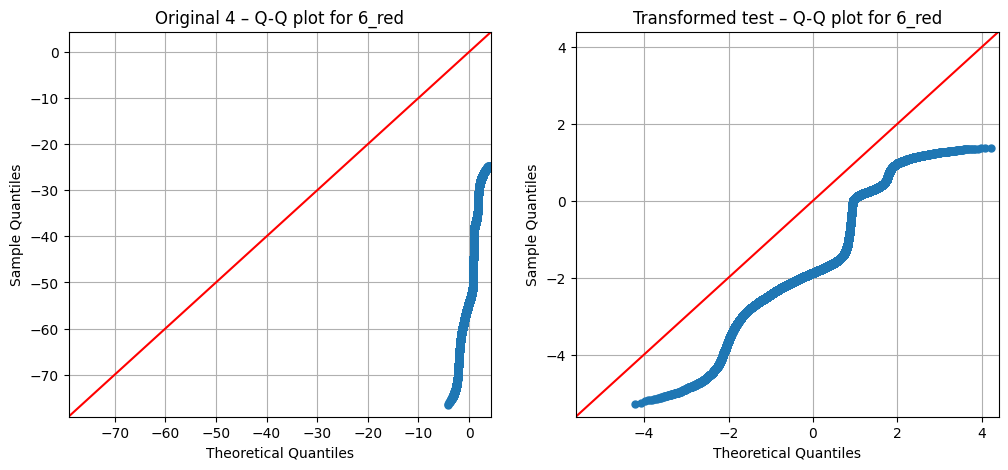

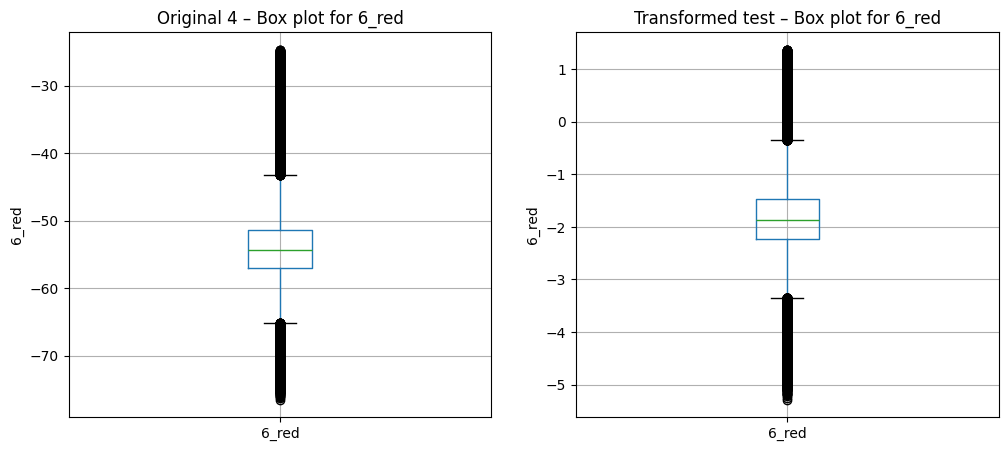

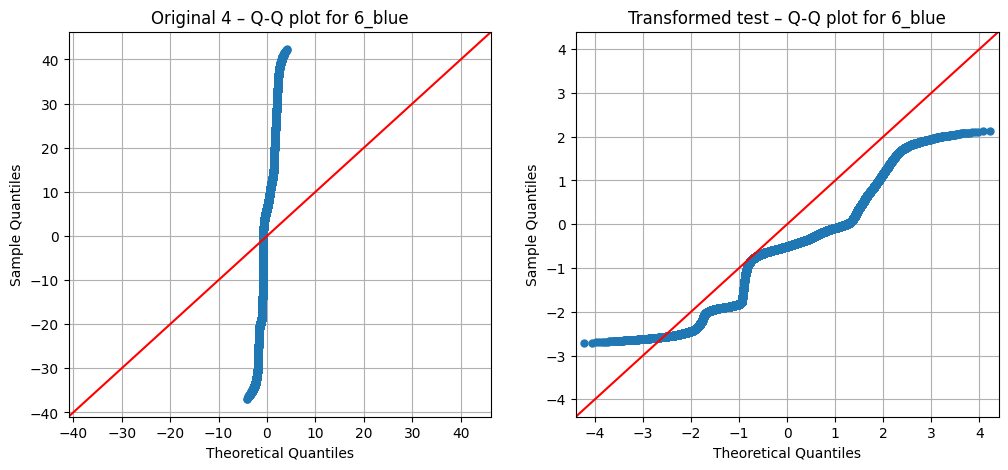

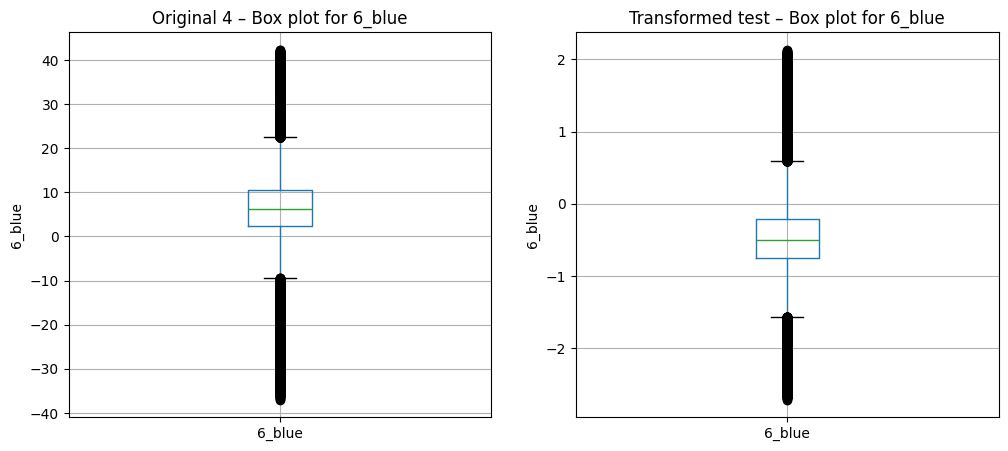

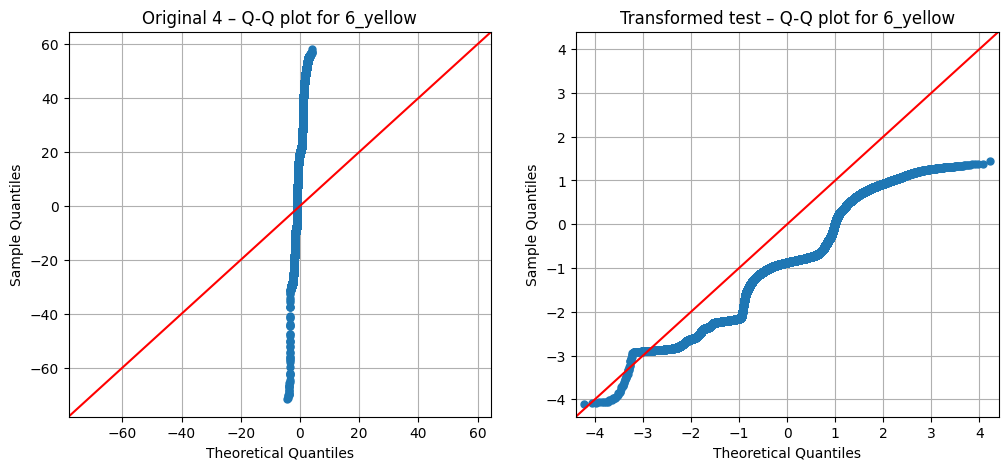

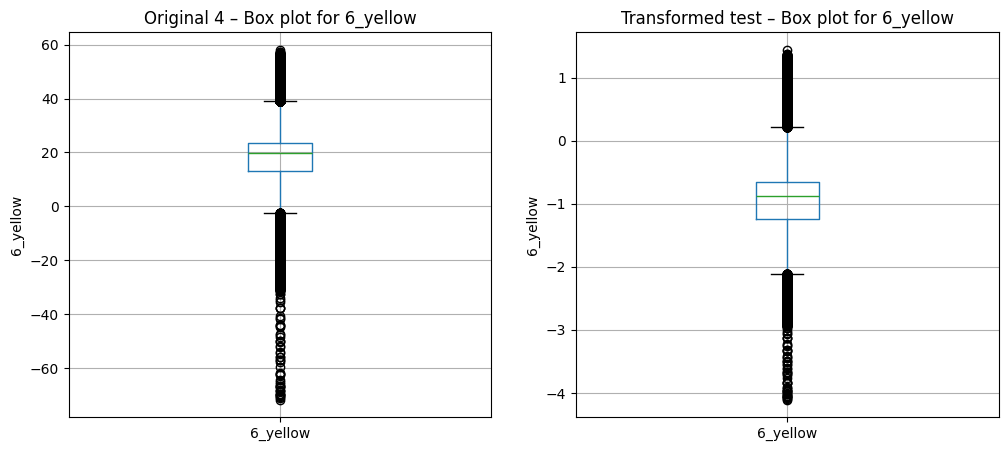

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def eda_outliers_comparison(original_dict, transformed_dict, key_mapping):
    """
    For each numeric column in the original and transformed DataFrames:
      1. Draw a Q–Q plot against a normal distribution.
      2. Draw a box (quartile) plot.
    """
    # Iterate over the key-value pairs in the original dictionary
    for original_key, transformed_key in key_mapping.items():
        if original_key in original_dict and transformed_key in transformed_dict:
            original_df = original_dict[original_key]
            transformed_df = transformed_dict[transformed_key]
            print(f"Processing DataFrame for original key {original_key} and transformed key {transformed_key}.")

            # Check if DataFrames are not empty
            if not original_df.empty and not transformed_df.empty:
                # Iterate over numerical columns
                for col in original_df.select_dtypes(include='number').columns:
                    if col in transformed_df.columns:
                        original_data = original_df[col].dropna()  # Ensure no NaN values
                        transformed_data = transformed_df[col].dropna()  # Ensure no NaN values

                        # Create a figure with two subplots side by side
                        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

                        # Q–Q plot for original data
                        sm.qqplot(original_data, line='45', ax=axes[0], marker='o', markersize=5)
                        axes[0].set_title(f'Original {original_key} – Q-Q plot for {col}')
                        axes[0].grid(True)

                        # Q–Q plot for transformed data
                        sm.qqplot(transformed_data, line='45', ax=axes[1], marker='o', markersize=5)
                        axes[1].set_title(f'Transformed {transformed_key} – Q-Q plot for {col}')
                        axes[1].grid(True)

                        plt.show()

                        # Create a figure with two subplots side by side for box plots
                        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

                        # Box plot for original data
                        original_df.boxplot(column=col, ax=axes[0])
                        axes[0].set_title(f'Original {original_key} – Box plot for {col}')
                        axes[0].set_ylabel(col)

                        # Box plot for transformed data
                        transformed_df.boxplot(column=col, ax=axes[1])
                        axes[1].set_title(f'Transformed {transformed_key} – Box plot for {col}')
                        axes[1].set_ylabel(col)

                        plt.show()
                    else:
                        print(f"Column {col} not found in transformed DataFrame for key {transformed_key}.")
        else:
            print(f"Keys {original_key} or {transformed_key} not found in respective dictionaries.")

# Define the key mapping between the original and transformed dictionaries
key_mapping = {
    1: 'train1',
    2: 'train2',
    3: 'val',
    4: 'test'
}

# Assuming merged and transformed_data are dictionaries of DataFrames
eda_outliers_comparison(merged, transformed_data, key_mapping)

#IMPORTANTTheoretical Line: With fit=False, the Q-Q plot uses a strict 45-degree line
#that represents the theoretical quantiles of a normal distribution. This provides a direct comparison between the sample data and the theoretical distribution.

In [ ]:
print(merged.keys())
print(transformed_data.keys())

dict_keys([1, 2, 3, 4])
dict_keys(['train1', 'train2', 'val', 'test'])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def compute_spearman_correlations(df_dict, target_column=None, draw_heatmap=True, save_path=None):
    """
    Computes Spearman correlations for a dictionary of DataFrames and optionally plots heatmaps.

    Args:
        df_dict (dict): Dictionary of DataFrames.
        target_column (str or None): If provided, computes feature-target Spearman correlation.
                                     If None, computes full Spearman correlation matrix.
        draw_heatmap (bool): If True, displays heatmap using seaborn.
        save_path (str or None): Directory path to save the heatmaps. If None, does not save.

    Returns:
        dict: Dictionary of Spearman correlation results per DataFrame.
    """
    corr_results = {}

    for name, df in df_dict.items():
        df = df.dropna()

        if target_column is not None:
            if target_column not in df.columns:
                raise ValueError(f"Target column '{target_column}' not found in DataFrame '{name}'.")

            corr = df.corr(method='spearman')[[target_column]].drop(target_column)
        else:
            corr = df.corr(method='spearman')

        corr_results[name] = corr

        # Plot heatmap
        if draw_heatmap:
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
            plt.title(f"Spearman Correlation Heatmap - {name}")
            plt.tight_layout()

            if save_path:
                os.makedirs(save_path, exist_ok=True)
                plt.savefig(os.path.join(save_path, f"{name}_heatmap.png"))
                plt.show()
            else:
                plt.show()

            plt.close()

    return corr_results

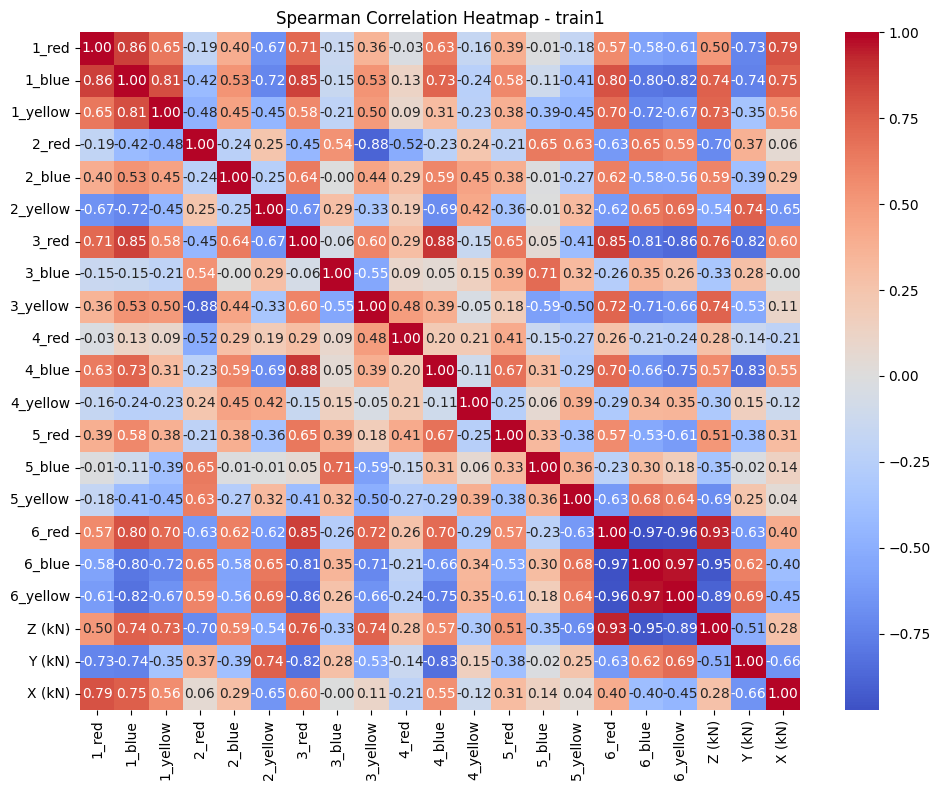

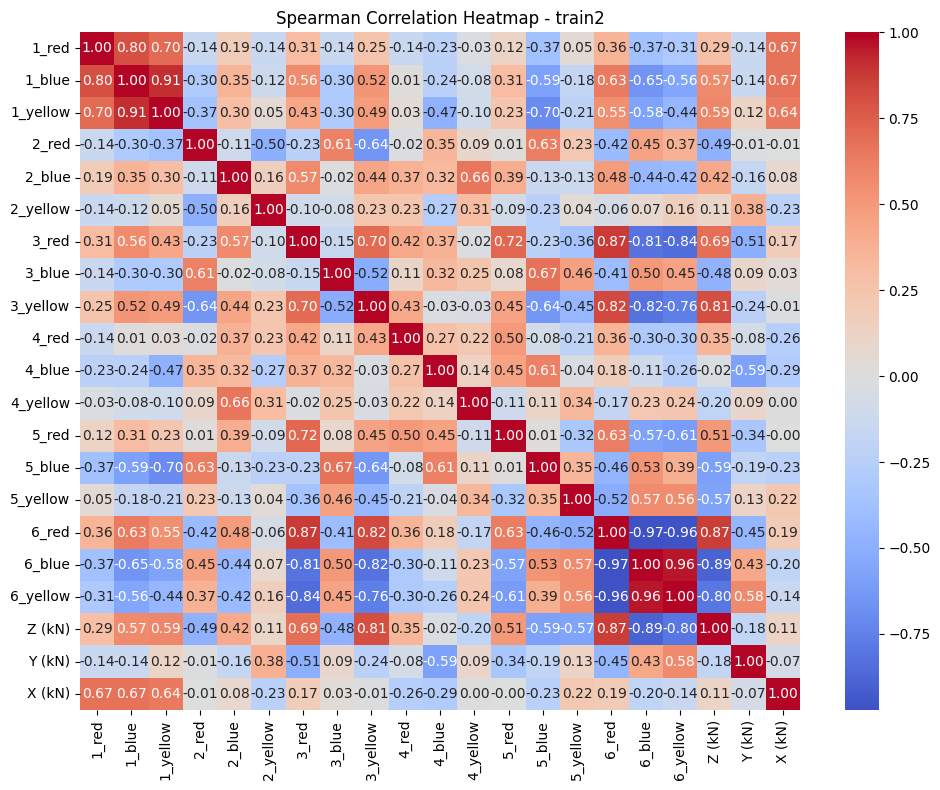

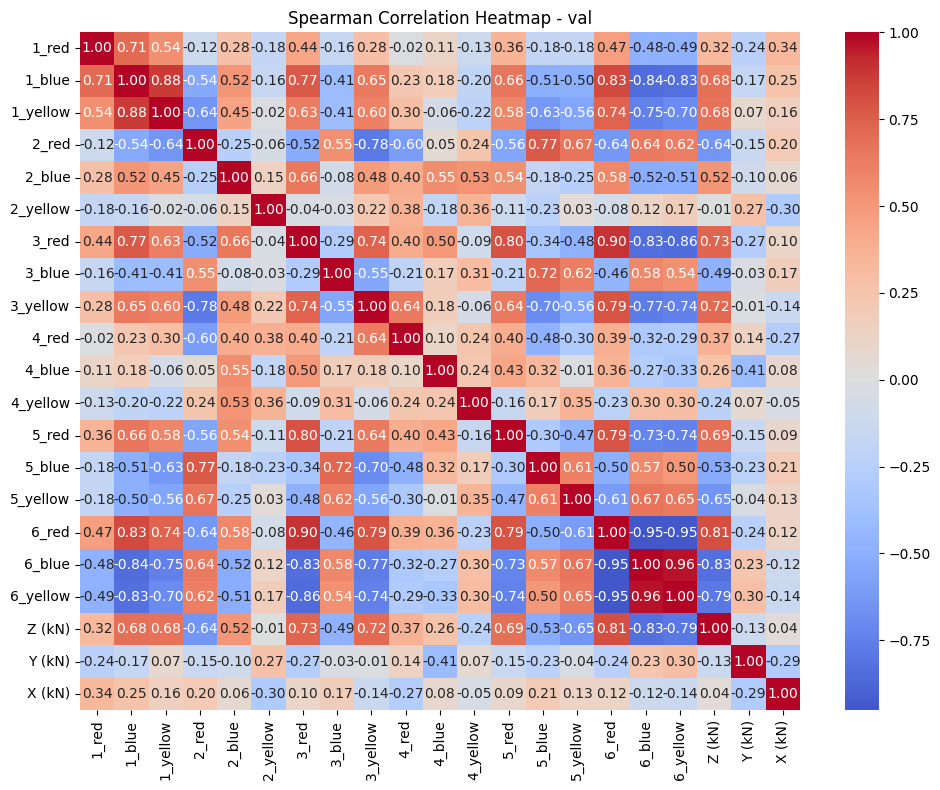

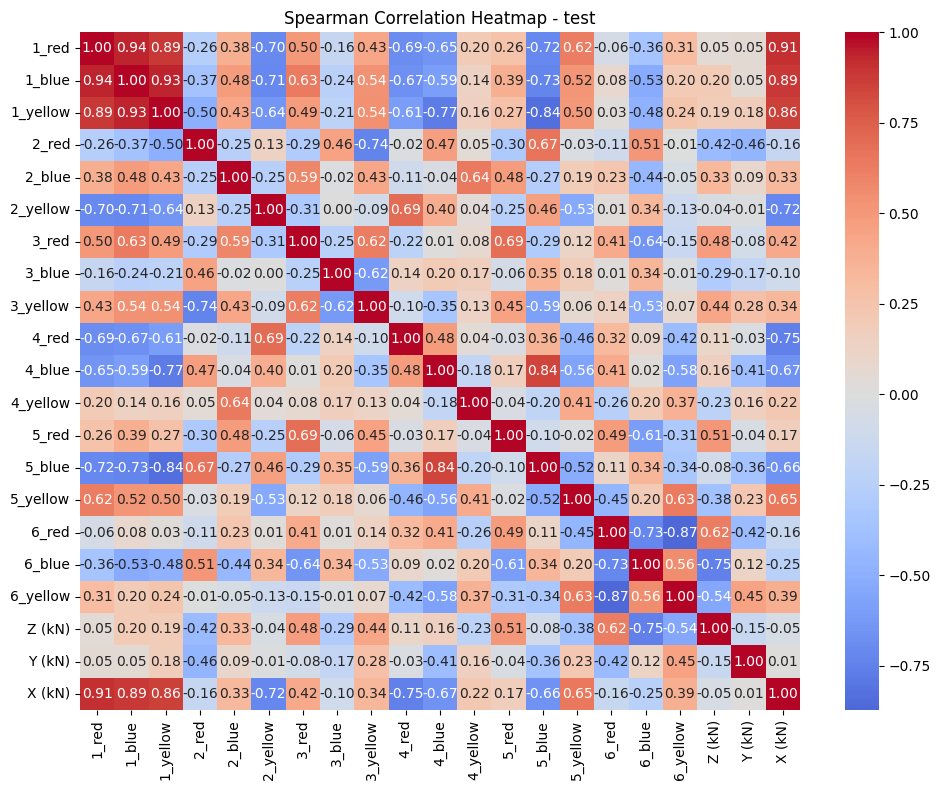

In [ ]:
corr_results = compute_spearman_correlations(transformed_data, save_path=checkpoints_path)

Scenario 1: n Prediction (Instantaneous Data / "Virtual Sensor"):

This model provides the best possible estimate of the force at the current moment (Y
t
Assumption: The controller loop is able to handle the 0.005 delay due to
overall system latency due to communication/computation/

---> No batching is used, treating as tabular Data (Since this is creating a "virtual sensor"), not anticipation of future force/ fault.

In [ ]:
import os
import pickle

# --- PARAMETERS ---
targets = ['Z (kN)', 'Y (kN)', 'X (kN)']
checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/'

# --- BUILD THE X/Y SPLITS ---
# 1) concat train1 & train2
train_full = pd.concat([transformed_data['train1'], transformed_data['train2']], axis=0)

# 2) helper to split X vs y
def split_X_y(df, target_cols):
    X = df.drop(columns=target_cols)
    y = df[target_cols]
    return X, y

# build checkpoint dict
checkpoints = {}

# train
X_train, y_train = split_X_y(train_full, targets)
checkpoints['train'] = {'X': X_train, 'y': y_train}

# val & test
for split in ['val', 'test']:
    df = transformed_data[split]
    X, y = split_X_y(df, targets)
    checkpoints[split] = {'X': X, 'y': y}

# test2predict (features only)
# assume test2predict is your DataFrame of the same feature columns
checkpoints['test2predict'] = {'X': test2predict.copy()}

# --- VERIFY SHAPES ---
for name, data in checkpoints.items():
    if 'y' in data:
        print(f"{name:12s} → X: {data['X'].shape},  y: {data['y'].shape}")
    else:
        print(f"{name:12s} → X: {data['X'].shape}  (no y)")

# --- SAVE PICKLES ---
os.makedirs(checkpoints_path, exist_ok=True)

with open(f'{checkpoints_path}checkpoint.pkl', 'wb') as f:
    pickle.dump(checkpoints, f)

print("\n✅ All checkpoints saved to:", checkpoints_path)


train        → X: (209809, 18),  y: (209809, 3)
val          → X: (84524, 18),  y: (84524, 3)
test         → X: (84490, 18),  y: (84490, 3)
test2predict → X: (125243, 18)  (no y)

✅ All checkpoints saved to: /content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/


Scenario 2: Forecasting Model (n+1 prediction) for Latency Compensation:

A forecasting model can be designed to predict the force at a future time step ($F_{t + \text{prediction_horizon}}$) based on the current and recent past stress sensor readings
The key is to set your prediction_horizon to effectively compensate for the system's latency. If your total latency from sensor reading to controller action is, say, L = 0.5ms, you could train your model to predict the force at time t+L.
When the controller receives this prediction at actual time t+L, it's receiving an estimate of the force at its current actual time, effectively making the feedback real-time despite the system latency. This "predictive feedback" allows the controller to operate more effectively, maintain stability, and achieve better performance.

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd

target_columns = ['Z (kN)', 'Y (kN)', 'X (kN)']

def sample_window(df: pd.DataFrame, timestamp=20, step_size=20):
    """
    Perform window sampling for a single DataFrame.
    If target columns exist, returns (X, y).
    If not, returns X only.

    - X: shape (num_samples, timestamp, num_features)
    - y: shape (num_samples, 3)
    """
    has_targets = all(col in df.columns for col in target_columns)
    feature_columns = [col for col in df.columns if col not in target_columns]
    num_samples = len(df) - timestamp

    X = []
    y = [] if has_targets else None

    for i in range(0, num_samples, step_size):  # <-- use step_size here
        x_window = df.iloc[i:i+timestamp][feature_columns].values
        X.append(x_window)
        if has_targets:
            y_target = df.iloc[i+timestamp][target_columns].values  # <-- fix: should use target_columns, not feature_columns
            y.append(y_target)

    X = np.array(X)
    if has_targets:
        y = np.array(y)
        return X, y
    else:
        return X

def process_and_save_datasets(transformed_data, test2predict):
    """
    Process all datasets in transformed_data + test2predict.
    Perform window sampling and save results as .pkl files.
    """
    os.makedirs(checkpoints_path, exist_ok=True)

    checkpoints = {}
    # Process main datasets
    for name, df in transformed_data.items():
        assert isinstance(df, pd.DataFrame), f"{name} is not a DataFrame"
        X, y = sample_window(df)
        print(f"{name} - X shape: {X.shape}, y shape: {y.shape}")

        checkpoints[name] = {'X': X, 'y': y}

    # Process test2predict
    X_test2predict = sample_window(test2predict, step_size = 1)
    print(f"X_test2predict shape {X_test2predict.shape}")
    checkpoints['test2predict'] = {'X': X_test2predict}

    return checkpoints


In [ ]:
checkpoints2 = process_and_save_datasets(transformed_data, test2predict)

train1 - X shape: (3199, 20, 18), y shape: (3199, 3)
train2 - X shape: (7291, 20, 18), y shape: (7291, 3)
val - X shape: (4226, 20, 18), y shape: (4226, 3)
test - X shape: (4224, 20, 18), y shape: (4224, 3)
X_test2predict shape (125223, 20, 18)


In [ ]:
checkpoints2['train'] = {
    'X': np.vstack((checkpoints2['train1']['X'], checkpoints2['train2']['X'])),
    'y': np.vstack((checkpoints2['train1']['y'], checkpoints2['train2']['y']))
}
print(checkpoints2['train']['X'].shape)
print(checkpoints2['train']['y'].shape)


(10490, 20, 18)
(10490, 3)


In [ ]:
del checkpoints2['train1']
del checkpoints2['train2']

for name, data in checkpoints2.items():
    print(name)

val
test
test2predict
train


In [ ]:
# --- SAVE PICKLES ---
os.makedirs(checkpoints_path, exist_ok=True)
with open(f'{checkpoints_path}checkpoint2.pkl', 'wb') as f:
    pickle.dump(checkpoints2, f)

print("\n✅ All checkpoints saved to:", checkpoints_path)


✅ All checkpoints saved to: /content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/
